# Task Analysis Notebook - January 2026

This notebook addresses the action items from the January 14, 2026 meeting.

## Tasks Covered:

### High Priority
1. **Double-check Beijing data inputs** for slope calculations
2. **Replot iron analysis with absolute iron concentration** (not just iron/EC ratio)
3. **Separate all analyses into high vs. low concentration site groups**
   - High concentration: Addis Ababa, Delhi
   - Low concentration: Beijing, JPL
4. **Email Naveed** - (action item reminder, not code)

### Medium Priority
5. **Create slide documenting all excluded samples** with dates, sample IDs, and reasons
6. **Replot data without exclusions** to examine potentially flow-related points
7. **Ask Cena about instrument co-location** - (action item reminder)
8. **Fix mislabeled slope/R-squared values** on threshold analysis plots

### For Next Meeting
9. **Present JPL before/after flow fix analysis** (14 samples)

---

## Setup and Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Add scripts folder to path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
scripts_path = os.path.join(notebook_dir, 'scripts')
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

# Core imports from modular scripts
from config import SITES, MAC_VALUE, FLOW_FIX_PERIODS
from data_matching import (
    load_aethalometer_data, 
    load_filter_data,
    add_base_filter_id,
    match_by_filter_id,
    match_aeth_filter_data,
    match_all_parameters,
    match_hips_with_smooth_raw
)
from flow_periods import (
    add_flow_period,
    has_before_after_data,
    print_flow_period_summary
)
from outliers import (
    EXCLUDED_SAMPLES,
    apply_exclusion_flags,
    apply_threshold_flags,
    get_clean_data,
    print_exclusion_summary
)
from plotting import PlotConfig, calculate_regression_stats

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Site colors for consistent plotting
SITE_COLORS = {
    'Beijing': '#1f77b4', 
    'Delhi': '#ff7f0e', 
    'JPL': '#2ca02c', 
    'Addis_Ababa': '#d62728'
}

# Site groupings based on concentration levels
HIGH_CONCENTRATION_SITES = ['Addis_Ababa', 'Delhi']
LOW_CONCENTRATION_SITES = ['Beijing', 'JPL']

print("Imports successful!")
print(f"Sites: {list(SITES.keys())}")
print(f"MAC value: {MAC_VALUE} m²/g")
print(f"\nHigh concentration sites: {HIGH_CONCENTRATION_SITES}")
print(f"Low concentration sites: {LOW_CONCENTRATION_SITES}")

Imports successful!
Sites: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']
MAC value: 10 m²/g

High concentration sites: ['Addis_Ababa', 'Delhi']
Low concentration sites: ['Beijing', 'JPL']


## Load Data

In [2]:
# Load aethalometer data (all sites)
aethalometer_data = load_aethalometer_data()
print(f"Loaded aethalometer data for: {list(aethalometer_data.keys())}")

Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4
Loaded aethalometer data for: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']


In [3]:
# Load filter data
filter_data = load_filter_data()
filter_data = add_base_filter_id(filter_data)
print(f"Filter data: {len(filter_data)} records")
print(f"Parameters: {filter_data['Parameter'].unique()}")

Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08
Filter data: 44493 records
Parameters: ['ChemSpec_Ammonium_Ion_PM2.5' 'ChemSpec_Bromide_Ion_PM2.5'
 'ChemSpec_Calcium_Ion_PM2.5' 'ChemSpec_Filter_PM2.5_mass'
 'ChemSpec_Magnesium_Ion_PM2.5' 'ChemSpec_Nitrate_Ion_PM2.5'
 'ChemSpec_Nitrite_Ion_PM2.5' 'ChemSpec_Phosphate_Ion_PM2.5'
 'ChemSpec_Potassium_Ion_PM2.5' 'ChemSpec_Sodium_Ion_PM2.5'
 'ChemSpec_Sulfate_Ion_PM2.5' 'ChemSpec_BC_PM2.5'
 'ChemSpec_Equivalent_BC_PM2.5' 'ChemSpec_Aluminum_PM2.5'
 'ChemSpec_Antimony_PM2.5' 'ChemSpec_Arsenic_PM2.5'
 'ChemSpec_Barium_PM2.5' 'ChemSpec_Cadmium_PM2.5' 'ChemSpec_Cerium_PM2.5'
 'ChemSpec_Chromium_PM2.5' 'ChemSpec_Cobalt_PM2.5' 'ChemSpec_Copper_PM2.5'
 'ChemSpec_Iron_PM2.5' 'ChemSpec_Lead_PM2.5' 'ChemSpec_Lithium_PM2.5'
 'ChemSpec_Magnesium_PM2.5' 'ChemSpec_Manganese_PM2.5'
 'ChemSpec_Nickel_PM2.5' 'ChemSpec_Phosphorus_PM2.5'
 'ChemSpec_Selenium_PM2.5' 'ChemSpec_Titanium_PM2.5'
 'Ch

In [4]:
# Match all parameters (Aethalometer, FTIR EC, HIPS, Iron) for each site
all_params_data = {}

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_all_parameters(
        site_name, config['code'], df_aeth, filter_data
    )
    
    if matched is not None and len(matched) >= 3:
        # Calculate Iron/EC ratio
        if 'iron' in matched.columns and 'ftir_ec' in matched.columns:
            matched['iron_ec_ratio'] = matched['iron'] / matched['ftir_ec']
            if 'ir_bcc' in matched.columns:
                matched['iron_aeth_ratio'] = matched['iron'] / matched['ir_bcc']
        
        all_params_data[site_name] = matched
        
        available = [col for col in ['ir_bcc', 'hips_fabs', 'ftir_ec', 'iron', 'iron_ec_ratio'] 
                     if col in matched.columns and matched[col].notna().any()]
        print(f"{site_name}: {len(matched)} samples, params: {', '.join(available)}")
    else:
        print(f"{site_name}: Insufficient data")

Beijing: 193 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio
Delhi: 63 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio
JPL: 253 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio
Addis_Ababa: 189 samples, params: ir_bcc, hips_fabs, ftir_ec, iron, iron_ec_ratio


---

# Task 1: Double-Check Beijing Data Inputs

**Goal**: Verify that the Beijing slope calculations are correct by examining the raw data inputs.

From the meeting: The slopes between methods were surprisingly similar (~0.6) for Beijing, which is unexpected if one method should be more affected by interferences.

In [5]:
# Beijing data verification
print("="*80)
print("TASK 1: BEIJING DATA VERIFICATION")
print("="*80)

if 'Beijing' in all_params_data:
    beijing_df = all_params_data['Beijing']
    
    print(f"\nBeijing: {len(beijing_df)} matched samples")
    print(f"\nColumn names: {list(beijing_df.columns)}")
    
    # Show data summary
    print("\n--- Data Summary ---")
    for col in ['ir_bcc', 'hips_fabs', 'ftir_ec', 'iron']:
        if col in beijing_df.columns:
            valid = beijing_df[col].dropna()
            print(f"\n{col}:")
            print(f"  Count: {len(valid)}")
            print(f"  Mean: {valid.mean():.3f}")
            print(f"  Std: {valid.std():.3f}")
            print(f"  Min: {valid.min():.3f}")
            print(f"  Max: {valid.max():.3f}")
    
    # Show first few rows of raw data
    print("\n--- First 10 rows of Beijing data ---")
    display_cols = [c for c in ['date', 'ir_bcc', 'hips_fabs', 'ftir_ec', 'iron', 'iron_ec_ratio'] 
                    if c in beijing_df.columns]
    print(beijing_df[display_cols].head(10).to_string())
else:
    print("Beijing data not available")

TASK 1: BEIJING DATA VERIFICATION

Beijing: 193 matched samples

Column names: ['date', 'ir_bcc', 'iron', 'hips_fabs', 'ftir_ec', 'iron_ec_ratio', 'iron_aeth_ratio']

--- Data Summary ---

ir_bcc:
  Count: 81
  Mean: 1.355
  Std: 0.753
  Min: 0.308
  Max: 4.510

hips_fabs:
  Count: 161
  Mean: 1.404
  Std: 0.738
  Min: 0.045
  Max: 3.792

ftir_ec:
  Count: 184
  Mean: 1.435
  Std: 1.062
  Min: -0.368
  Max: 6.632

iron:
  Count: 180
  Mean: 437.787
  Std: 379.762
  Min: 49.890
  Max: 3795.770

--- First 10 rows of Beijing data ---
        date    ir_bcc  hips_fabs   ftir_ec    iron  iron_ec_ratio
0 2022-02-24  0.598508        NaN       NaN  437.25            NaN
1 2022-03-05  0.722740        NaN       NaN  548.94            NaN
2 2022-03-14  1.024289        NaN       NaN  290.63            NaN
3 2022-04-23  1.859853        NaN       NaN  356.36            NaN
4 2022-05-20  2.102451        NaN       NaN  316.19            NaN
5 2022-05-29  0.880223        NaN       NaN  279.30          


BEIJING: CROSS-METHOD REGRESSION VERIFICATION

Samples with all 3 measurements (Aeth, FTIR EC, HIPS): 72


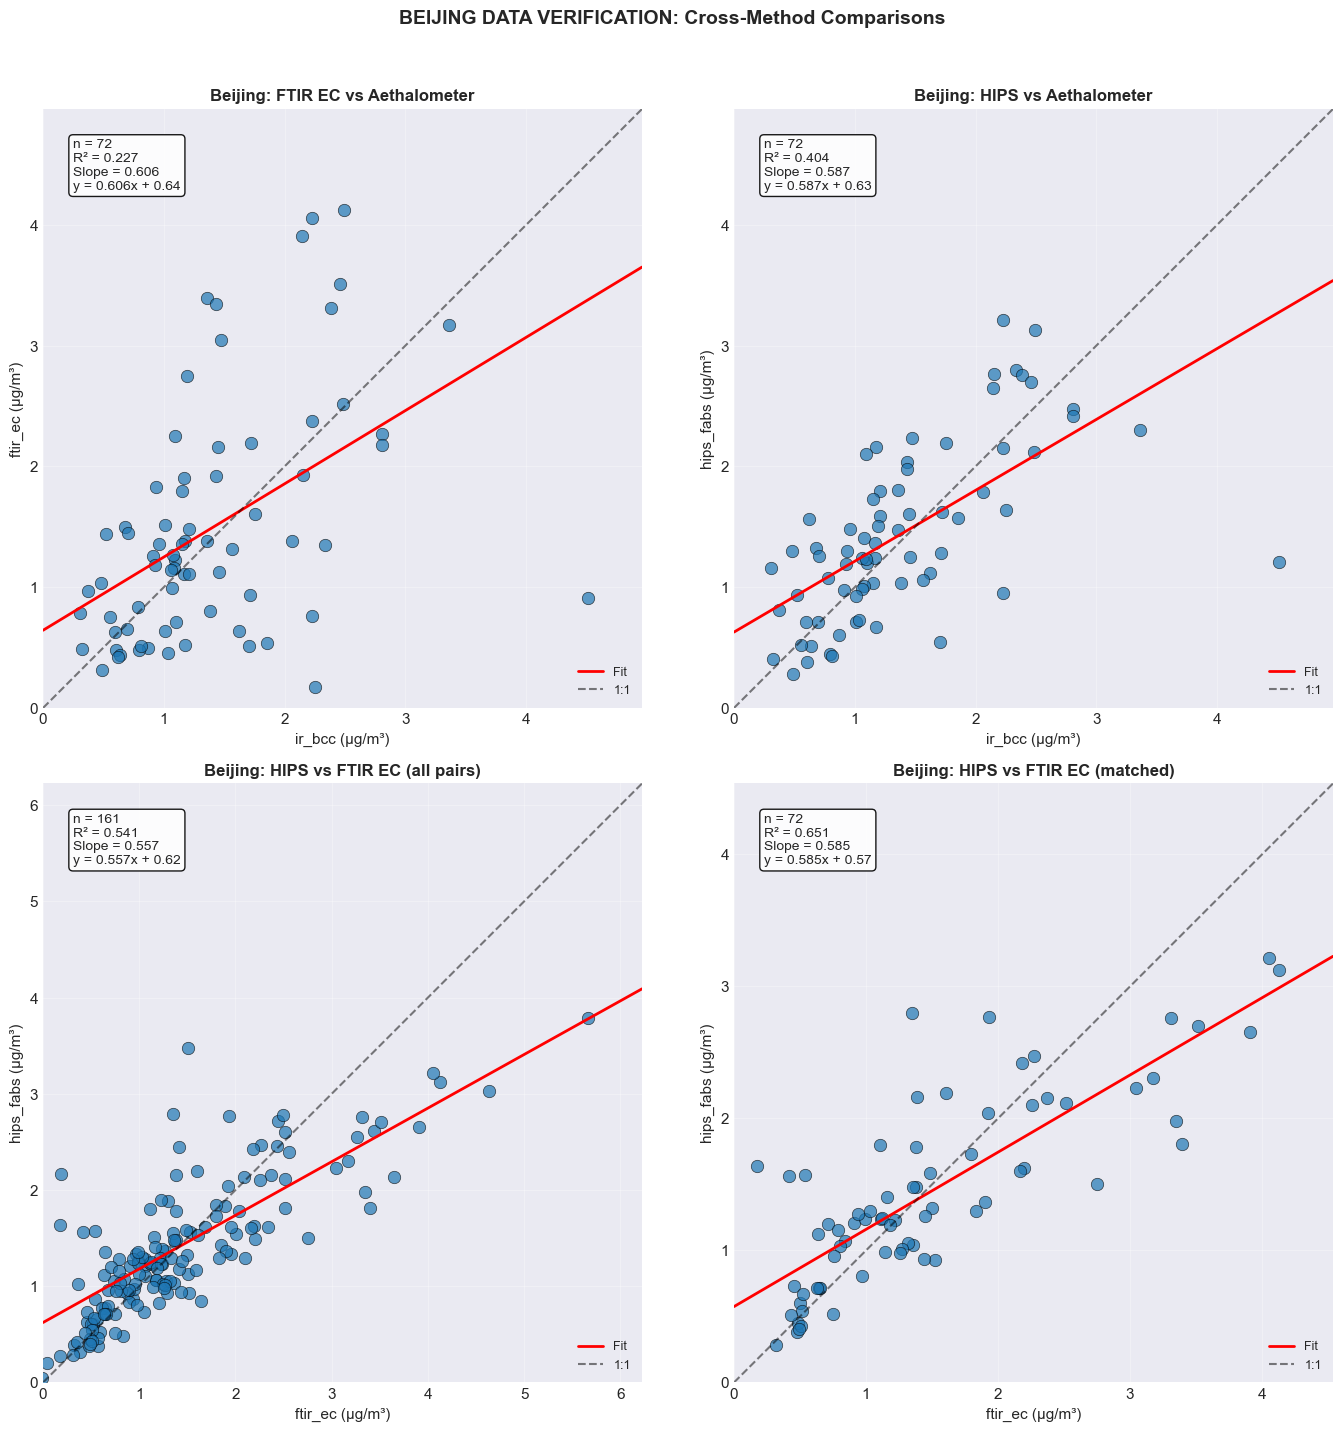


--- Beijing Regression Summary ---
Comparison                                 n         R²      Slope    Intercept
--------------------------------------------------------------------------------
FTIR EC vs Aethalometer                   72      0.227      0.606        0.643
HIPS vs Aethalometer                      72      0.404      0.587        0.628
HIPS vs FTIR EC (all pairs)              161      0.541      0.557        0.623
HIPS vs FTIR EC (matched)                 72      0.651      0.585        0.575

--- Note ---
'HIPS vs FTIR EC (all pairs)' uses all samples where both HIPS and FTIR EC exist
'HIPS vs FTIR EC (matched)' uses only samples where Aethalometer data also exists


In [6]:
# Beijing cross-method regression verification
print("\n" + "="*80)
print("BEIJING: CROSS-METHOD REGRESSION VERIFICATION")
print("="*80)

if 'Beijing' in all_params_data:
    beijing_df = all_params_data['Beijing']
    
    # Create mask for samples where ALL THREE measurements are available
    all_three_mask = (beijing_df['ir_bcc'].notna() & 
                      beijing_df['ftir_ec'].notna() & 
                      beijing_df['hips_fabs'].notna())
    n_all_three = all_three_mask.sum()
    print(f"\nSamples with all 3 measurements (Aeth, FTIR EC, HIPS): {n_all_three}")
    
    comparisons = [
        ('FTIR EC vs Aethalometer', 'ir_bcc', 'ftir_ec', None),  # All available pairs
        ('HIPS vs Aethalometer', 'ir_bcc', 'hips_fabs', None),   # All available pairs
        ('HIPS vs FTIR EC (all pairs)', 'ftir_ec', 'hips_fabs', None),  # All available pairs
        ('HIPS vs FTIR EC (matched)', 'ftir_ec', 'hips_fabs', all_three_mask),  # Only where all 3 exist
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    results = {}
    
    for idx, (name, x_col, y_col, extra_mask) in enumerate(comparisons):
        ax = axes[idx]
        
        if x_col not in beijing_df.columns or y_col not in beijing_df.columns:
            ax.text(0.5, 0.5, f'Missing columns', transform=ax.transAxes, ha='center')
            continue
        
        # Apply mask - either default (both columns valid) or with extra constraint
        valid_mask = beijing_df[x_col].notna() & beijing_df[y_col].notna()
        if extra_mask is not None:
            valid_mask = valid_mask & extra_mask
        
        x = beijing_df.loc[valid_mask, x_col].values
        y = beijing_df.loc[valid_mask, y_col].values
        
        if len(x) < 3:
            ax.text(0.5, 0.5, f'Insufficient data (n={len(x)})', transform=ax.transAxes, ha='center')
            continue
        
        # Scatter plot
        ax.scatter(x, y, c=SITE_COLORS['Beijing'], alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
        
        # Regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Store results
        results[name] = {'n': len(x), 'r2': r_value**2, 'slope': slope, 'intercept': intercept}
        
        # Plot regression line
        max_val = max(x.max(), y.max()) * 1.1
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, label=f'Fit')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1')
        
        # Stats text
        sign = '+' if intercept >= 0 else '-'
        stats_text = f"n = {len(x)}\nR² = {r_value**2:.3f}\nSlope = {slope:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel(f'{x_col} (µg/m³)', fontsize=11)
        ax.set_ylabel(f'{y_col} (µg/m³)', fontsize=11)
        ax.set_title(f'Beijing: {name}', fontsize=12, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('BEIJING DATA VERIFICATION: Cross-Method Comparisons', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n--- Beijing Regression Summary ---")
    print(f"{'Comparison':<35s} {'n':>8s} {'R²':>10s} {'Slope':>10s} {'Intercept':>12s}")
    print("-" * 80)
    for name, r in results.items():
        print(f"{name:<35s} {r['n']:>8d} {r['r2']:>10.3f} {r['slope']:>10.3f} {r['intercept']:>12.3f}")
    
    # Highlight the comparison
    print("\n--- Note ---")
    print("'HIPS vs FTIR EC (all pairs)' uses all samples where both HIPS and FTIR EC exist")
    print("'HIPS vs FTIR EC (matched)' uses only samples where Aethalometer data also exists")

---

# Task 2: Replot Iron Analysis with Absolute Iron Concentration

**Goal**: Instead of using Iron/EC ratio, plot using absolute iron concentration to see if that reveals different patterns.

From the meeting: The advisor asked if absolute iron concentration might be more relevant than the ratio.

In [7]:
# Combine all sites for iron analysis
print("="*80)
print("TASK 2: ABSOLUTE IRON CONCENTRATION ANALYSIS")
print("="*80)

combined_data = []
for site_name, df in all_params_data.items():
    df_copy = df.copy()
    df_copy['site'] = site_name
    combined_data.append(df_copy)

combined_df = pd.concat(combined_data, ignore_index=True)
print(f"Combined dataset: {len(combined_df)} total samples")
print(f"\nSamples per site:")
print(combined_df['site'].value_counts())

# Iron statistics
if 'iron' in combined_df.columns:
    print("\n--- Absolute Iron Concentration Statistics ---")
    valid_iron = combined_df['iron'].dropna()
    print(f"Overall (n={len(valid_iron)}):")
    print(f"  Mean: {valid_iron.mean():.3f} µg/m³")
    print(f"  Median: {valid_iron.median():.3f} µg/m³")
    print(f"  Std: {valid_iron.std():.3f} µg/m³")
    print(f"  Range: {valid_iron.min():.3f} - {valid_iron.max():.3f} µg/m³")
    
    print("\nBy Site:")
    for site_name in SITES:
        if site_name in all_params_data and 'iron' in all_params_data[site_name].columns:
            site_iron = all_params_data[site_name]['iron'].dropna()
            if len(site_iron) > 0:
                print(f"  {site_name}: median={site_iron.median():.3f}, range={site_iron.min():.3f}-{site_iron.max():.3f} (n={len(site_iron)})")

TASK 2: ABSOLUTE IRON CONCENTRATION ANALYSIS
Combined dataset: 698 total samples

Samples per site:
site
JPL            253
Beijing        193
Addis_Ababa    189
Delhi           63
Name: count, dtype: int64

--- Absolute Iron Concentration Statistics ---
Overall (n=646):
  Mean: 276.132 µg/m³
  Median: 211.325 µg/m³
  Std: 284.892 µg/m³
  Range: 2.040 - 3795.770 µg/m³

By Site:
  Beijing: median=342.830, range=49.890-3795.770 (n=180)
  Delhi: median=660.720, range=266.430-1204.760 (n=27)
  JPL: median=72.900, range=2.040-189.240 (n=251)
  Addis_Ababa: median=290.515, range=59.750-1198.340 (n=188)


In [8]:
def plot_with_absolute_iron(df, x_col, y_col, xlabel, ylabel, title, cmap='plasma'):
    """
    Create a scatter plot with ABSOLUTE iron concentration as color gradient.
    """
    valid_mask = df[x_col].notna() & df[y_col].notna() & df['iron'].notna()
    df_valid = df[valid_mask].copy()
    
    if len(df_valid) < 3:
        print("Insufficient data")
        return None
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    x = df_valid[x_col].values
    y = df_valid[y_col].values
    iron = df_valid['iron'].values  # Absolute iron, not ratio
    
    # Color limits
    vmin = np.percentile(iron, 5)
    vmax = np.percentile(iron, 95)
    
    scatter = ax.scatter(x, y, c=iron, cmap=cmap, alpha=0.7, s=80,
                        edgecolors='black', linewidth=0.5, vmin=vmin, vmax=vmax)
    
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Absolute Iron (µg/m³)', fontsize=11)
    
    # Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    max_val = max(x.max(), y.max()) * 1.05
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    x_line = np.array([0, max_val])
    ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, label=f'Fit: R²={r_value**2:.3f}')
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
    
    sign = '+' if intercept >= 0 else '-'
    stats_text = f"n = {len(x)}\nR² = {r_value**2:.3f}\nSlope = {slope:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}"
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()
    
    return {'n': len(x), 'r2': r_value**2, 'slope': slope, 'intercept': intercept}


--- FTIR EC vs Aethalometer (Colored by Absolute Iron) ---


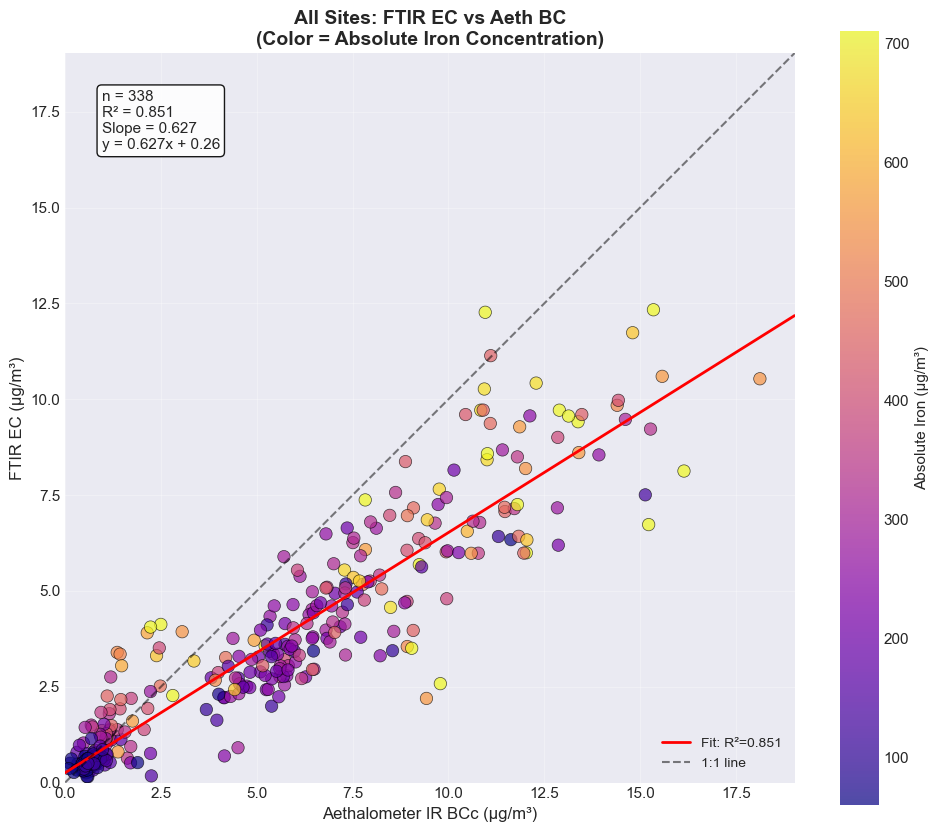

In [9]:
# Plot FTIR EC vs Aethalometer colored by ABSOLUTE iron
print("\n--- FTIR EC vs Aethalometer (Colored by Absolute Iron) ---")
results_aeth = plot_with_absolute_iron(
    combined_df,
    x_col='ir_bcc',
    y_col='ftir_ec',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title='All Sites: FTIR EC vs Aeth BC\n(Color = Absolute Iron Concentration)',
    cmap='plasma'
)


--- HIPS vs FTIR EC (Colored by Absolute Iron) ---


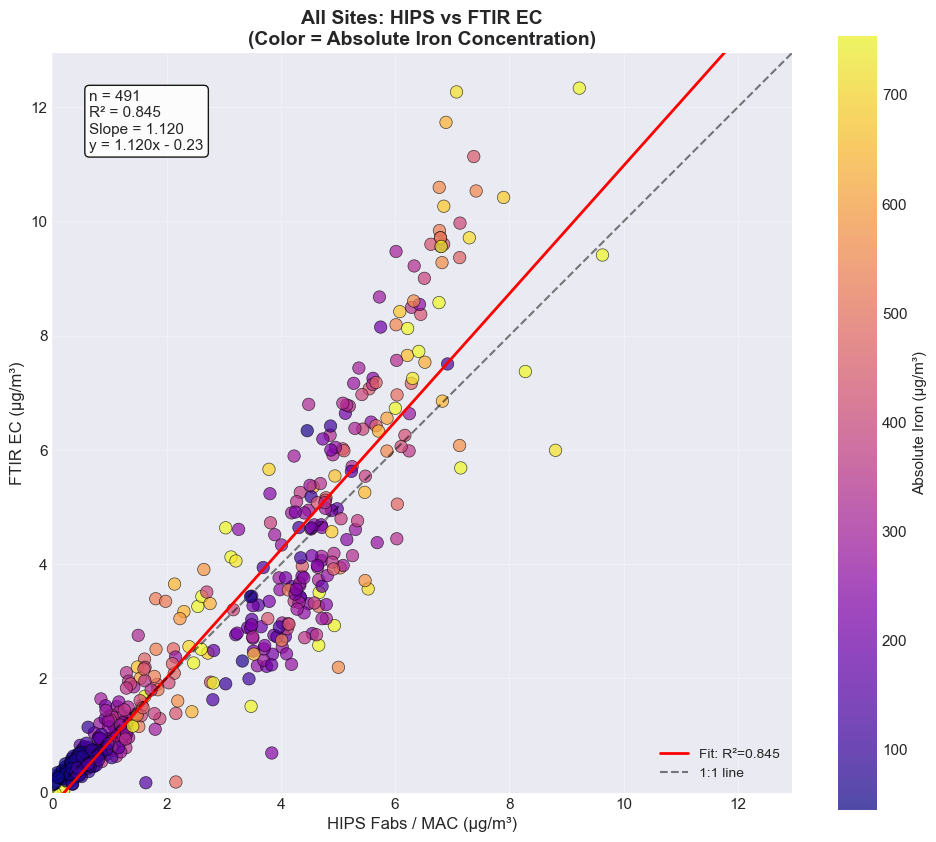

In [10]:
# Plot HIPS vs FTIR EC colored by ABSOLUTE iron
print("\n--- HIPS vs FTIR EC (Colored by Absolute Iron) ---")
results_hips = plot_with_absolute_iron(
    combined_df,
    x_col='hips_fabs',
    y_col='ftir_ec',
    xlabel='HIPS Fabs / MAC (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title='All Sites: HIPS vs FTIR EC\n(Color = Absolute Iron Concentration)',
    cmap='plasma'
)


--- COMPARISON: Absolute Iron vs Iron/EC Ratio Coloring ---


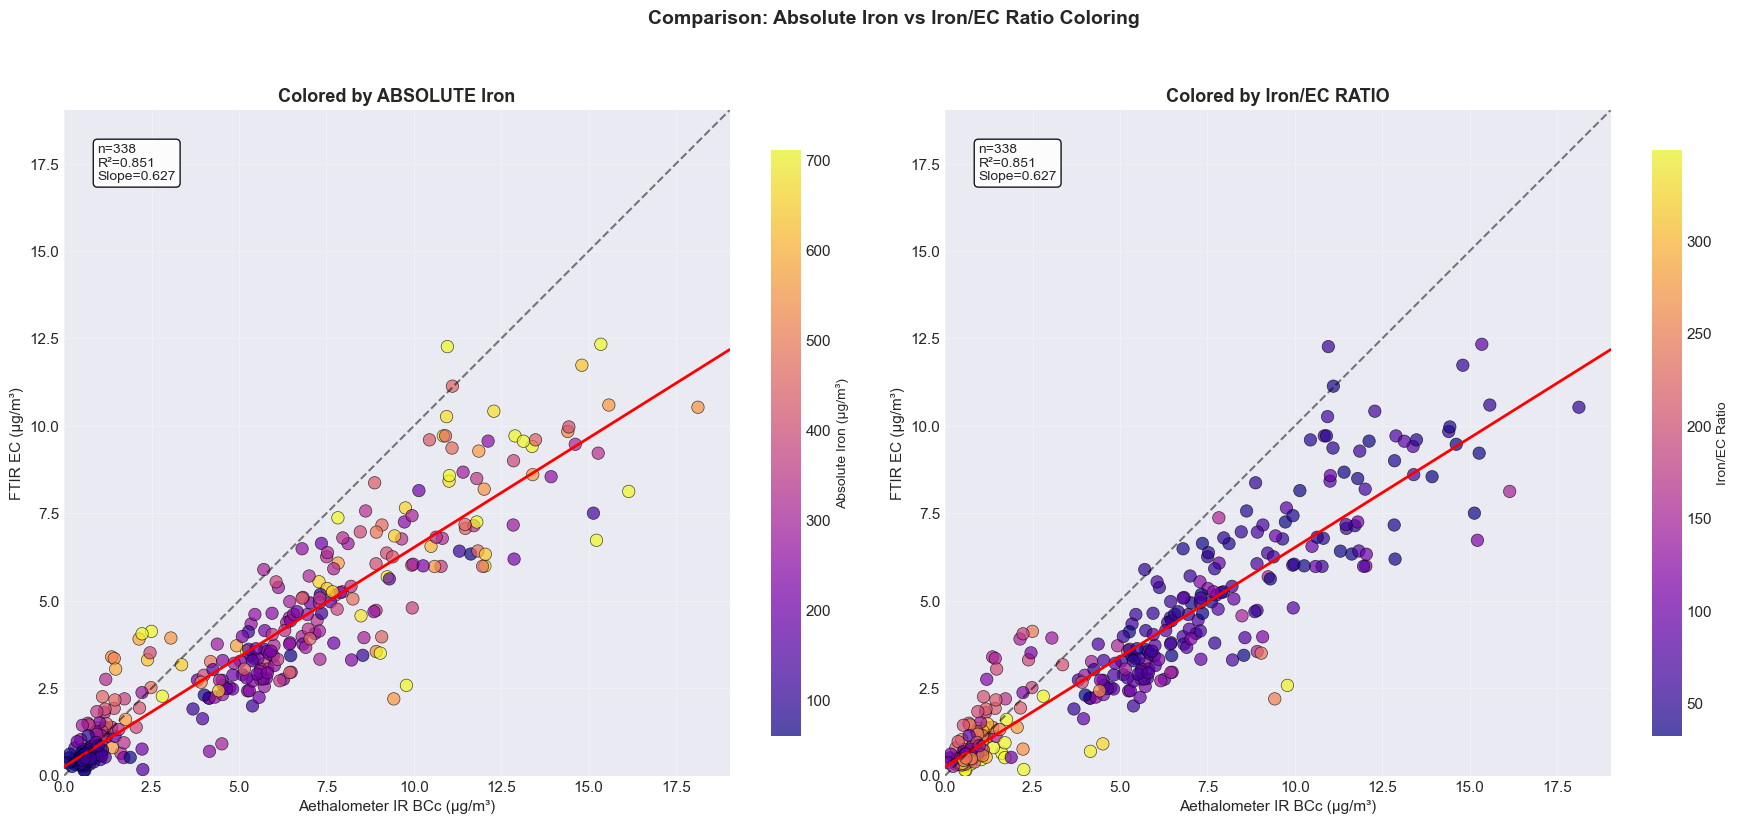

In [11]:
# Side-by-side comparison: Absolute Iron vs Iron/EC Ratio coloring
print("\n--- COMPARISON: Absolute Iron vs Iron/EC Ratio Coloring ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

valid_mask = (combined_df['ir_bcc'].notna() & 
              combined_df['ftir_ec'].notna() & 
              combined_df['iron'].notna() &
              combined_df['iron_ec_ratio'].notna())
df_valid = combined_df[valid_mask].copy()

x = df_valid['ir_bcc'].values
y = df_valid['ftir_ec'].values
iron_abs = df_valid['iron'].values
iron_ratio = df_valid['iron_ec_ratio'].values

max_val = max(x.max(), y.max()) * 1.05

# Left: Absolute Iron
ax = axes[0]
scatter1 = ax.scatter(x, y, c=iron_abs, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_abs, 5), vmax=np.percentile(iron_abs, 95))
cbar1 = plt.colorbar(scatter1, ax=ax, shrink=0.8)
cbar1.set_label('Absolute Iron (µg/m³)', fontsize=10)

slope, intercept, r_value, _, _ = stats.linregress(x, y)
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
ax.set_title('Colored by ABSOLUTE Iron', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

# Right: Iron/EC Ratio
ax = axes[1]
scatter2 = ax.scatter(x, y, c=iron_ratio, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_ratio, 5), vmax=np.percentile(iron_ratio, 95))
cbar2 = plt.colorbar(scatter2, ax=ax, shrink=0.8)
cbar2.set_label('Iron/EC Ratio', fontsize=10)

ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
ax.set_title('Colored by Iron/EC RATIO', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

plt.suptitle('Comparison: Absolute Iron vs Iron/EC Ratio Coloring', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


--- COMPARISON: HIPS vs FTIR EC - Absolute Iron vs Iron/EC Ratio Coloring ---


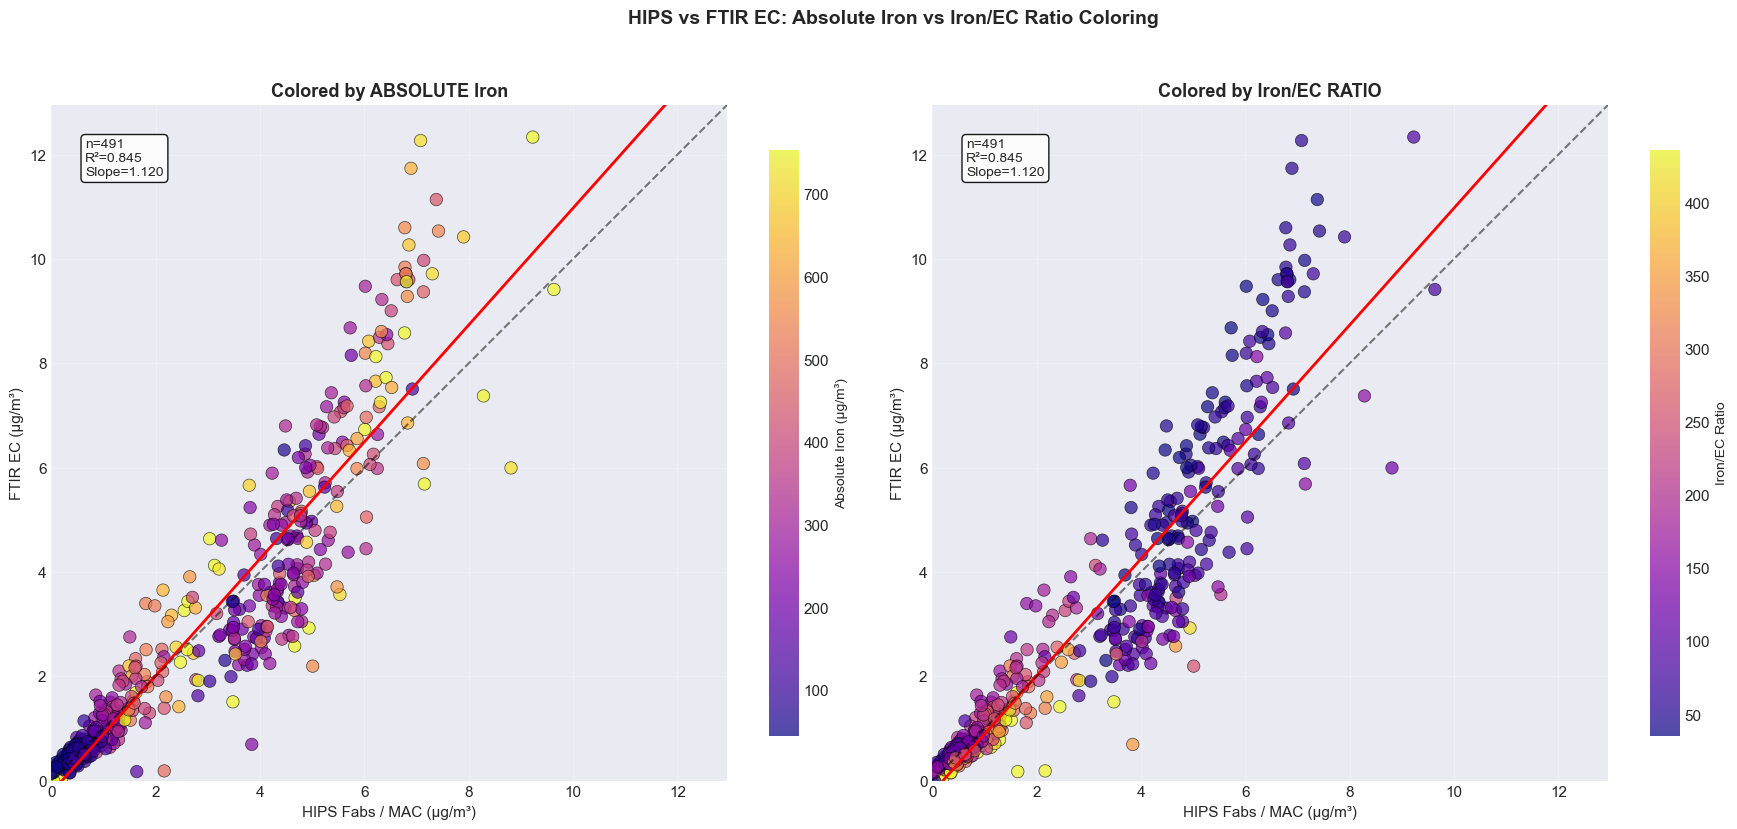

In [12]:
# Side-by-side comparison: Absolute Iron vs Iron/EC Ratio coloring for HIPS vs FTIR EC
print("\n--- COMPARISON: HIPS vs FTIR EC - Absolute Iron vs Iron/EC Ratio Coloring ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

valid_mask = (combined_df['hips_fabs'].notna() & 
              combined_df['ftir_ec'].notna() & 
              combined_df['iron'].notna() &
              combined_df['iron_ec_ratio'].notna())
df_valid = combined_df[valid_mask].copy()

x = df_valid['hips_fabs'].values
y = df_valid['ftir_ec'].values
iron_abs = df_valid['iron'].values
iron_ratio = df_valid['iron_ec_ratio'].values

max_val = max(x.max(), y.max()) * 1.05

# Left: Absolute Iron
ax = axes[0]
scatter1 = ax.scatter(x, y, c=iron_abs, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_abs, 5), vmax=np.percentile(iron_abs, 95))
cbar1 = plt.colorbar(scatter1, ax=ax, shrink=0.8)
cbar1.set_label('Absolute Iron (µg/m³)', fontsize=10)

slope, intercept, r_value, _, _ = stats.linregress(x, y)
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
ax.set_title('Colored by ABSOLUTE Iron', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

# Right: Iron/EC Ratio
ax = axes[1]
scatter2 = ax.scatter(x, y, c=iron_ratio, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_ratio, 5), vmax=np.percentile(iron_ratio, 95))
cbar2 = plt.colorbar(scatter2, ax=ax, shrink=0.8)
cbar2.set_label('Iron/EC Ratio', fontsize=10)

ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
ax.set_title('Colored by Iron/EC RATIO', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

plt.suptitle('HIPS vs FTIR EC: Absolute Iron vs Iron/EC Ratio Coloring', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


--- COMPARISON: HIPS vs FTIR EC (MATCHED - same samples as Aeth comparison) ---
Samples with ALL measurements (Aeth + HIPS + FTIR EC + Iron): 338


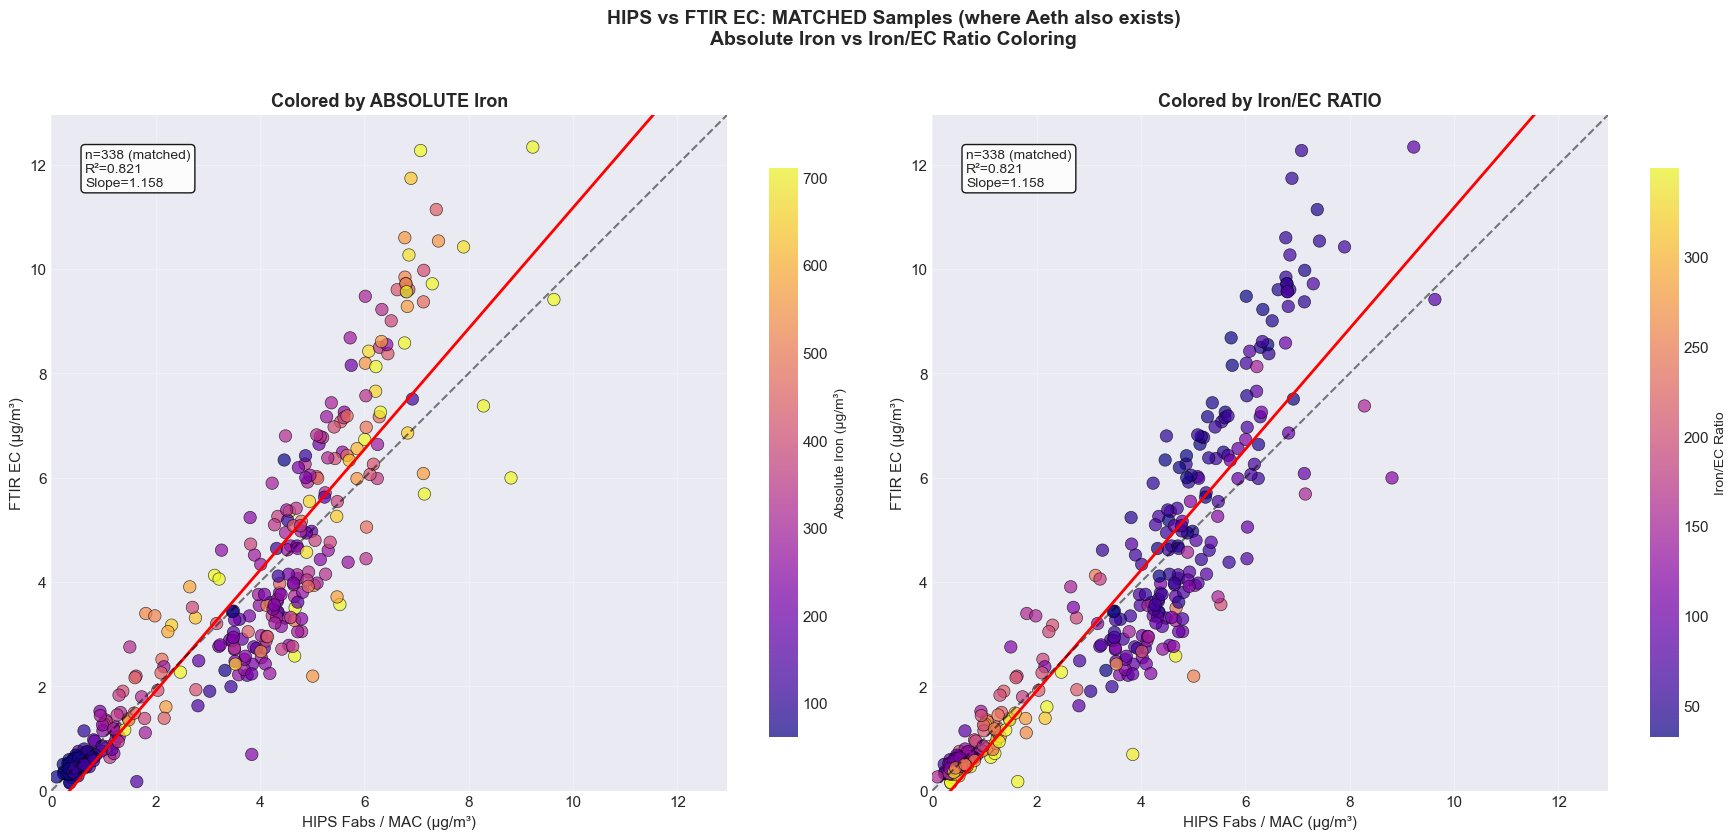


--- Comparison: All pairs vs Matched samples ---
All HIPS vs FTIR EC pairs (with iron): 491
Matched samples (where Aeth also exists): 338
Difference: 153 samples only have HIPS+FTIR (no Aeth)


In [13]:
# Side-by-side comparison: HIPS vs FTIR EC - MATCHED samples (where Aeth also exists)
# This uses only samples where ALL THREE measurements (Aeth, HIPS, FTIR EC) are available
print("\n--- COMPARISON: HIPS vs FTIR EC (MATCHED - same samples as Aeth comparison) ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Use only samples where ALL THREE measurements exist (matching the Aeth comparison)
valid_mask = (combined_df['ir_bcc'].notna() &  # Aethalometer exists
              combined_df['hips_fabs'].notna() & 
              combined_df['ftir_ec'].notna() & 
              combined_df['iron'].notna() &
              combined_df['iron_ec_ratio'].notna())
df_valid = combined_df[valid_mask].copy()

print(f"Samples with ALL measurements (Aeth + HIPS + FTIR EC + Iron): {len(df_valid)}")

x = df_valid['hips_fabs'].values
y = df_valid['ftir_ec'].values
iron_abs = df_valid['iron'].values
iron_ratio = df_valid['iron_ec_ratio'].values

max_val = max(x.max(), y.max()) * 1.05

# Left: Absolute Iron
ax = axes[0]
scatter1 = ax.scatter(x, y, c=iron_abs, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_abs, 5), vmax=np.percentile(iron_abs, 95))
cbar1 = plt.colorbar(scatter1, ax=ax, shrink=0.8)
cbar1.set_label('Absolute Iron (µg/m³)', fontsize=10)

slope, intercept, r_value, _, _ = stats.linregress(x, y)
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)} (matched)\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
ax.set_title('Colored by ABSOLUTE Iron', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

# Right: Iron/EC Ratio
ax = axes[1]
scatter2 = ax.scatter(x, y, c=iron_ratio, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_ratio, 5), vmax=np.percentile(iron_ratio, 95))
cbar2 = plt.colorbar(scatter2, ax=ax, shrink=0.8)
cbar2.set_label('Iron/EC Ratio', fontsize=10)

ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)} (matched)\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
ax.set_title('Colored by Iron/EC RATIO', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

plt.suptitle('HIPS vs FTIR EC: MATCHED Samples (where Aeth also exists)\nAbsolute Iron vs Iron/EC Ratio Coloring', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print comparison between all pairs vs matched
print("\n--- Comparison: All pairs vs Matched samples ---")
# Count all HIPS vs FTIR pairs
all_pairs_mask = (combined_df['hips_fabs'].notna() & 
                  combined_df['ftir_ec'].notna() & 
                  combined_df['iron'].notna())
n_all_pairs = all_pairs_mask.sum()
print(f"All HIPS vs FTIR EC pairs (with iron): {n_all_pairs}")
print(f"Matched samples (where Aeth also exists): {len(df_valid)}")
print(f"Difference: {n_all_pairs - len(df_valid)} samples only have HIPS+FTIR (no Aeth)")


--- COMPARISON: HIPS vs Aethalometer - Absolute Iron vs Iron/EC Ratio Coloring ---


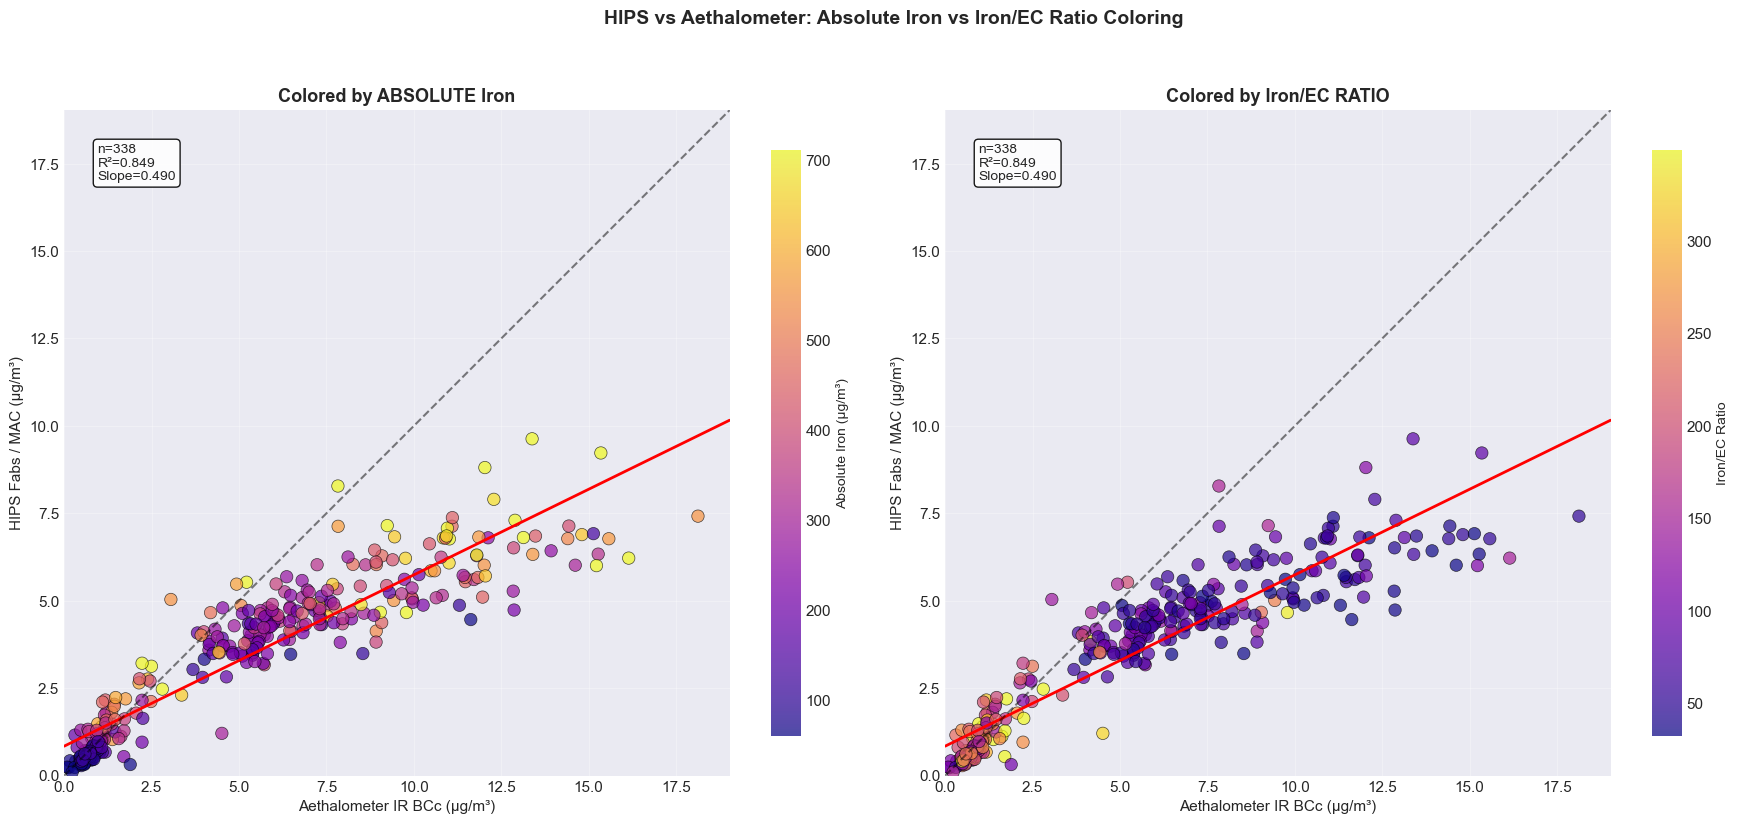

In [14]:
# Side-by-side comparison: Absolute Iron vs Iron/EC Ratio coloring for HIPS vs Aethalometer
print("\n--- COMPARISON: HIPS vs Aethalometer - Absolute Iron vs Iron/EC Ratio Coloring ---")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

valid_mask = (combined_df['ir_bcc'].notna() & 
              combined_df['hips_fabs'].notna() & 
              combined_df['iron'].notna() &
              combined_df['iron_ec_ratio'].notna())
df_valid = combined_df[valid_mask].copy()

x = df_valid['ir_bcc'].values
y = df_valid['hips_fabs'].values
iron_abs = df_valid['iron'].values
iron_ratio = df_valid['iron_ec_ratio'].values

max_val = max(x.max(), y.max()) * 1.05

# Left: Absolute Iron
ax = axes[0]
scatter1 = ax.scatter(x, y, c=iron_abs, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_abs, 5), vmax=np.percentile(iron_abs, 95))
cbar1 = plt.colorbar(scatter1, ax=ax, shrink=0.8)
cbar1.set_label('Absolute Iron (µg/m³)', fontsize=10)

slope, intercept, r_value, _, _ = stats.linregress(x, y)
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
ax.set_ylabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
ax.set_title('Colored by ABSOLUTE Iron', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

# Right: Iron/EC Ratio
ax = axes[1]
scatter2 = ax.scatter(x, y, c=iron_ratio, cmap='plasma', alpha=0.7, s=80,
                      edgecolors='black', linewidth=0.5,
                      vmin=np.percentile(iron_ratio, 5), vmax=np.percentile(iron_ratio, 95))
cbar2 = plt.colorbar(scatter2, ax=ax, shrink=0.8)
cbar2.set_label('Iron/EC Ratio', fontsize=10)

ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
ax.text(0.05, 0.95, f"n={len(x)}\nR²={r_value**2:.3f}\nSlope={slope:.3f}",
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
ax.set_ylabel('HIPS Fabs / MAC (µg/m³)', fontsize=11)
ax.set_title('Colored by Iron/EC RATIO', fontsize=13, fontweight='bold')
ax.set_aspect('equal', adjustable='box')
ax.grid(True, alpha=0.3)

plt.suptitle('HIPS vs Aethalometer: Absolute Iron vs Iron/EC Ratio Coloring', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# Task 3: Separate Analyses by Concentration Group

**Goal**: Separate all analyses into two groups:
- **High concentration sites**: Addis Ababa, Delhi
- **Low concentration sites**: Beijing, JPL

This will help visualize the low-concentration data that gets compressed when all sites are plotted together.

In [15]:
# Create separate DataFrames for high and low concentration site groups
print("="*80)
print("TASK 3: SITE GROUPING BY CONCENTRATION")
print("="*80)

high_conc_data = combined_df[combined_df['site'].isin(HIGH_CONCENTRATION_SITES)].copy()
low_conc_data = combined_df[combined_df['site'].isin(LOW_CONCENTRATION_SITES)].copy()

print(f"\nHigh Concentration Sites (Addis Ababa, Delhi): {len(high_conc_data)} samples")
print(high_conc_data['site'].value_counts())

print(f"\nLow Concentration Sites (Beijing, JPL): {len(low_conc_data)} samples")
print(low_conc_data['site'].value_counts())

TASK 3: SITE GROUPING BY CONCENTRATION

High Concentration Sites (Addis Ababa, Delhi): 252 samples
site
Addis_Ababa    189
Delhi           63
Name: count, dtype: int64

Low Concentration Sites (Beijing, JPL): 446 samples
site
JPL        253
Beijing    193
Name: count, dtype: int64


In [16]:
def plot_grouped_comparison(high_df, low_df, x_col, y_col, xlabel, ylabel, title_base, color_col='iron'):
    """
    Create side-by-side plots for high and low concentration site groups.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    for ax, (df, group_name, sites) in zip(axes, [
        (high_df, 'HIGH Concentration', 'Addis Ababa, Delhi'),
        (low_df, 'LOW Concentration', 'Beijing, JPL')
    ]):
        valid_mask = df[x_col].notna() & df[y_col].notna()
        if color_col and color_col in df.columns:
            valid_mask = valid_mask & df[color_col].notna()
        
        df_valid = df[valid_mask]
        
        if len(df_valid) < 3:
            ax.text(0.5, 0.5, f'{group_name}\nInsufficient data (n={len(df_valid)})',
                   transform=ax.transAxes, ha='center', va='center', fontsize=14)
            ax.set_title(f'{group_name}\n({sites})', fontsize=12, fontweight='bold')
            continue
        
        x = df_valid[x_col].values
        y = df_valid[y_col].values
        
        # Determine max value for THIS group only (key change!)
        max_val = max(x.max(), y.max()) * 1.1
        
        if color_col and color_col in df_valid.columns:
            c = df_valid[color_col].values
            scatter = ax.scatter(x, y, c=c, cmap='plasma', alpha=0.7, s=80,
                                edgecolors='black', linewidth=0.5,
                                vmin=np.percentile(c, 5), vmax=np.percentile(c, 95))
            cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
            cbar.set_label(f'{color_col} (µg/m³)', fontsize=10)
        else:
            ax.scatter(x, y, alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
        
        # Regression
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, label='Fit')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1')
        
        sign = '+' if intercept >= 0 else '-'
        stats_text = f"n = {len(x)}\nR² = {r_value**2:.3f}\nSlope = {slope:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.set_title(f'{group_name}\n({sites})', fontsize=12, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title_base, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


--- FTIR EC vs Aethalometer: High vs Low Concentration Sites ---


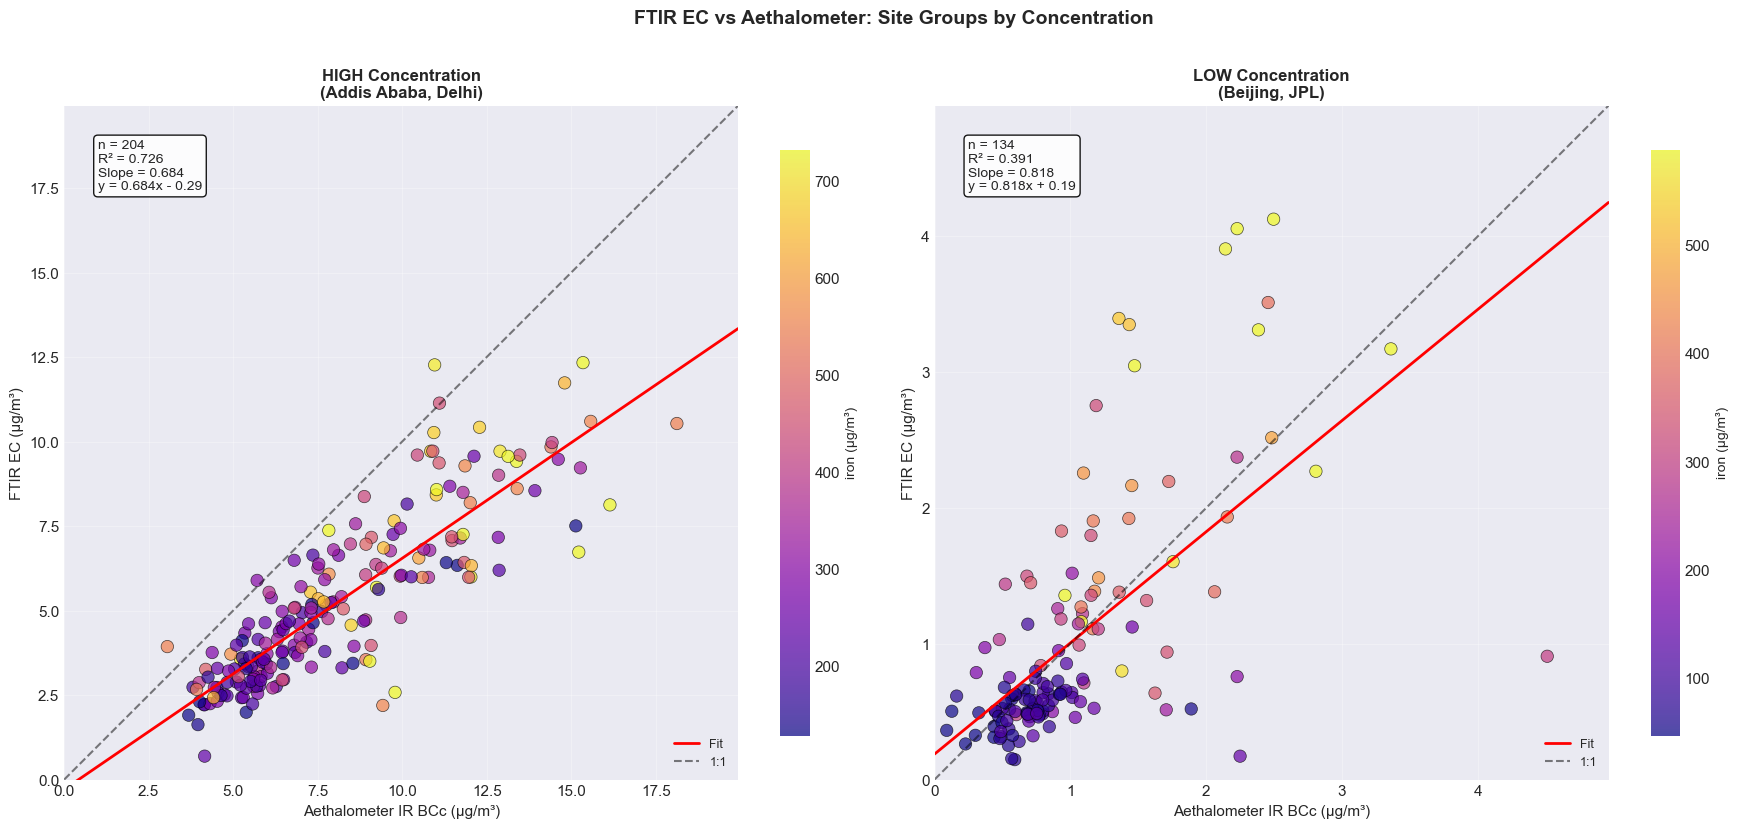

In [17]:
# FTIR EC vs Aethalometer - grouped by concentration
print("\n--- FTIR EC vs Aethalometer: High vs Low Concentration Sites ---")
plot_grouped_comparison(
    high_conc_data, low_conc_data,
    x_col='ir_bcc', y_col='ftir_ec',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title_base='FTIR EC vs Aethalometer: Site Groups by Concentration',
    color_col='iron'
)


--- HIPS vs Aethalometer: High vs Low Concentration Sites ---


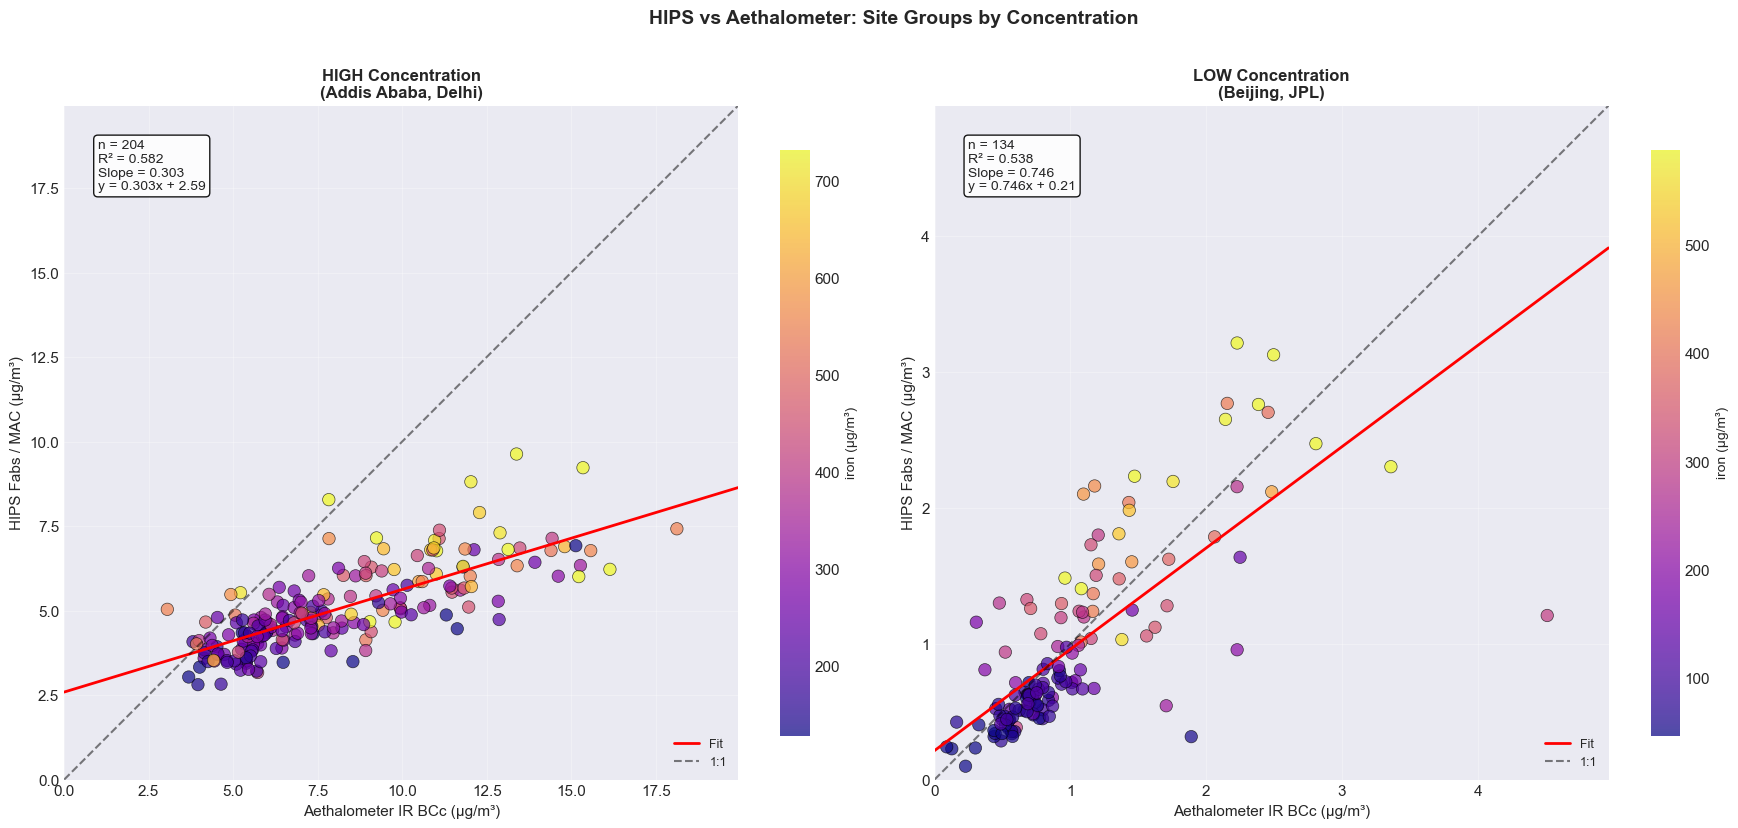

In [18]:
# HIPS vs Aethalometer - grouped by concentration
print("\n--- HIPS vs Aethalometer: High vs Low Concentration Sites ---")
plot_grouped_comparison(
    high_conc_data, low_conc_data,
    x_col='ir_bcc', y_col='hips_fabs',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='HIPS Fabs / MAC (µg/m³)',
    title_base='HIPS vs Aethalometer: Site Groups by Concentration',
    color_col='iron'
)

### Site Grouping by Concentration - Colored by Iron/EC Ratio

Same analysis as above, but with points colored by **Iron/EC Ratio** instead of absolute iron concentration. This helps visualize how the ratio (rather than absolute concentration) relates to measurement agreement.

In [19]:
# Modified plot function to handle iron_ec_ratio coloring properly
def plot_grouped_comparison_ratio(high_df, low_df, x_col, y_col, xlabel, ylabel, title_base):
    """
    Create side-by-side plots for high and low concentration site groups.
    Colored by Iron/EC Ratio.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    for ax, (df, group_name, sites) in zip(axes, [
        (high_df, 'HIGH Concentration', 'Addis Ababa, Delhi'),
        (low_df, 'LOW Concentration', 'Beijing, JPL')
    ]):
        valid_mask = df[x_col].notna() & df[y_col].notna() & df['iron_ec_ratio'].notna()
        df_valid = df[valid_mask]
        
        if len(df_valid) < 3:
            ax.text(0.5, 0.5, f'{group_name}\nInsufficient data (n={len(df_valid)})',
                   transform=ax.transAxes, ha='center', va='center', fontsize=14)
            ax.set_title(f'{group_name}\n({sites})', fontsize=12, fontweight='bold')
            continue
        
        x = df_valid[x_col].values
        y = df_valid[y_col].values
        c = df_valid['iron_ec_ratio'].values
        
        # Determine max value for THIS group only
        max_val = max(x.max(), y.max()) * 1.1
        
        # Color by Iron/EC ratio
        scatter = ax.scatter(x, y, c=c, cmap='plasma', alpha=0.7, s=80,
                            edgecolors='black', linewidth=0.5,
                            vmin=np.percentile(c, 5), vmax=np.percentile(c, 95))
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Iron/EC Ratio', fontsize=10)
        
        # Regression
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2, label='Fit')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1')
        
        sign = '+' if intercept >= 0 else '-'
        stats_text = f"n = {len(x)}\nR² = {r_value**2:.3f}\nSlope = {slope:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}\n\nIron/EC median: {np.median(c):.0f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.set_title(f'{group_name}\n({sites})', fontsize=12, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(title_base + '\n(Color = Iron/EC Ratio)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

print("Ratio coloring function defined.")

Ratio coloring function defined.



--- FTIR EC vs Aethalometer: High vs Low Concentration Sites (Iron/EC Ratio) ---


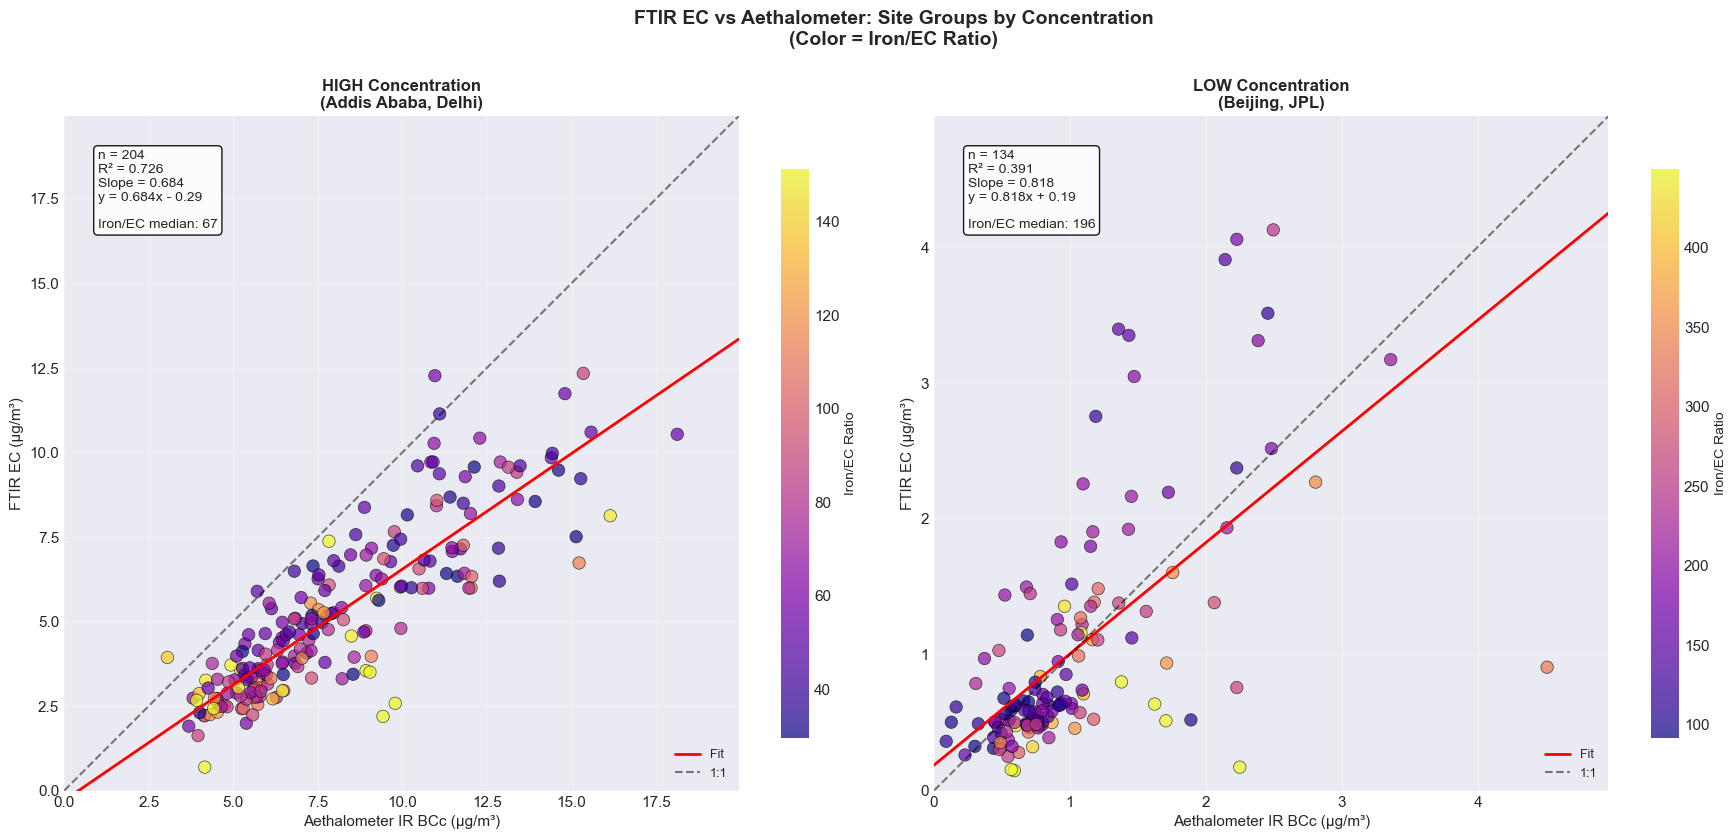

In [20]:
# FTIR EC vs Aethalometer - grouped by concentration, colored by Iron/EC RATIO
print("\n--- FTIR EC vs Aethalometer: High vs Low Concentration Sites (Iron/EC Ratio) ---")
plot_grouped_comparison_ratio(
    high_conc_data, low_conc_data,
    x_col='ir_bcc', y_col='ftir_ec',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title_base='FTIR EC vs Aethalometer: Site Groups by Concentration'
)


--- HIPS vs Aethalometer: High vs Low Concentration Sites (Iron/EC Ratio) ---


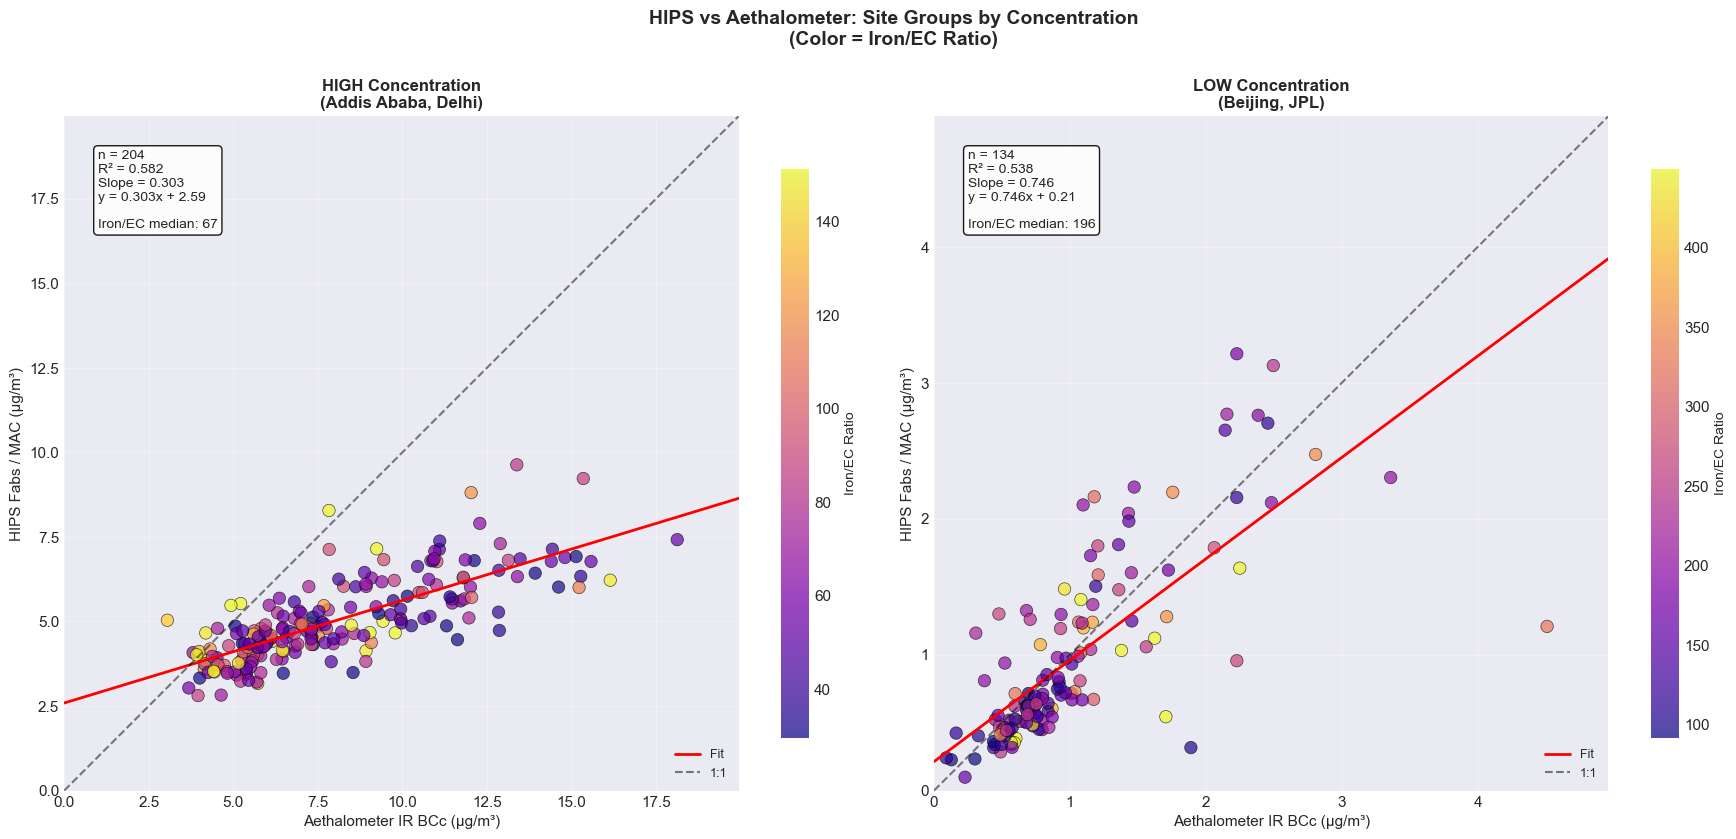

In [21]:
# HIPS vs Aethalometer - grouped by concentration, colored by Iron/EC RATIO
print("\n--- HIPS vs Aethalometer: High vs Low Concentration Sites (Iron/EC Ratio) ---")
plot_grouped_comparison_ratio(
    high_conc_data, low_conc_data,
    x_col='ir_bcc', y_col='hips_fabs',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='HIPS Fabs / MAC (µg/m³)',
    title_base='HIPS vs Aethalometer: Site Groups by Concentration'
)


--- HIPS vs FTIR EC: High vs Low Concentration Sites (Iron/EC Ratio) ---


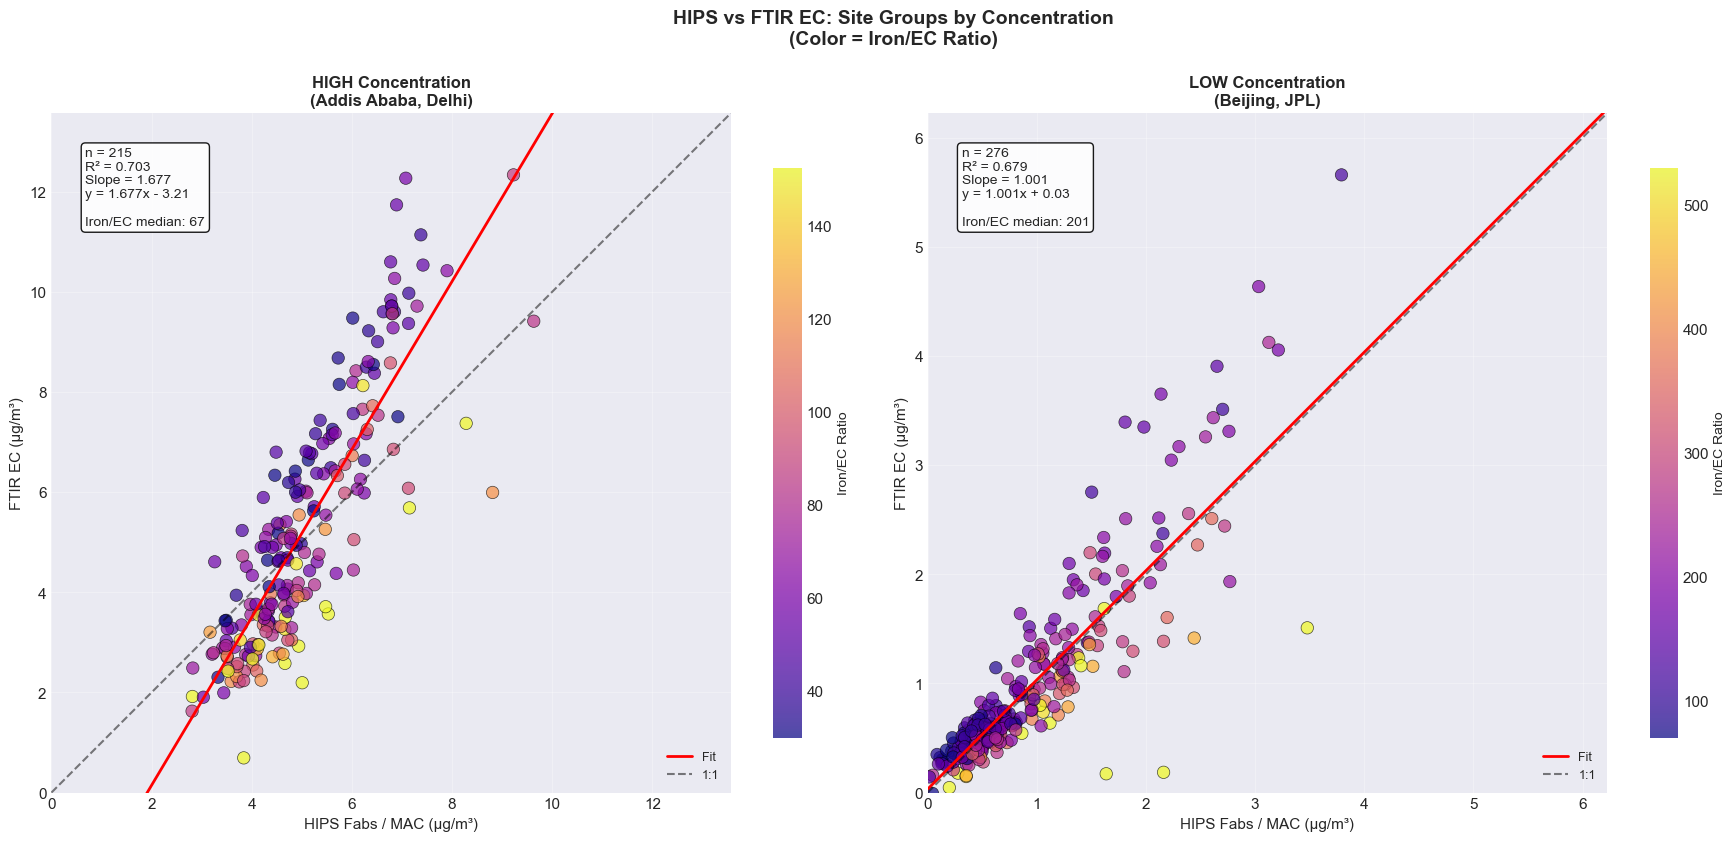

In [22]:
# HIPS vs FTIR EC - grouped by concentration, colored by Iron/EC RATIO
print("\n--- HIPS vs FTIR EC: High vs Low Concentration Sites (Iron/EC Ratio) ---")
plot_grouped_comparison_ratio(
    high_conc_data, low_conc_data,
    x_col='hips_fabs', y_col='ftir_ec',
    xlabel='HIPS Fabs / MAC (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title_base='HIPS vs FTIR EC: Site Groups by Concentration'
)

### Site Grouping: Matched vs All Pairs Comparison

Compare HIPS vs FTIR EC using:
- **All pairs**: All samples where both HIPS and FTIR EC exist
- **Matched**: Only samples where Aethalometer data also exists (same samples as Aeth comparison)

High concentration matched samples: 205
Low concentration matched samples: 140

--- FTIR EC vs Aethalometer: Matched Samples Only (Iron/EC Ratio) ---


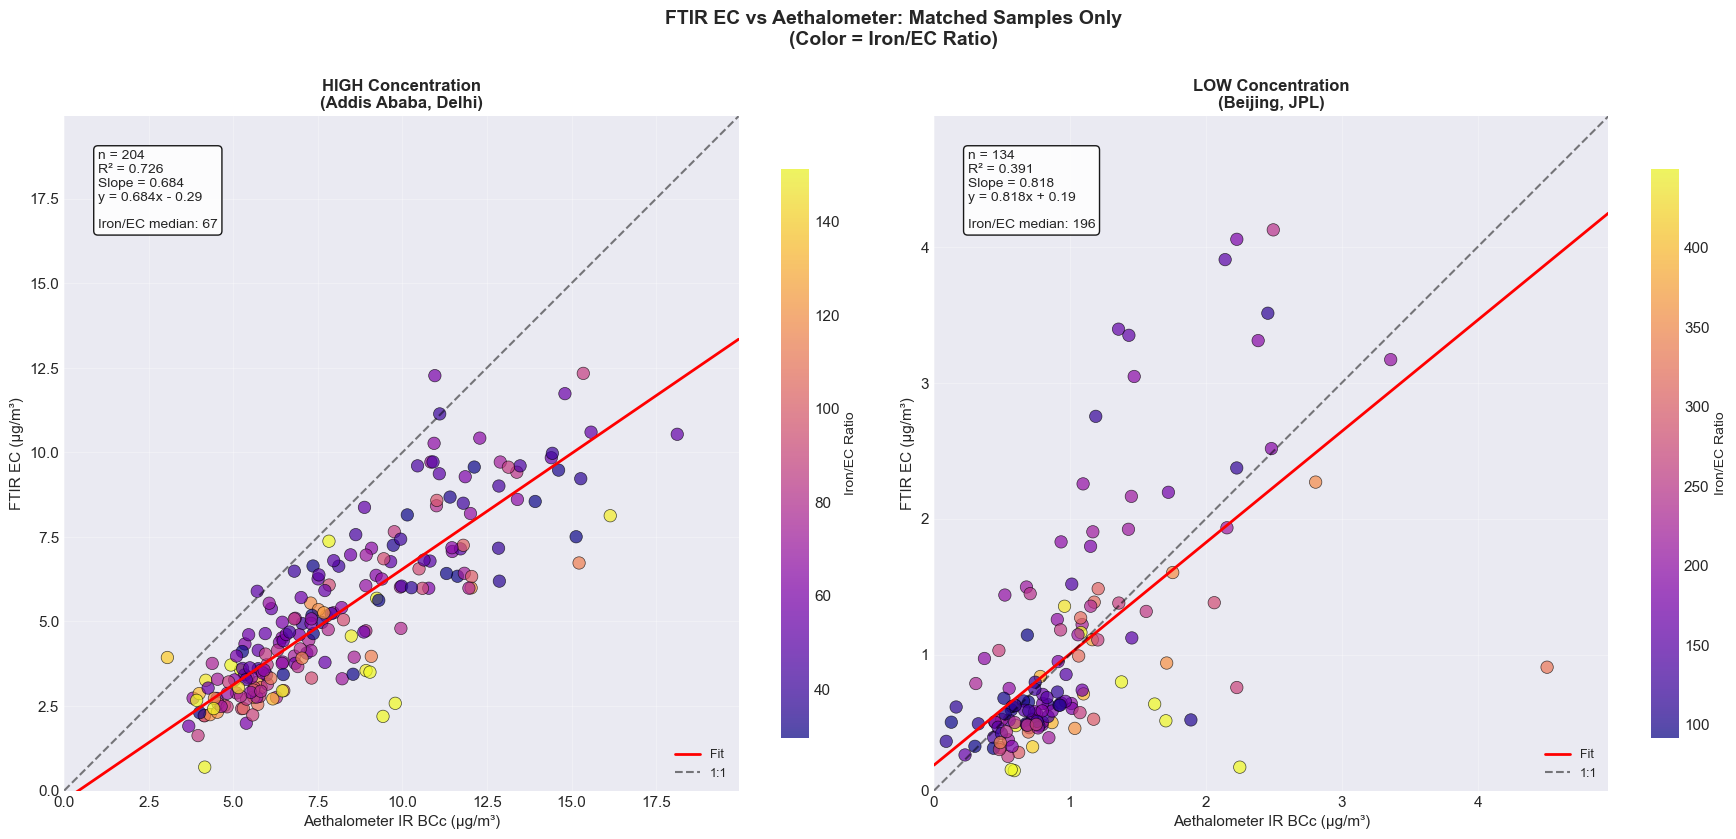


--- HIPS vs Aethalometer: Matched Samples Only (Iron/EC Ratio) ---


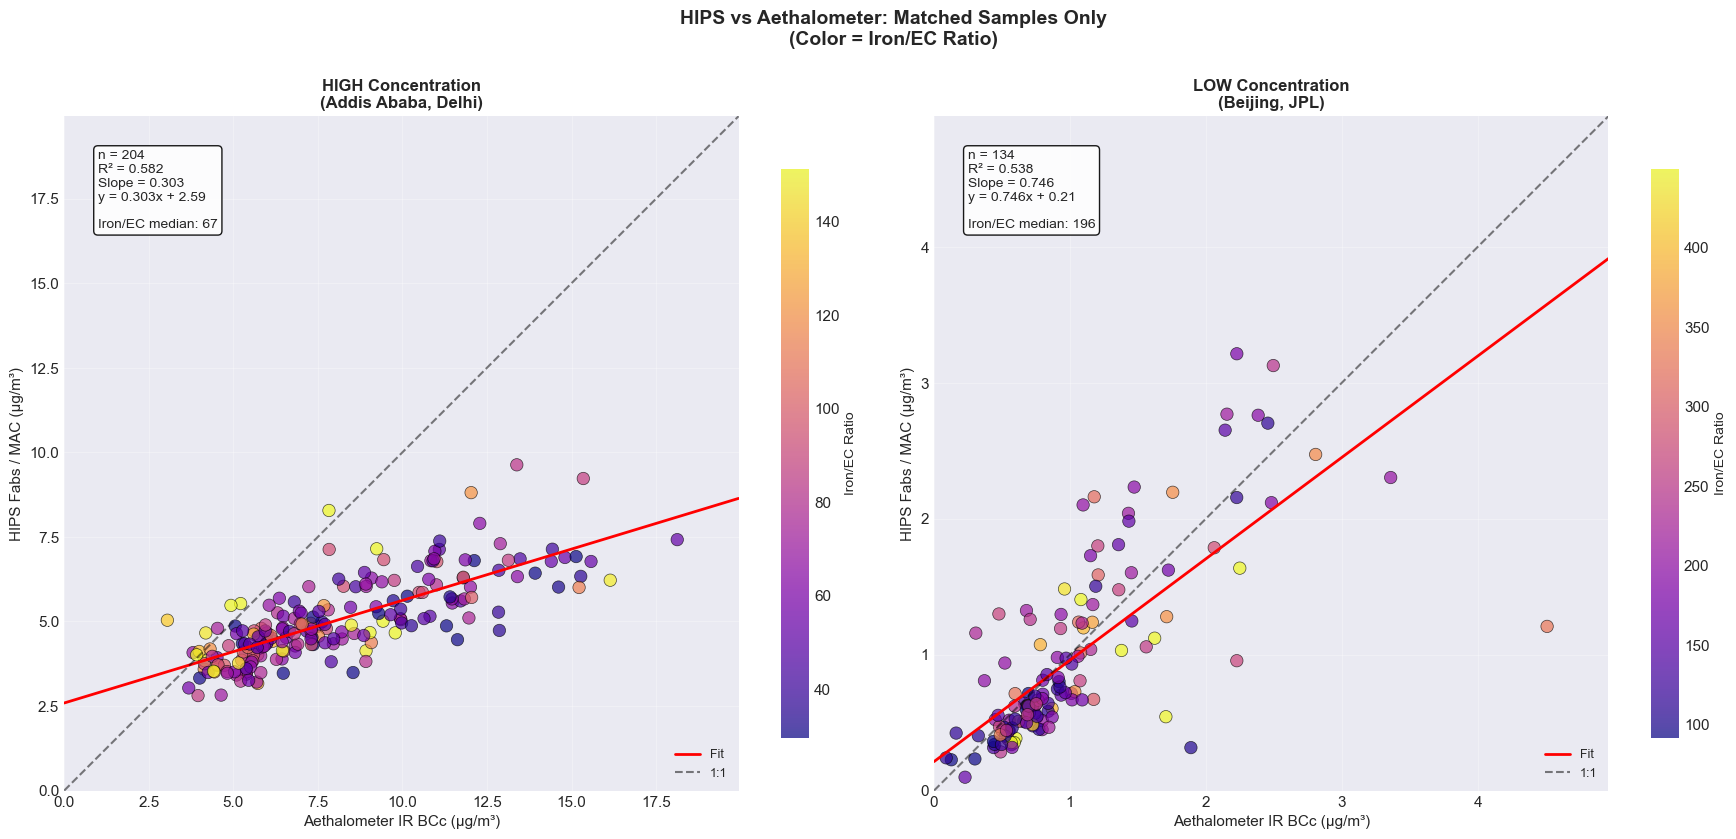


--- HIPS vs FTIR EC: Matched Samples Only (Iron/EC Ratio) ---


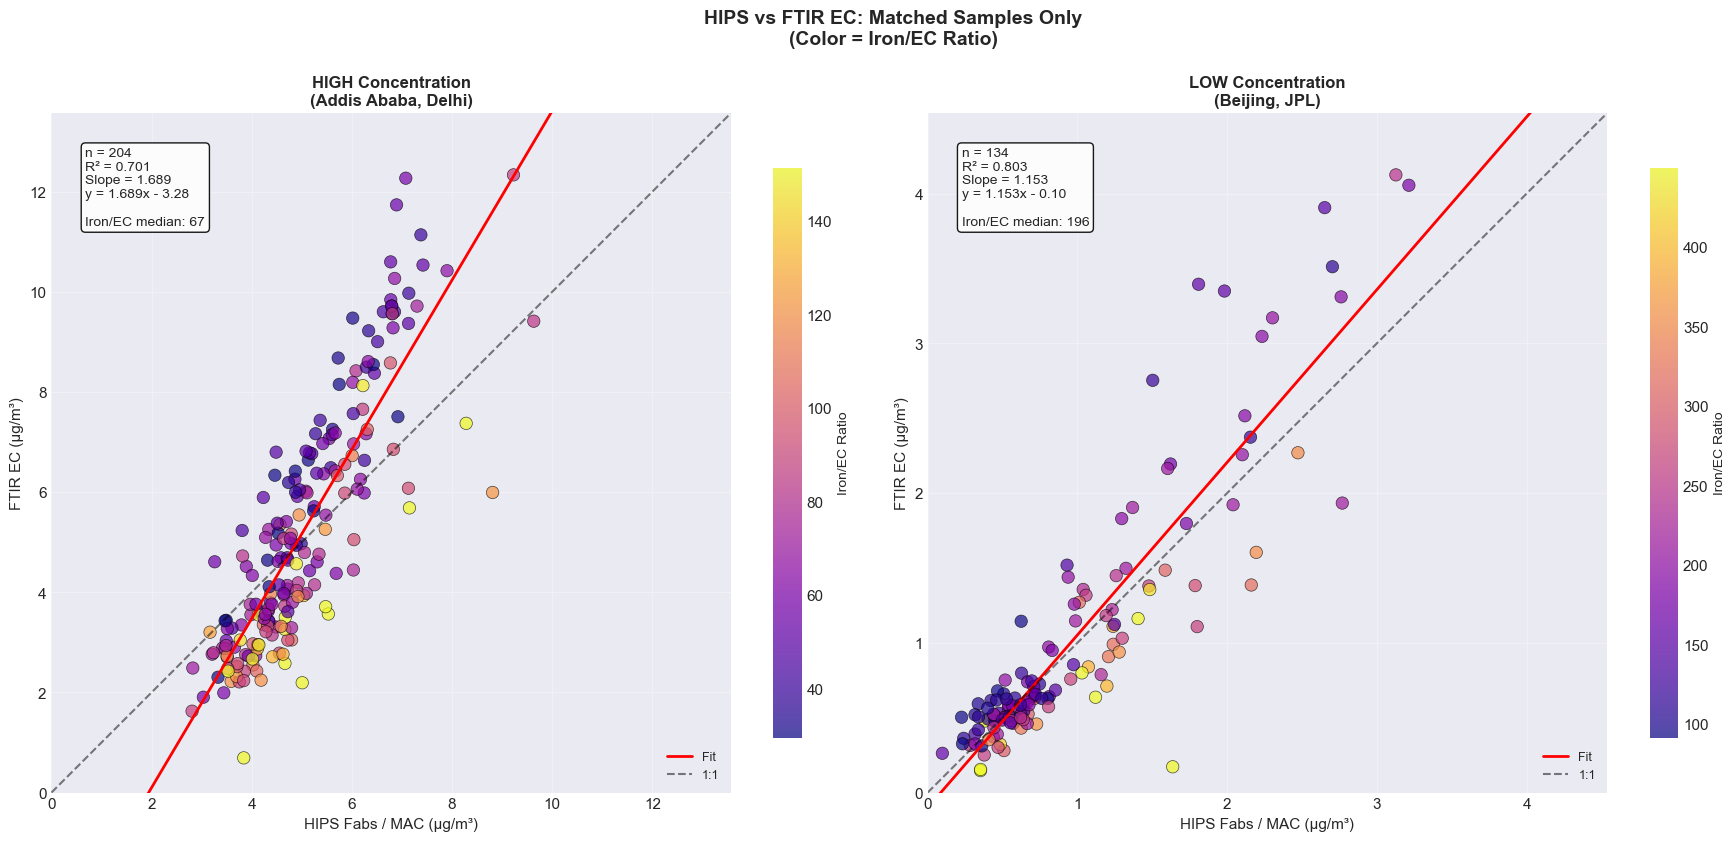

In [23]:
# Create matched-only datasets (where all 3 methods exist)
high_conc_matched = high_conc_data[
    high_conc_data['ir_bcc'].notna() & 
    high_conc_data['ftir_ec'].notna() & 
    high_conc_data['hips_fabs'].notna()
].copy()

low_conc_matched = low_conc_data[
    low_conc_data['ir_bcc'].notna() & 
    low_conc_data['ftir_ec'].notna() & 
    low_conc_data['hips_fabs'].notna()
].copy()

print(f"High concentration matched samples: {len(high_conc_matched)}")
print(f"Low concentration matched samples: {len(low_conc_matched)}")

# FTIR EC vs Aethalometer - MATCHED ONLY, colored by Iron/EC RATIO
print("\n--- FTIR EC vs Aethalometer: Matched Samples Only (Iron/EC Ratio) ---")
plot_grouped_comparison_ratio(
    high_conc_matched, low_conc_matched,
    x_col='ir_bcc', y_col='ftir_ec',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title_base='FTIR EC vs Aethalometer: Matched Samples Only'
)

# HIPS vs Aethalometer - MATCHED ONLY, colored by Iron/EC RATIO
print("\n--- HIPS vs Aethalometer: Matched Samples Only (Iron/EC Ratio) ---")
plot_grouped_comparison_ratio(
    high_conc_matched, low_conc_matched,
    x_col='ir_bcc', y_col='hips_fabs',
    xlabel='Aethalometer IR BCc (µg/m³)',
    ylabel='HIPS Fabs / MAC (µg/m³)',
    title_base='HIPS vs Aethalometer: Matched Samples Only'
)

# HIPS vs FTIR EC - MATCHED ONLY, colored by Iron/EC RATIO
print("\n--- HIPS vs FTIR EC: Matched Samples Only (Iron/EC Ratio) ---")
plot_grouped_comparison_ratio(
    high_conc_matched, low_conc_matched,
    x_col='hips_fabs', y_col='ftir_ec',
    xlabel='HIPS Fabs / MAC (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title_base='HIPS vs FTIR EC: Matched Samples Only'
)


--- HIPS vs FTIR EC: High vs Low Concentration Sites ---


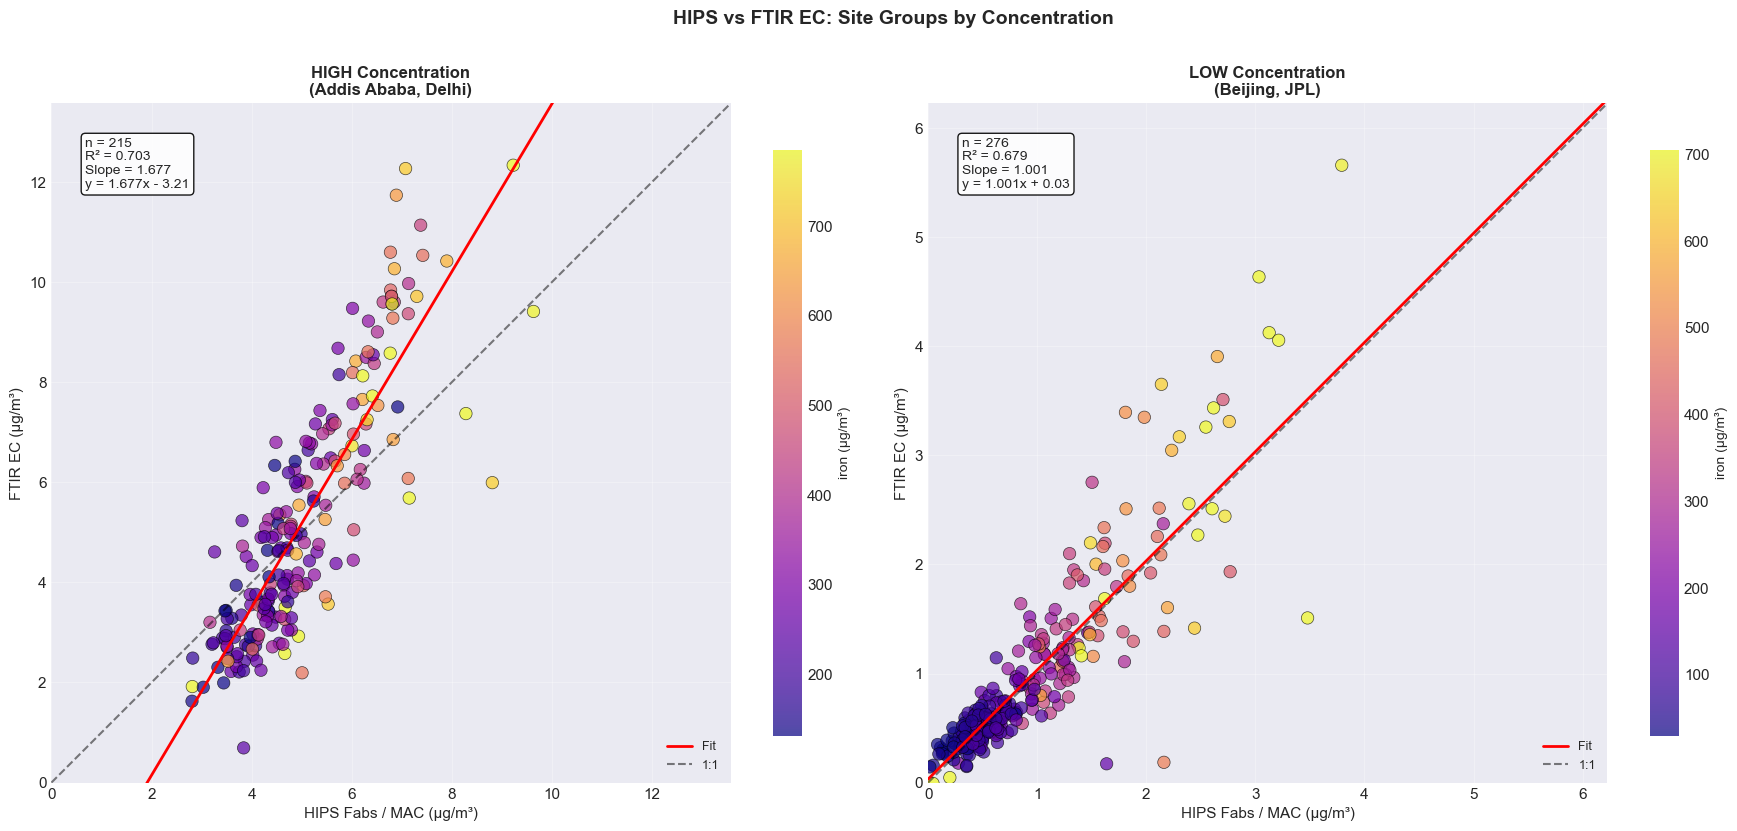

In [24]:
# HIPS vs FTIR EC - grouped by concentration
print("\n--- HIPS vs FTIR EC: High vs Low Concentration Sites ---")
plot_grouped_comparison(
    high_conc_data, low_conc_data,
    x_col='hips_fabs', y_col='ftir_ec',
    xlabel='HIPS Fabs / MAC (µg/m³)',
    ylabel='FTIR EC (µg/m³)',
    title_base='HIPS vs FTIR EC: Site Groups by Concentration',
    color_col='iron'
)

In [25]:
# Iron/EC Ratio Threshold Analysis - SEPARATED by site group
print("\n" + "="*80)
print("IRON/EC RATIO THRESHOLD ANALYSIS - BY SITE GROUP")
print("="*80)

IRON_EC_THRESHOLDS = [50, 100, 150, 200, 300]

def analyze_threshold_by_group(df, group_name, x_col, y_col, xlabel, ylabel):
    """Analyze iron/EC thresholds for a site group."""
    results = {}
    
    valid_mask = df[x_col].notna() & df[y_col].notna() & df['iron_ec_ratio'].notna()
    df_valid = df[valid_mask]
    
    if len(df_valid) < 5:
        print(f"  {group_name}: Insufficient data (n={len(df_valid)})")
        return None
    
    print(f"\n{group_name}:")
    print(f"  Total samples: {len(df_valid)}")
    print(f"  Iron/EC ratio range: {df_valid['iron_ec_ratio'].min():.1f} - {df_valid['iron_ec_ratio'].max():.1f}")
    
    print(f"\n  {'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s}")
    print("  " + "-" * 80)
    
    for threshold in IRON_EC_THRESHOLDS:
        low_mask = df_valid['iron_ec_ratio'] <= threshold
        high_mask = df_valid['iron_ec_ratio'] > threshold
        
        low_df = df_valid[low_mask]
        high_df = df_valid[high_mask]
        
        low_stats = {'n': len(low_df), 'r2': np.nan, 'slope': np.nan}
        high_stats = {'n': len(high_df), 'r2': np.nan, 'slope': np.nan}
        
        if len(low_df) >= 3:
            slope, _, r_value, _, _ = stats.linregress(low_df[x_col], low_df[y_col])
            low_stats['r2'] = r_value**2
            low_stats['slope'] = slope
        
        if len(high_df) >= 3:
            slope, _, r_value, _, _ = stats.linregress(high_df[x_col], high_df[y_col])
            high_stats['r2'] = r_value**2
            high_stats['slope'] = slope
        
        results[threshold] = {'low': low_stats, 'high': high_stats}
        
        print(f"  {threshold:<12d} {low_stats['n']:<8d} {low_stats['r2']:<10.3f} {low_stats['slope']:<12.3f} "
              f"{high_stats['n']:<8d} {high_stats['r2']:<10.3f} {high_stats['slope']:<12.3f}")
    
    return results

# Analyze both groups
print("\n--- FTIR EC vs Aethalometer ---")
high_results = analyze_threshold_by_group(high_conc_data, 'HIGH Concentration (Addis Ababa, Delhi)', 
                                          'ir_bcc', 'ftir_ec', 'Aeth BC', 'FTIR EC')
low_results = analyze_threshold_by_group(low_conc_data, 'LOW Concentration (Beijing, JPL)',
                                         'ir_bcc', 'ftir_ec', 'Aeth BC', 'FTIR EC')


IRON/EC RATIO THRESHOLD ANALYSIS - BY SITE GROUP

--- FTIR EC vs Aethalometer ---

HIGH Concentration (Addis Ababa, Delhi):
  Total samples: 204
  Iron/EC ratio range: -561.8 - 343.1

  Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope  
  --------------------------------------------------------------------------------
  50           50       0.627      0.636        154      0.734      0.681       
  100          166      0.767      0.722        38       0.552      0.408       
  150          193      0.750      0.688        11       0.130      0.276       
  200          199      0.749      0.687        5        0.400      0.228       
  300          202      0.735      0.683        2        nan        nan         

LOW Concentration (Beijing, JPL):
  Total samples: 134
  Iron/EC ratio range: 9.1 - 1176.7

  Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope  
  ----------------------------------------------------------------------

### Iron/EC Threshold Analysis with Visualizations - By Concentration Group

**Goal**: Perform detailed threshold analysis similar to the primary analysis notebook, but separated by:
- **High concentration sites**: Addis Ababa, Delhi
- **Low concentration sites**: Beijing, JPL

This helps identify if iron interference patterns differ between site groups.

In [26]:
# Iron/EC Threshold Analysis Function with Visualizations
def analyze_iron_threshold_visual(df, x_col, y_col, ratio_col, threshold, xlabel, ylabel, title_suffix=""):
    """
    Analyze data split by iron/EC ratio threshold with visualizations.
    Returns regression stats for low and high ratio groups.
    """
    # Filter to valid data
    valid_mask = df[x_col].notna() & df[y_col].notna() & df[ratio_col].notna()
    df_valid = df[valid_mask].copy()
    
    if len(df_valid) < 5:
        print(f"Insufficient data (n={len(df_valid)})")
        return None
    
    # Split by threshold
    low_ratio = df_valid[df_valid[ratio_col] <= threshold]
    high_ratio = df_valid[df_valid[ratio_col] > threshold]
    
    # Calculate axis limits
    all_vals = np.concatenate([df_valid[x_col].values, df_valid[y_col].values])
    max_val = np.nanmax(all_vals) * 1.05
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    results = {'threshold': threshold}
    
    # Left: Low Iron/EC ratio
    ax = axes[0]
    if len(low_ratio) >= 3:
        x_low = low_ratio[x_col].values
        y_low = low_ratio[y_col].values
        ax.scatter(x_low, y_low, c='blue', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        slope, intercept, r_value, _, _ = stats.linregress(x_low, y_low)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'b-', linewidth=2)
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
        
        results['low'] = {'n': len(x_low), 'r2': r_value**2, 'slope': slope, 'intercept': intercept}
        ax.text(0.05, 0.95, f"n={len(x_low)}\nR²={r_value**2:.3f}\nslope={slope:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))
    else:
        results['low'] = {'n': len(low_ratio), 'r2': np.nan, 'slope': np.nan}
        ax.text(0.5, 0.5, f'n={len(low_ratio)}\nInsufficient data', transform=ax.transAxes,
                ha='center', va='center', fontsize=12)
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(f'LOW Iron/EC (≤{threshold})\nn={len(low_ratio)}', fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Middle: High Iron/EC ratio
    ax = axes[1]
    if len(high_ratio) >= 3:
        x_high = high_ratio[x_col].values
        y_high = high_ratio[y_col].values
        ax.scatter(x_high, y_high, c='red', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        slope, intercept, r_value, _, _ = stats.linregress(x_high, y_high)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
        
        results['high'] = {'n': len(x_high), 'r2': r_value**2, 'slope': slope, 'intercept': intercept}
        ax.text(0.05, 0.95, f"n={len(x_high)}\nR²={r_value**2:.3f}\nslope={slope:.3f}",
                transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.9))
    else:
        results['high'] = {'n': len(high_ratio), 'r2': np.nan, 'slope': np.nan}
        ax.text(0.5, 0.5, f'n={len(high_ratio)}\nInsufficient data', transform=ax.transAxes,
                ha='center', va='center', fontsize=12)
    
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(f'HIGH Iron/EC (>{threshold})\nn={len(high_ratio)}', fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.3)
    
    # Right: Residual vs Iron/EC ratio
    ax = axes[2]
    residual = df_valid[y_col] - df_valid[x_col]
    ax.scatter(df_valid[ratio_col], residual, c='gray', alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={threshold}')
    
    # Correlation
    corr, p_val = stats.pearsonr(df_valid[ratio_col], residual)
    ax.text(0.05, 0.95, f"Pearson r={corr:.3f}\np={p_val:.3e}",
            transform=ax.transAxes, fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    results['residual_corr'] = corr
    results['residual_p'] = p_val
    
    ax.set_xlabel('Iron/EC Ratio', fontsize=10)
    ax.set_ylabel(f'Residual ({ylabel.split(" ")[0]} - {xlabel.split(" ")[0]})', fontsize=10)
    ax.set_title('Residual vs Iron/EC Ratio', fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Iron/EC Threshold = {threshold}{title_suffix}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return results

print("Threshold analysis function defined.")

Threshold analysis function defined.



HIGH CONCENTRATION SITES (Delhi, Addis Ababa)
Iron/EC Threshold Analysis: Aethalometer BC vs FTIR EC

Iron/EC Ratio Statistics:
  n = 215
  Mean: 77.6
  Median: 67.2
  Range: -561.8 - 416.6
  Percentiles: 25th=49.8, 75th=91.9

--- Threshold: 50 ---


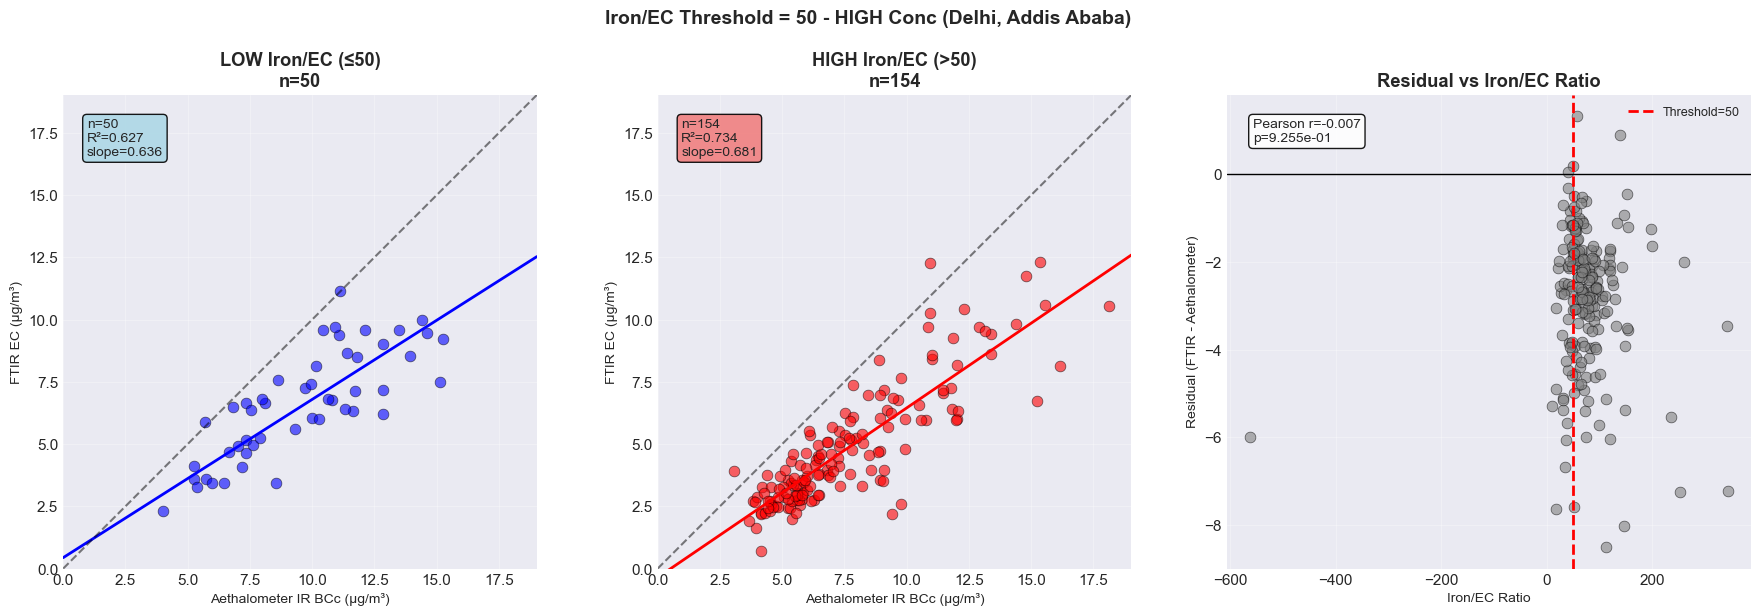


--- Threshold: 100 ---


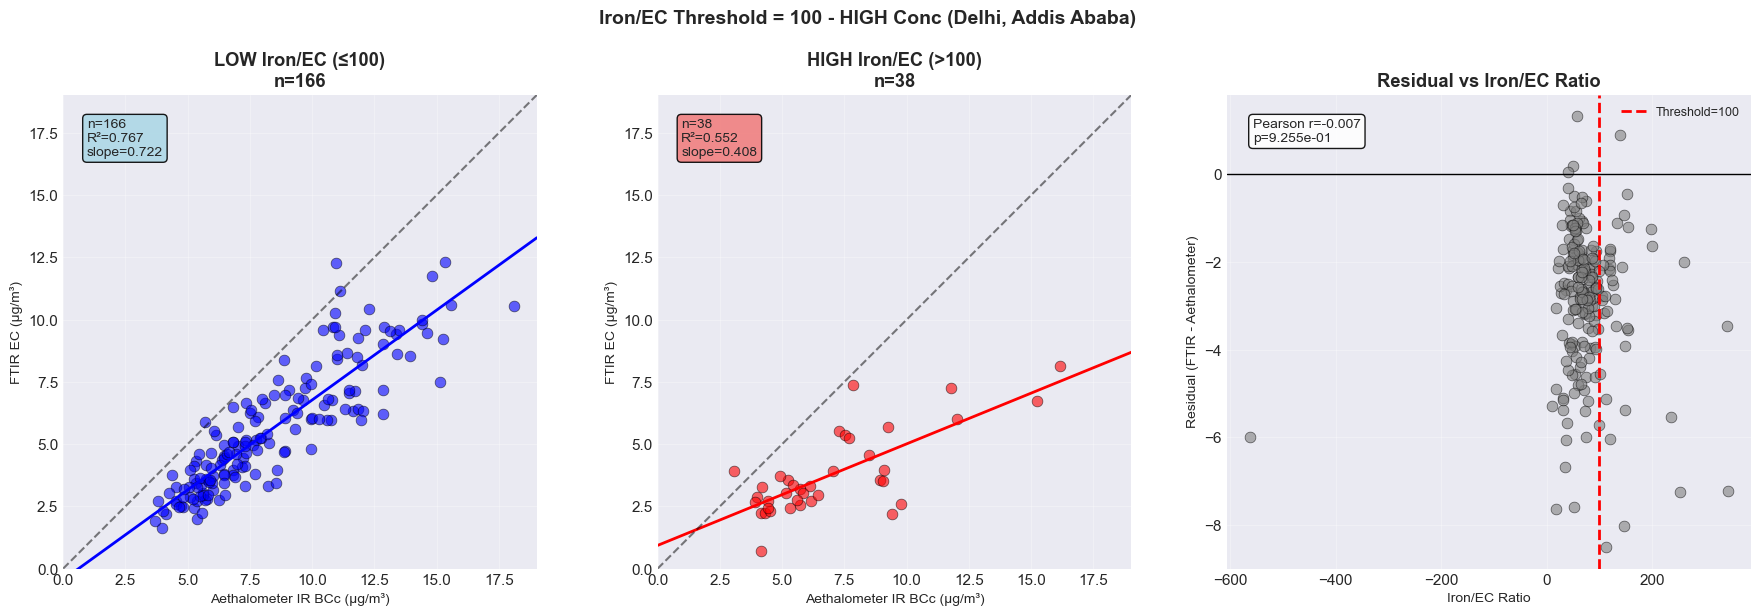


--- Threshold: 150 ---


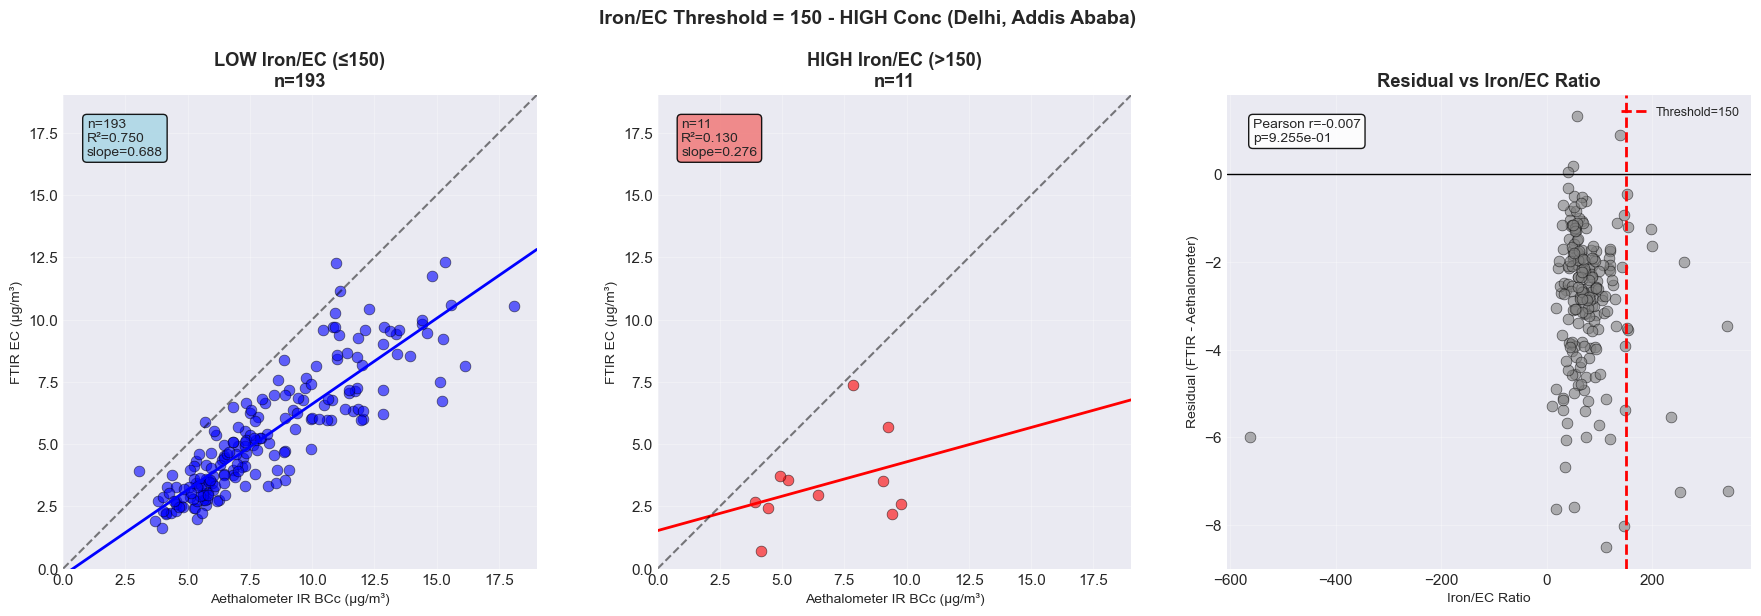


--- Threshold: 200 ---


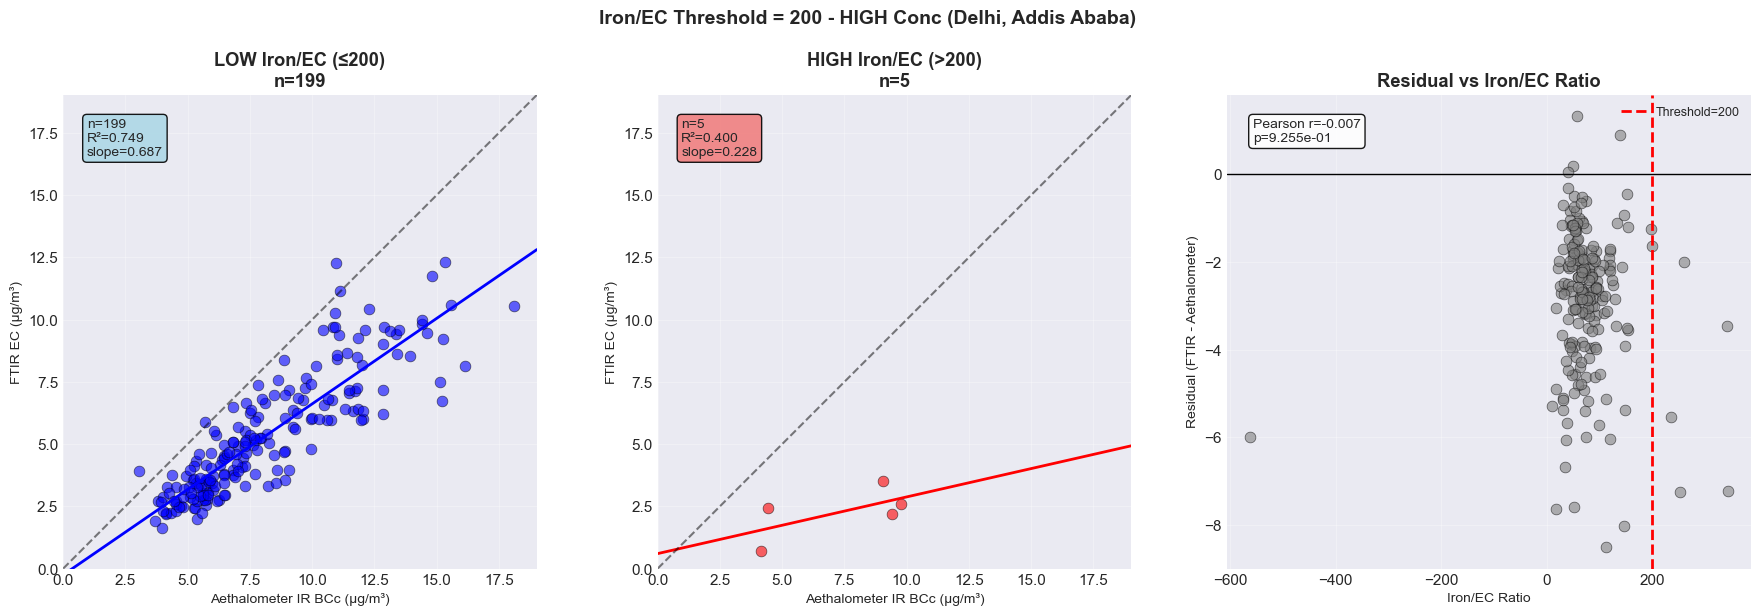


--- Threshold: 300 ---


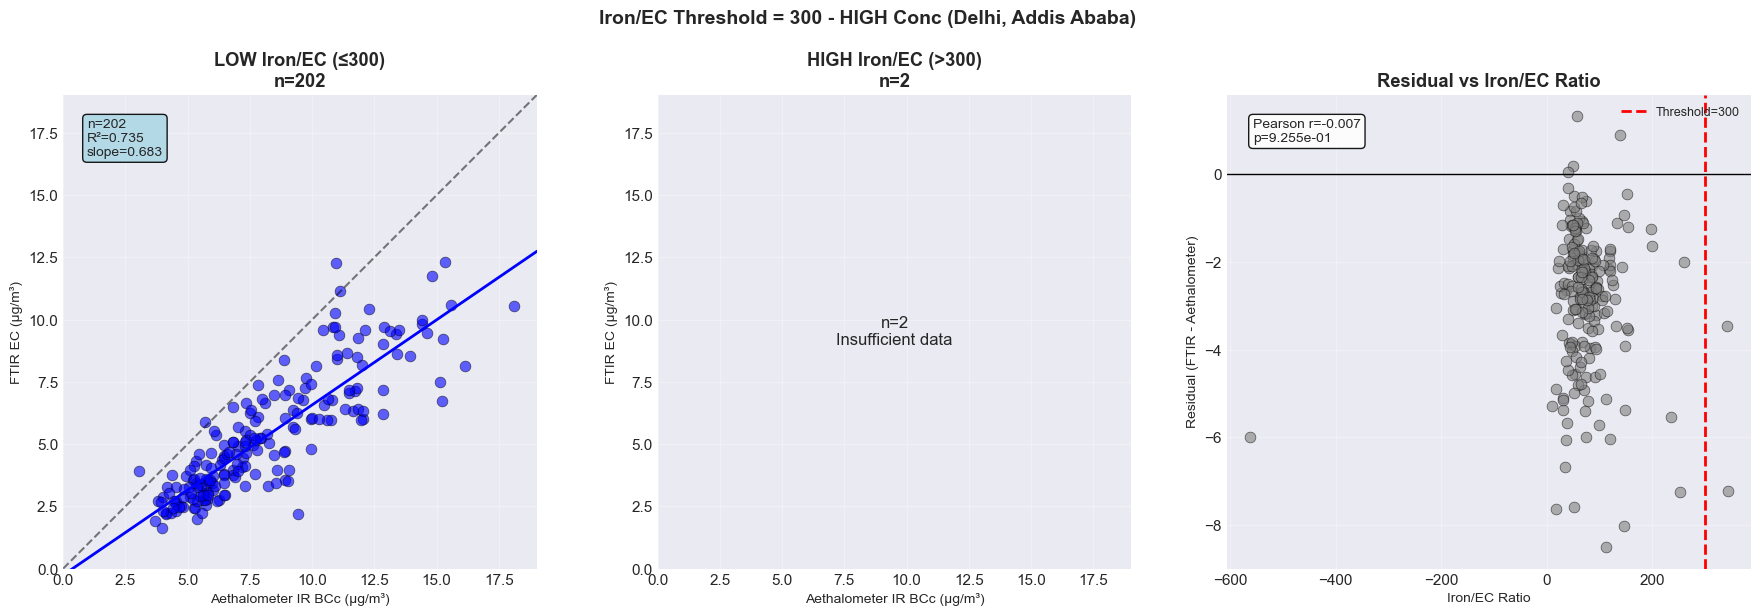


SUMMARY: HIGH Concentration Sites - Aeth BC vs FTIR EC
Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope   ΔR²       
------------------------------------------------------------------------------------------
50           50       0.627      0.636        154      0.734      0.681        -0.106    
100          166      0.767      0.722        38       0.552      0.408        +0.215    
150          193      0.750      0.688        11       0.130      0.276        +0.621    
200          199      0.749      0.687        5        0.400      0.228        +0.349    
300          202      0.735      0.683        2        nan        nan          +nan      


In [27]:
# HIGH CONCENTRATION SITES (Delhi, Addis Ababa) - Aethalometer vs FTIR EC Threshold Analysis
print("\n" + "="*80)
print("HIGH CONCENTRATION SITES (Delhi, Addis Ababa)")
print("Iron/EC Threshold Analysis: Aethalometer BC vs FTIR EC")
print("="*80)

# Iron/EC ratio statistics for high concentration sites
valid_ratio_high = high_conc_data['iron_ec_ratio'].dropna()
print(f"\nIron/EC Ratio Statistics:")
print(f"  n = {len(valid_ratio_high)}")
print(f"  Mean: {valid_ratio_high.mean():.1f}")
print(f"  Median: {valid_ratio_high.median():.1f}")
print(f"  Range: {valid_ratio_high.min():.1f} - {valid_ratio_high.max():.1f}")
print(f"  Percentiles: 25th={valid_ratio_high.quantile(0.25):.1f}, 75th={valid_ratio_high.quantile(0.75):.1f}")

# Test multiple thresholds
threshold_results_high_aeth = {}

for threshold in IRON_EC_THRESHOLDS:
    print(f"\n--- Threshold: {threshold} ---")
    results = analyze_iron_threshold_visual(
        high_conc_data,
        x_col='ir_bcc',
        y_col='ftir_ec',
        ratio_col='iron_ec_ratio',
        threshold=threshold,
        xlabel='Aethalometer IR BCc (µg/m³)',
        ylabel='FTIR EC (µg/m³)',
        title_suffix=' - HIGH Conc (Delhi, Addis Ababa)'
    )
    if results:
        threshold_results_high_aeth[threshold] = results

# Summary table
print("\n" + "="*80)
print("SUMMARY: HIGH Concentration Sites - Aeth BC vs FTIR EC")
print("="*80)
print(f"{'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s} {'ΔR²':<10s}")
print("-" * 90)

for threshold, results in threshold_results_high_aeth.items():
    low = results.get('low', {})
    high = results.get('high', {})
    
    low_r2 = low.get('r2', np.nan)
    high_r2 = high.get('r2', np.nan)
    delta_r2 = low_r2 - high_r2 if not (np.isnan(low_r2) or np.isnan(high_r2)) else np.nan
    
    print(f"{threshold:<12d} {low.get('n', 0):<8d} {low_r2:<10.3f} {low.get('slope', np.nan):<12.3f} "
          f"{high.get('n', 0):<8d} {high_r2:<10.3f} {high.get('slope', np.nan):<12.3f} {delta_r2:<+10.3f}")


HIGH CONCENTRATION SITES (Delhi, Addis Ababa)
Iron/EC Threshold Analysis: HIPS vs FTIR EC

--- Threshold: 50 ---


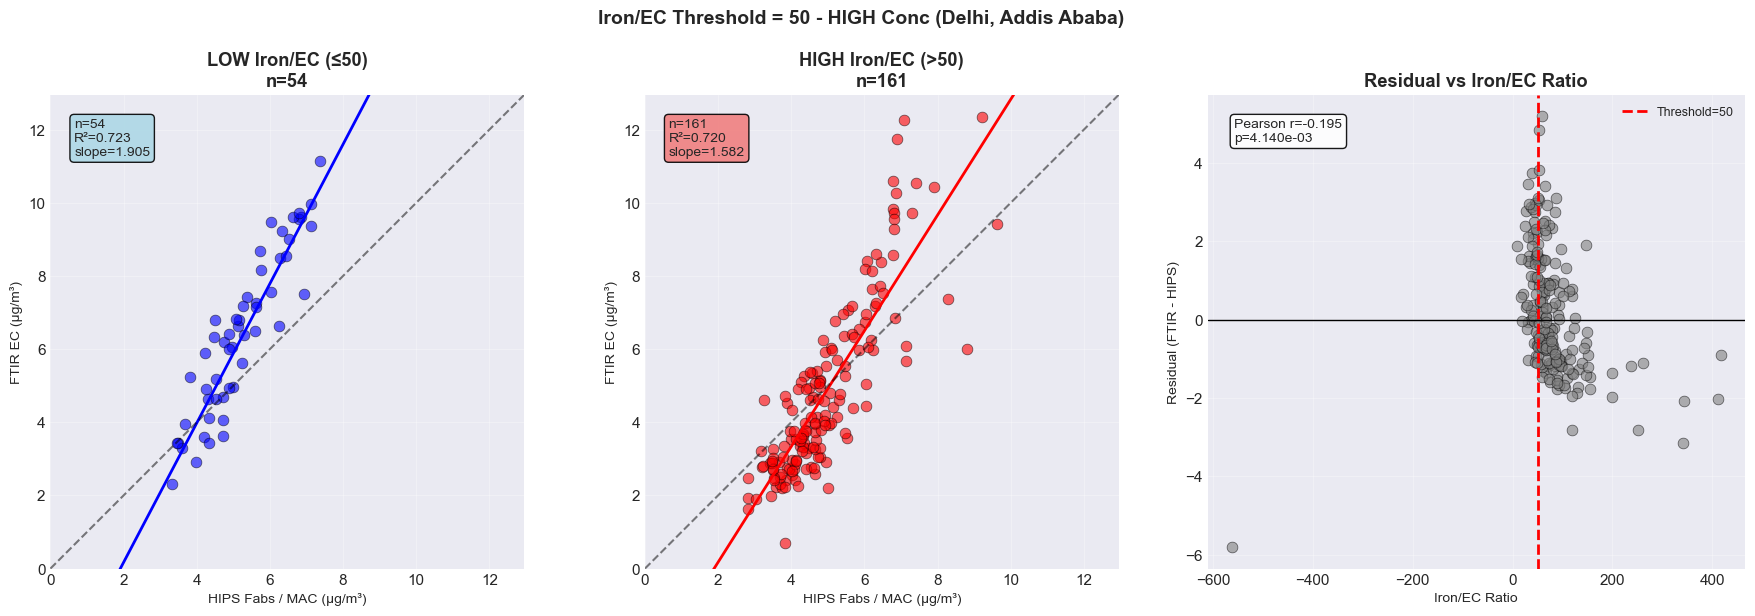


--- Threshold: 100 ---


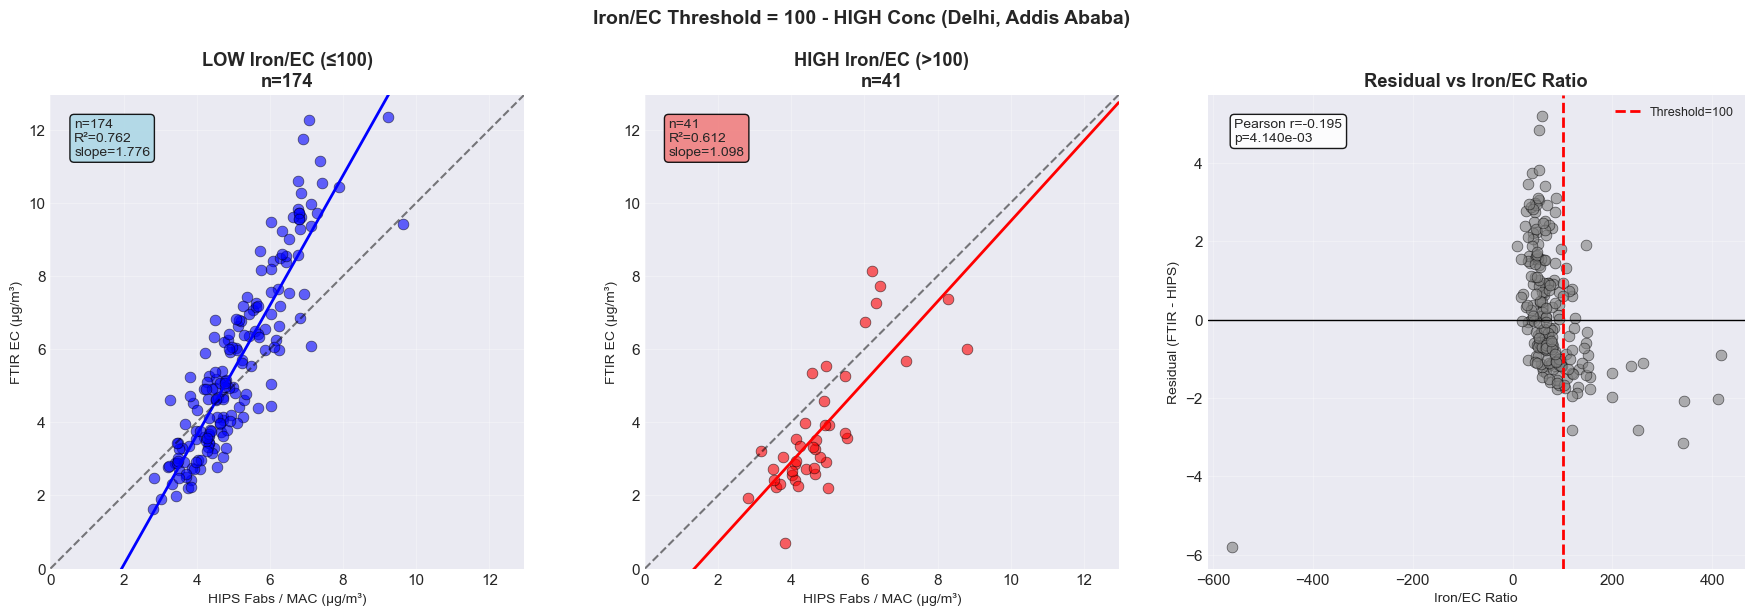


--- Threshold: 150 ---


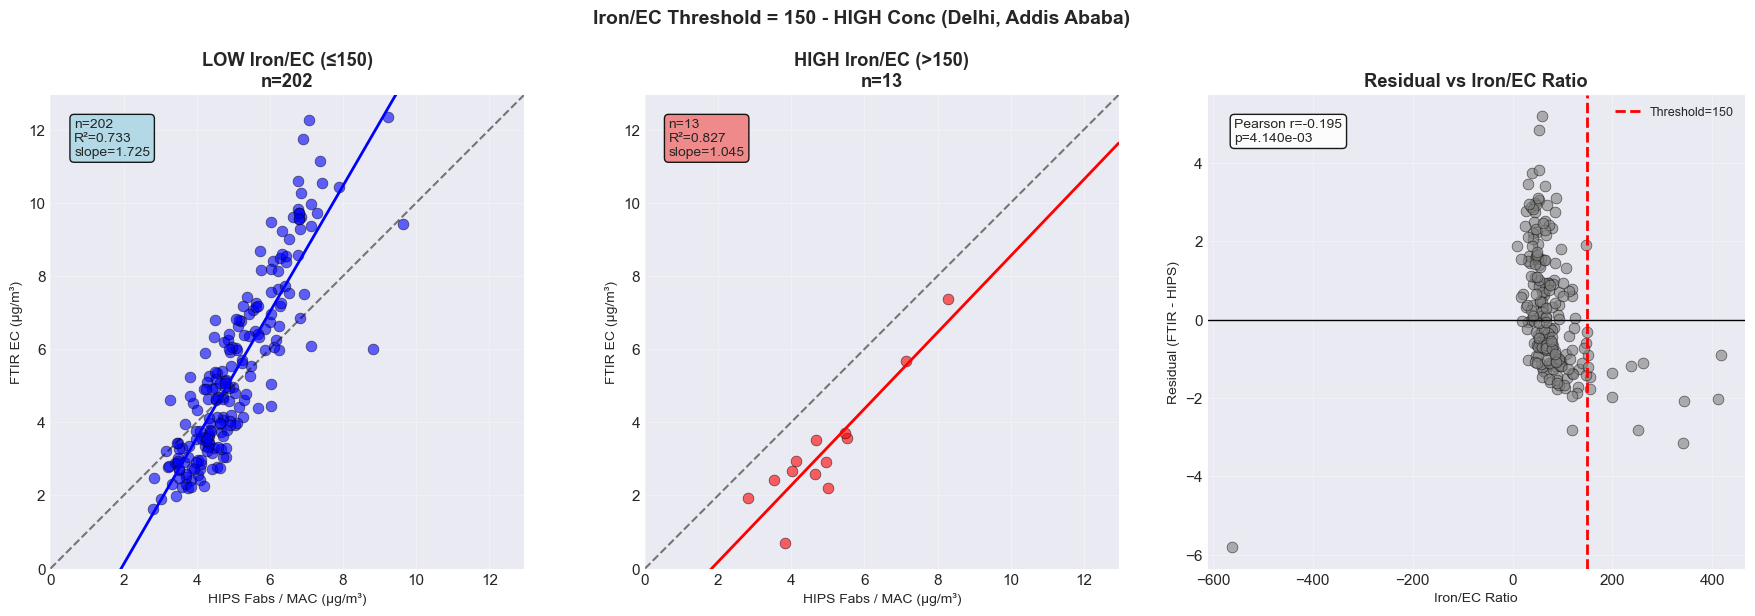


--- Threshold: 200 ---


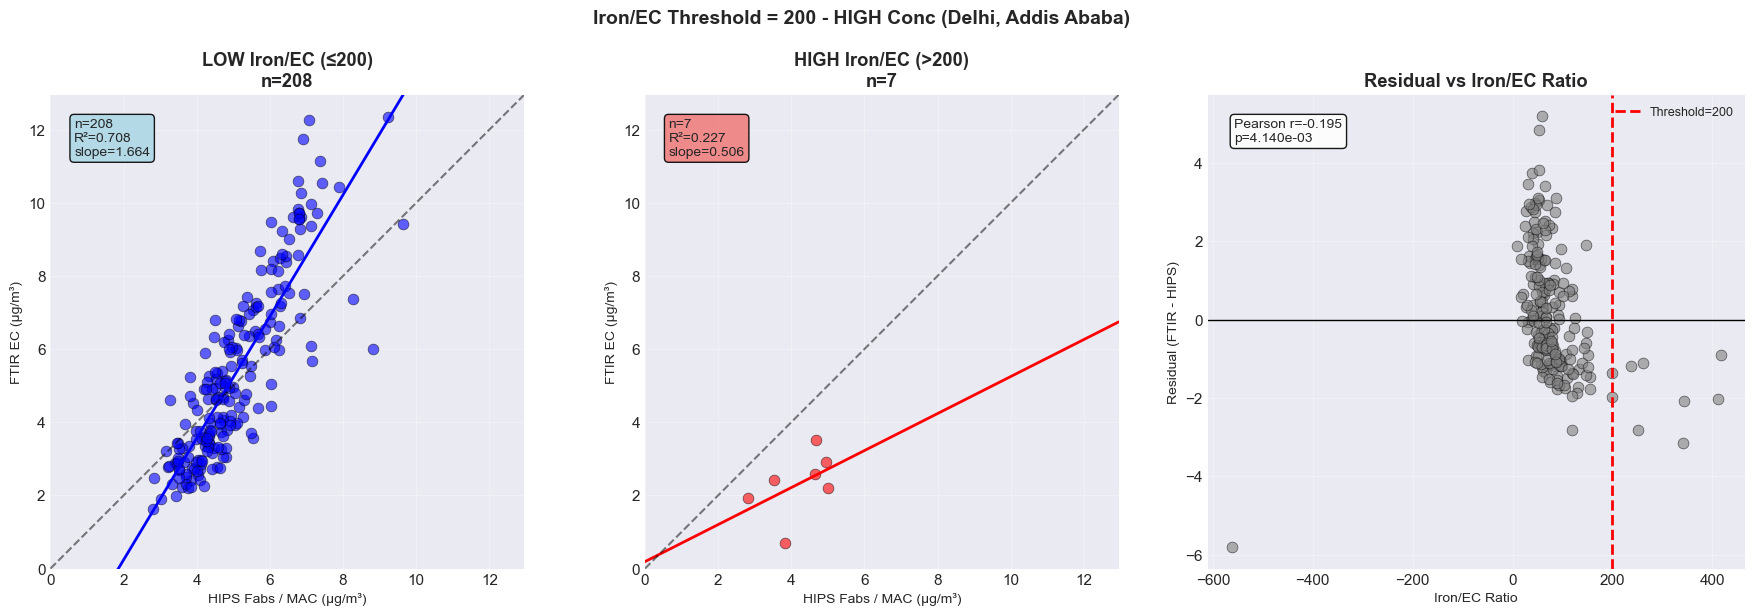


--- Threshold: 300 ---


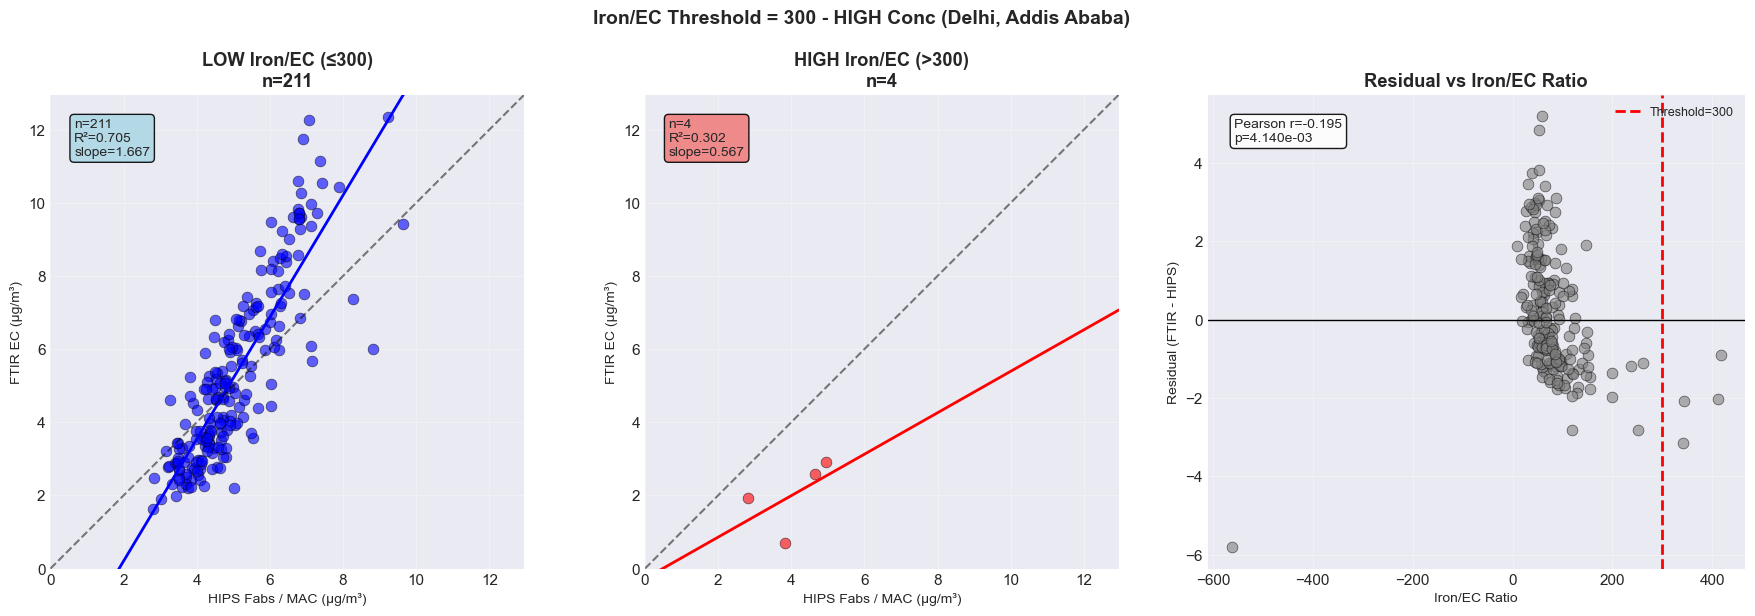


SUMMARY: HIGH Concentration Sites - HIPS vs FTIR EC
Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope   ΔR²       
------------------------------------------------------------------------------------------
50           54       0.723      1.905        161      0.720      1.582        +0.004    
100          174      0.762      1.776        41       0.612      1.098        +0.150    
150          202      0.733      1.725        13       0.827      1.045        -0.094    
200          208      0.708      1.664        7        0.227      0.506        +0.482    
300          211      0.705      1.667        4        0.302      0.567        +0.402    


In [28]:
# HIGH CONCENTRATION SITES (Delhi, Addis Ababa) - HIPS vs FTIR EC Threshold Analysis
print("\n" + "="*80)
print("HIGH CONCENTRATION SITES (Delhi, Addis Ababa)")
print("Iron/EC Threshold Analysis: HIPS vs FTIR EC")
print("="*80)

threshold_results_high_hips = {}

for threshold in IRON_EC_THRESHOLDS:
    print(f"\n--- Threshold: {threshold} ---")
    results = analyze_iron_threshold_visual(
        high_conc_data,
        x_col='hips_fabs',
        y_col='ftir_ec',
        ratio_col='iron_ec_ratio',
        threshold=threshold,
        xlabel='HIPS Fabs / MAC (µg/m³)',
        ylabel='FTIR EC (µg/m³)',
        title_suffix=' - HIGH Conc (Delhi, Addis Ababa)'
    )
    if results:
        threshold_results_high_hips[threshold] = results

# Summary table
print("\n" + "="*80)
print("SUMMARY: HIGH Concentration Sites - HIPS vs FTIR EC")
print("="*80)
print(f"{'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s} {'ΔR²':<10s}")
print("-" * 90)

for threshold, results in threshold_results_high_hips.items():
    low = results.get('low', {})
    high = results.get('high', {})
    
    low_r2 = low.get('r2', np.nan)
    high_r2 = high.get('r2', np.nan)
    delta_r2 = low_r2 - high_r2 if not (np.isnan(low_r2) or np.isnan(high_r2)) else np.nan
    
    print(f"{threshold:<12d} {low.get('n', 0):<8d} {low_r2:<10.3f} {low.get('slope', np.nan):<12.3f} "
          f"{high.get('n', 0):<8d} {high_r2:<10.3f} {high.get('slope', np.nan):<12.3f} {delta_r2:<+10.3f}")


LOW CONCENTRATION SITES (Beijing, JPL)
Iron/EC Threshold Analysis: Aethalometer BC vs FTIR EC

Iron/EC Ratio Statistics:
  n = 327
  Mean: -14.9
  Median: 211.0
  Range: -130343.7 - 40175.1
  Percentiles: 25th=144.9, 75th=297.0

--- Threshold: 50 ---


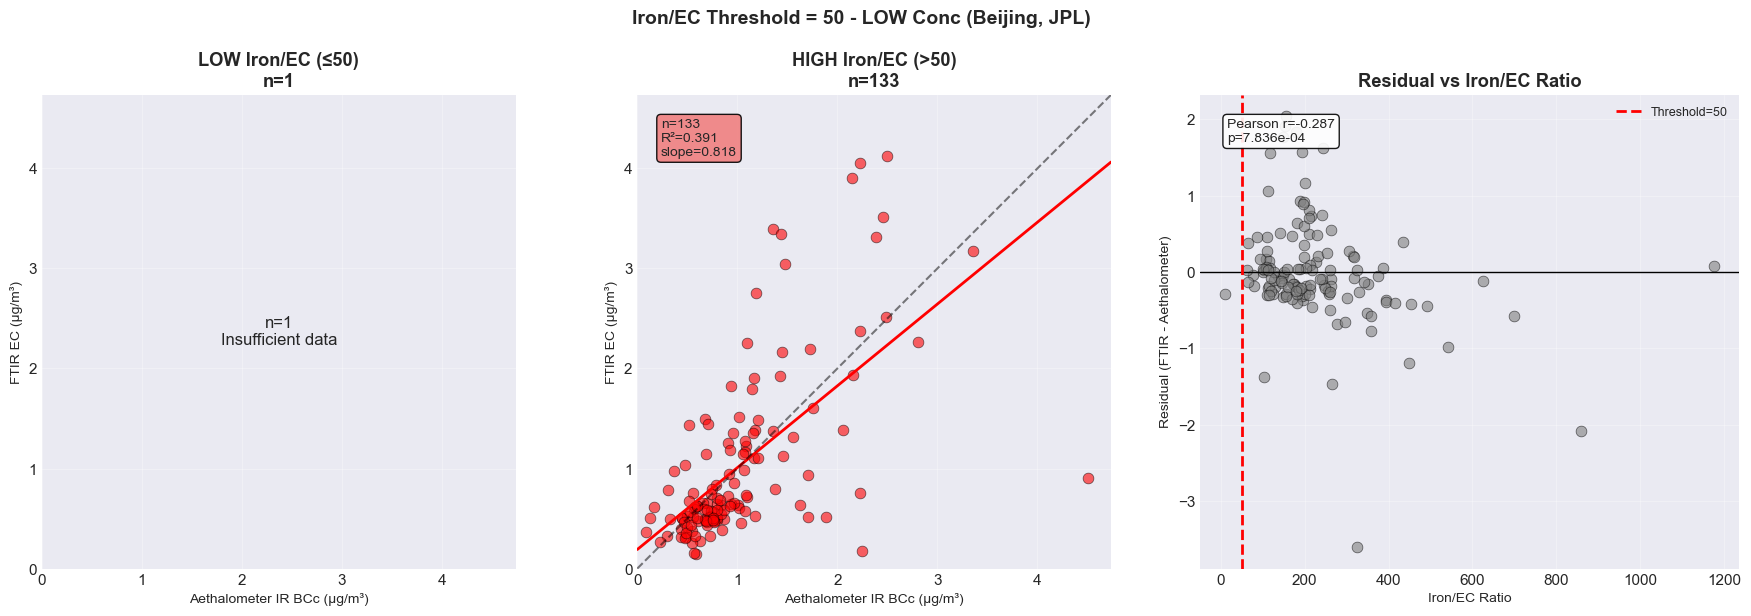


--- Threshold: 100 ---


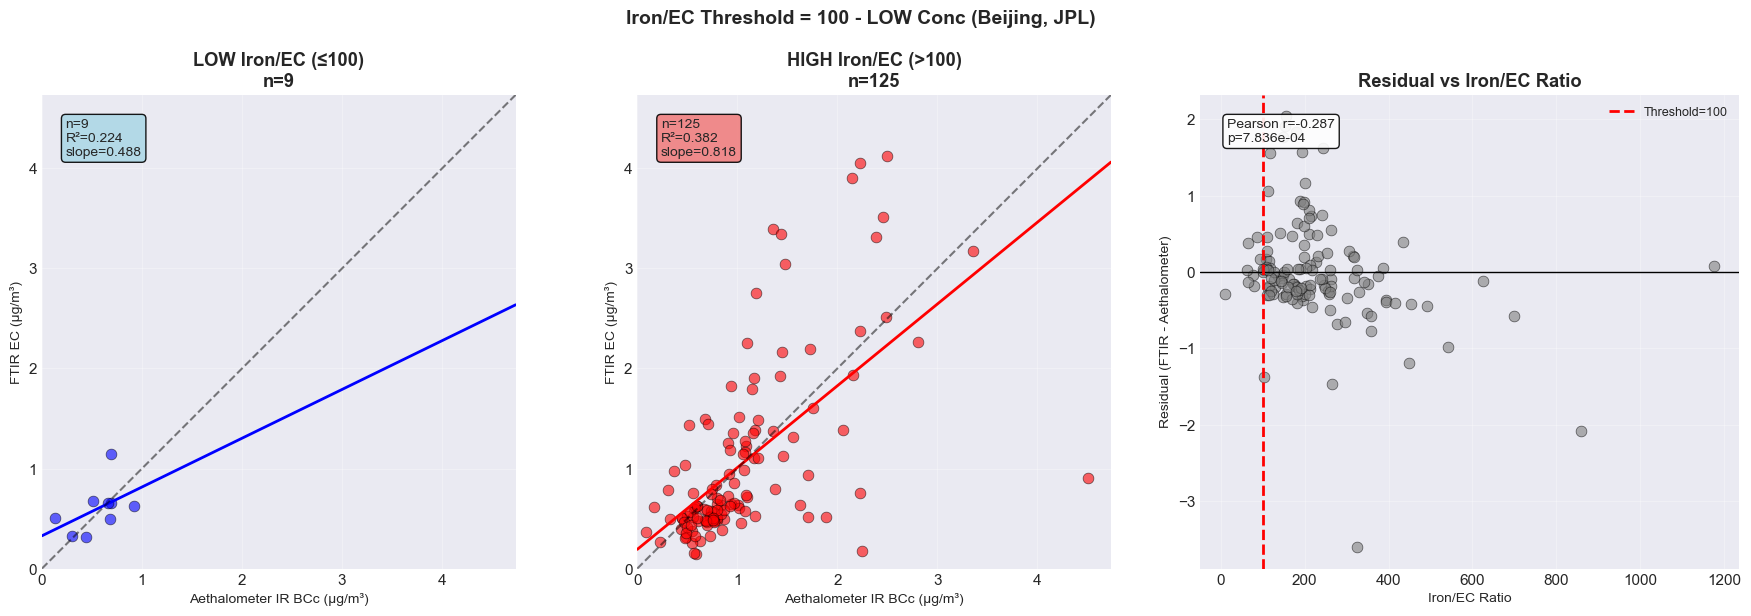


--- Threshold: 150 ---


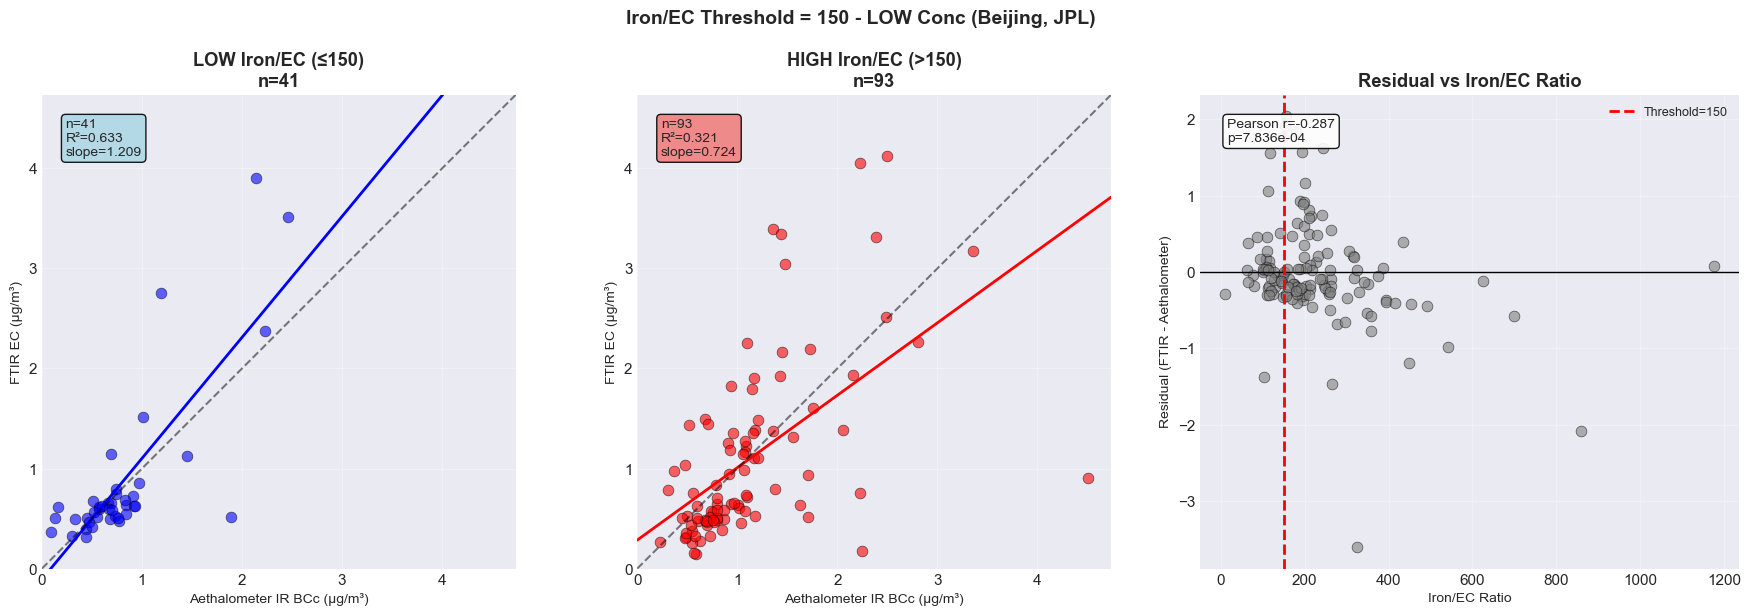


--- Threshold: 200 ---


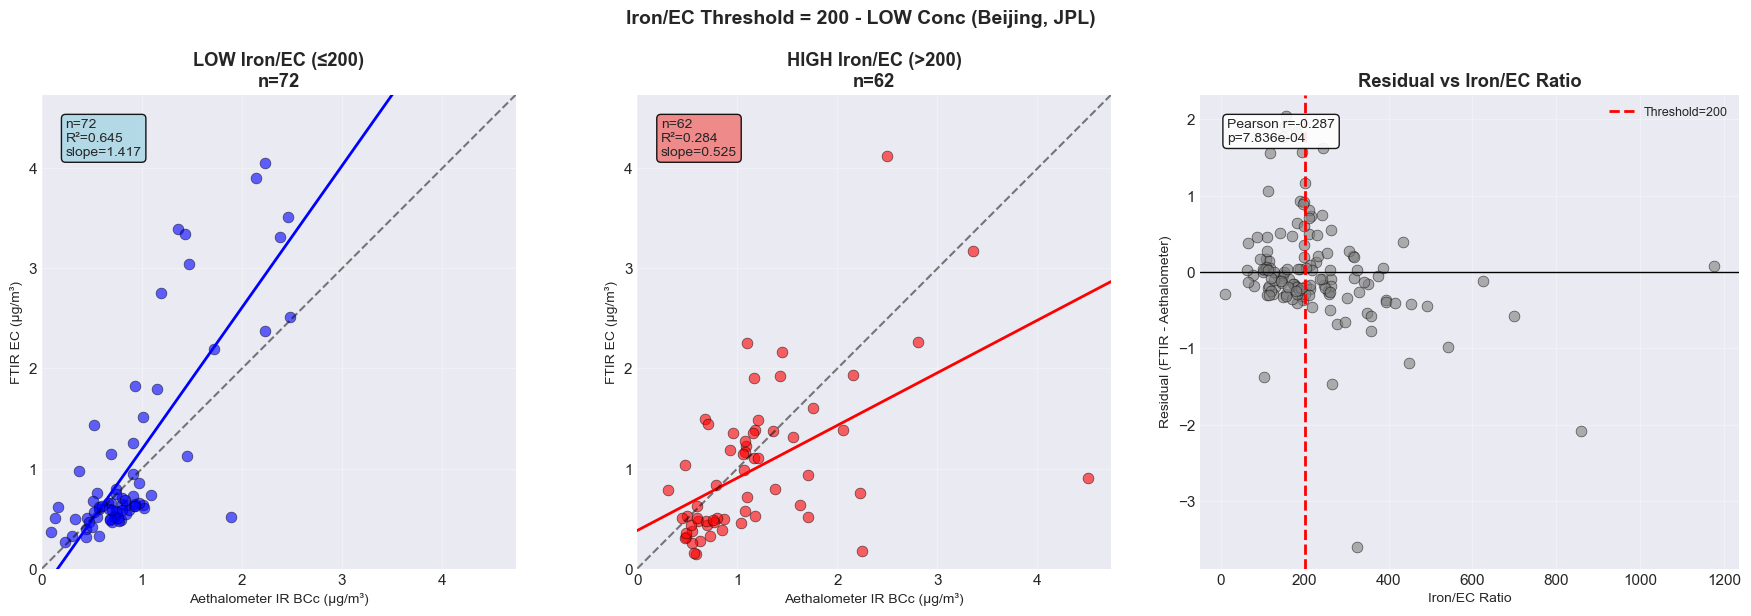


--- Threshold: 300 ---


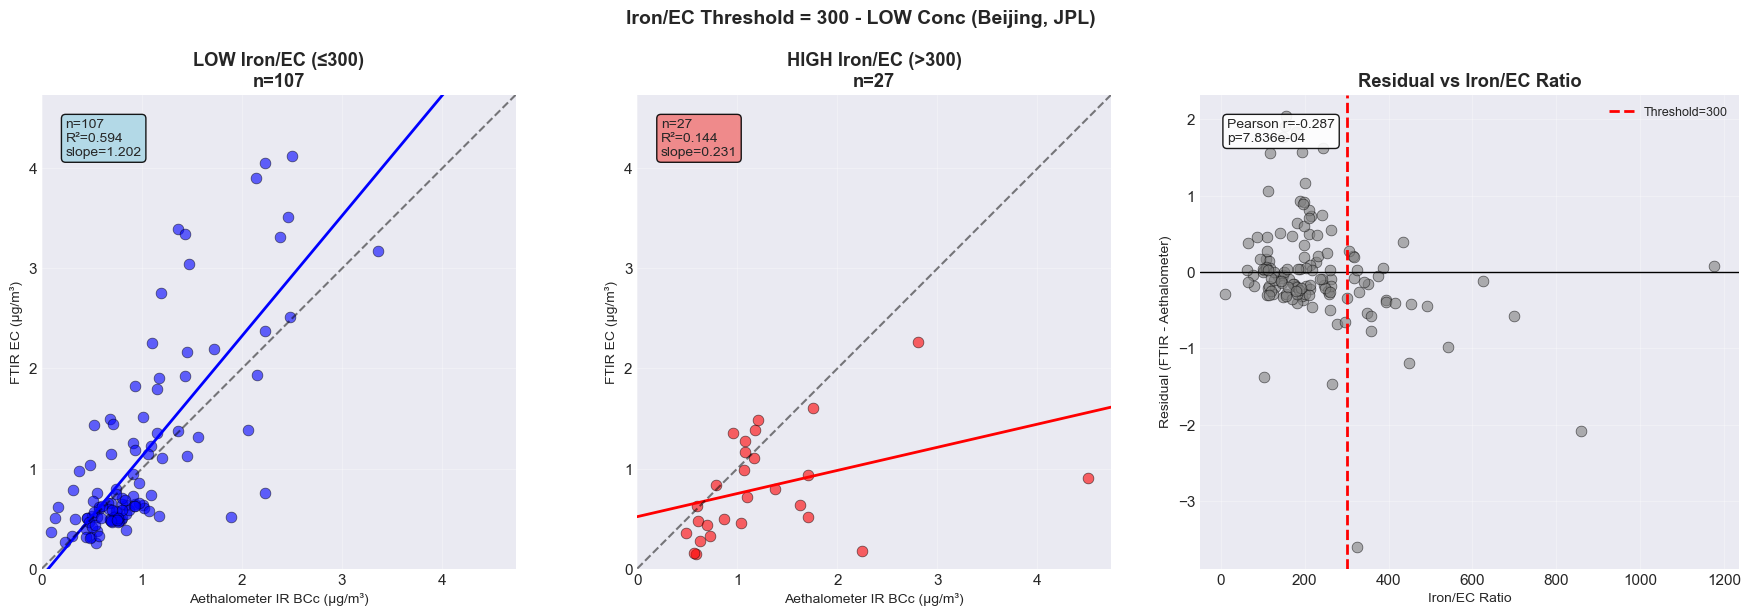


SUMMARY: LOW Concentration Sites - Aeth BC vs FTIR EC
Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope   ΔR²       
------------------------------------------------------------------------------------------
50           1        nan        nan          133      0.391      0.818        +nan      
100          9        0.224      0.488        125      0.382      0.818        -0.158    
150          41       0.633      1.209        93       0.321      0.724        +0.313    
200          72       0.645      1.417        62       0.284      0.525        +0.361    
300          107      0.594      1.202        27       0.144      0.231        +0.450    


In [29]:
# LOW CONCENTRATION SITES (Beijing, JPL) - Aethalometer vs FTIR EC Threshold Analysis
print("\n" + "="*80)
print("LOW CONCENTRATION SITES (Beijing, JPL)")
print("Iron/EC Threshold Analysis: Aethalometer BC vs FTIR EC")
print("="*80)

# Iron/EC ratio statistics for low concentration sites
valid_ratio_low = low_conc_data['iron_ec_ratio'].dropna()
print(f"\nIron/EC Ratio Statistics:")
print(f"  n = {len(valid_ratio_low)}")
print(f"  Mean: {valid_ratio_low.mean():.1f}")
print(f"  Median: {valid_ratio_low.median():.1f}")
print(f"  Range: {valid_ratio_low.min():.1f} - {valid_ratio_low.max():.1f}")
print(f"  Percentiles: 25th={valid_ratio_low.quantile(0.25):.1f}, 75th={valid_ratio_low.quantile(0.75):.1f}")

# Test multiple thresholds
threshold_results_low_aeth = {}

for threshold in IRON_EC_THRESHOLDS:
    print(f"\n--- Threshold: {threshold} ---")
    results = analyze_iron_threshold_visual(
        low_conc_data,
        x_col='ir_bcc',
        y_col='ftir_ec',
        ratio_col='iron_ec_ratio',
        threshold=threshold,
        xlabel='Aethalometer IR BCc (µg/m³)',
        ylabel='FTIR EC (µg/m³)',
        title_suffix=' - LOW Conc (Beijing, JPL)'
    )
    if results:
        threshold_results_low_aeth[threshold] = results

# Summary table
print("\n" + "="*80)
print("SUMMARY: LOW Concentration Sites - Aeth BC vs FTIR EC")
print("="*80)
print(f"{'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s} {'ΔR²':<10s}")
print("-" * 90)

for threshold, results in threshold_results_low_aeth.items():
    low = results.get('low', {})
    high = results.get('high', {})
    
    low_r2 = low.get('r2', np.nan)
    high_r2 = high.get('r2', np.nan)
    delta_r2 = low_r2 - high_r2 if not (np.isnan(low_r2) or np.isnan(high_r2)) else np.nan
    
    print(f"{threshold:<12d} {low.get('n', 0):<8d} {low_r2:<10.3f} {low.get('slope', np.nan):<12.3f} "
          f"{high.get('n', 0):<8d} {high_r2:<10.3f} {high.get('slope', np.nan):<12.3f} {delta_r2:<+10.3f}")


LOW CONCENTRATION SITES (Beijing, JPL)
Iron/EC Threshold Analysis: HIPS vs FTIR EC

--- Threshold: 50 ---


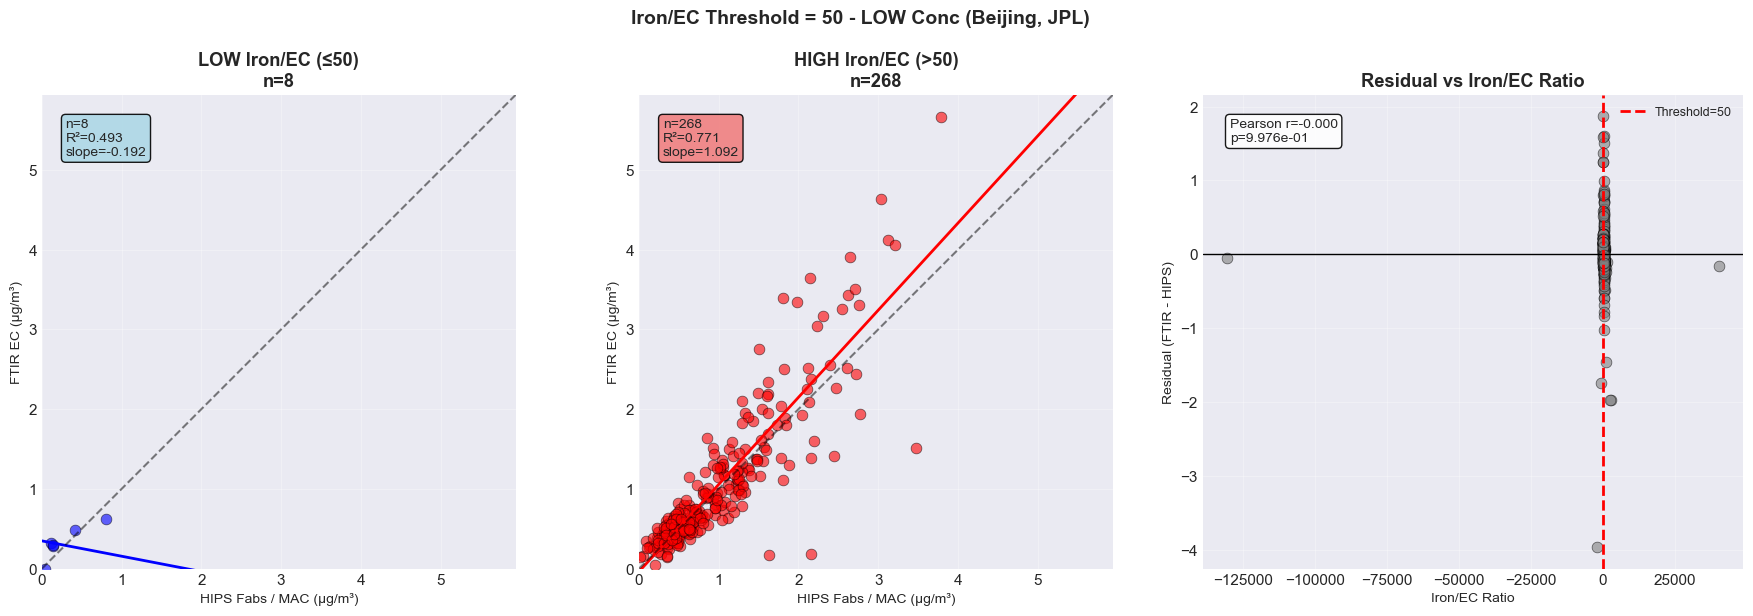


--- Threshold: 100 ---


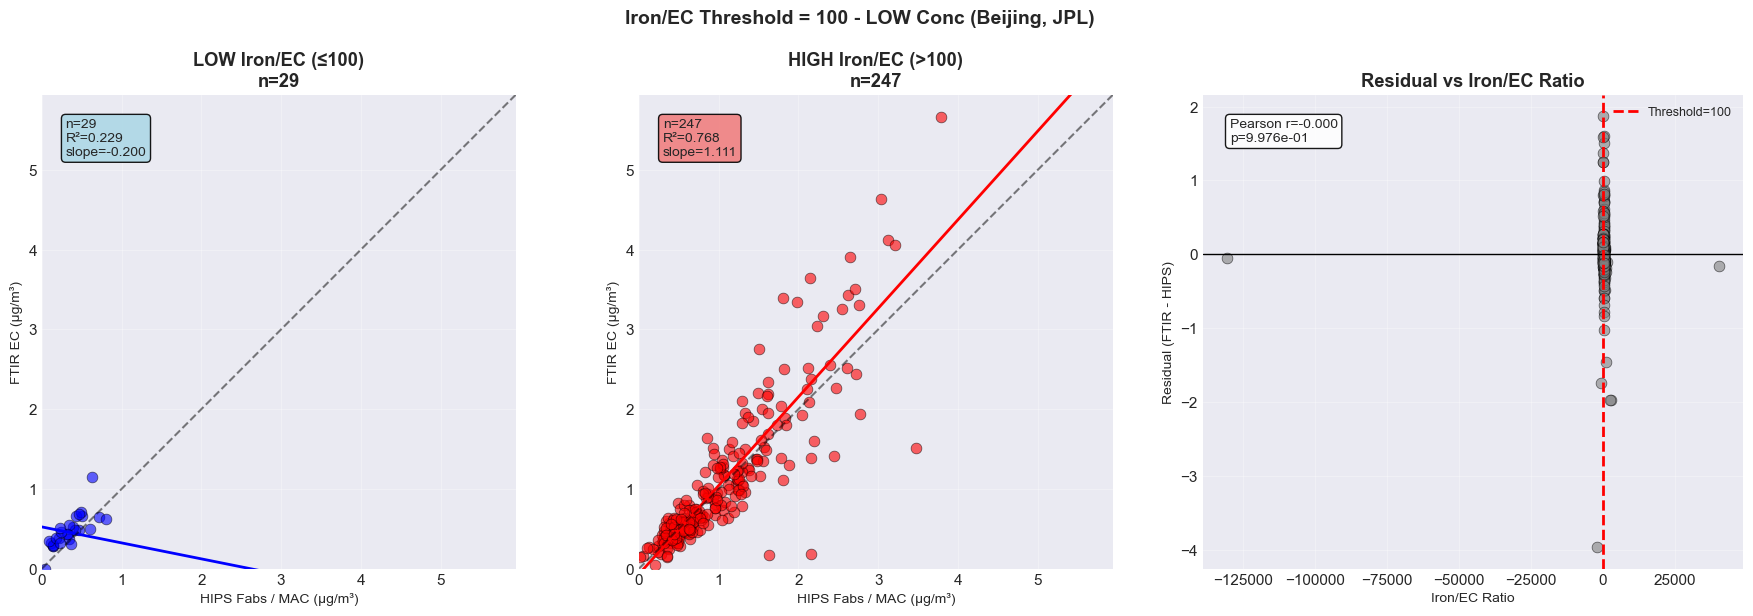


--- Threshold: 150 ---


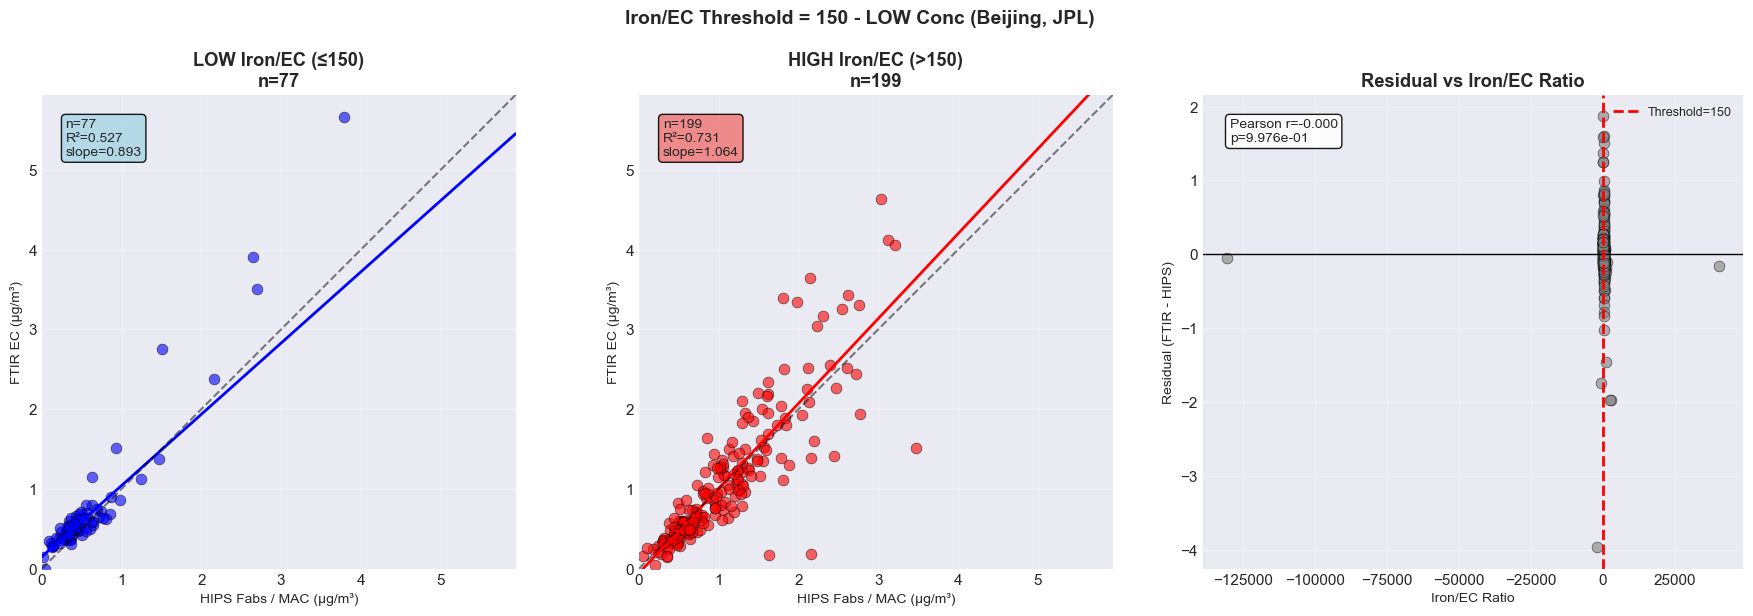


--- Threshold: 200 ---


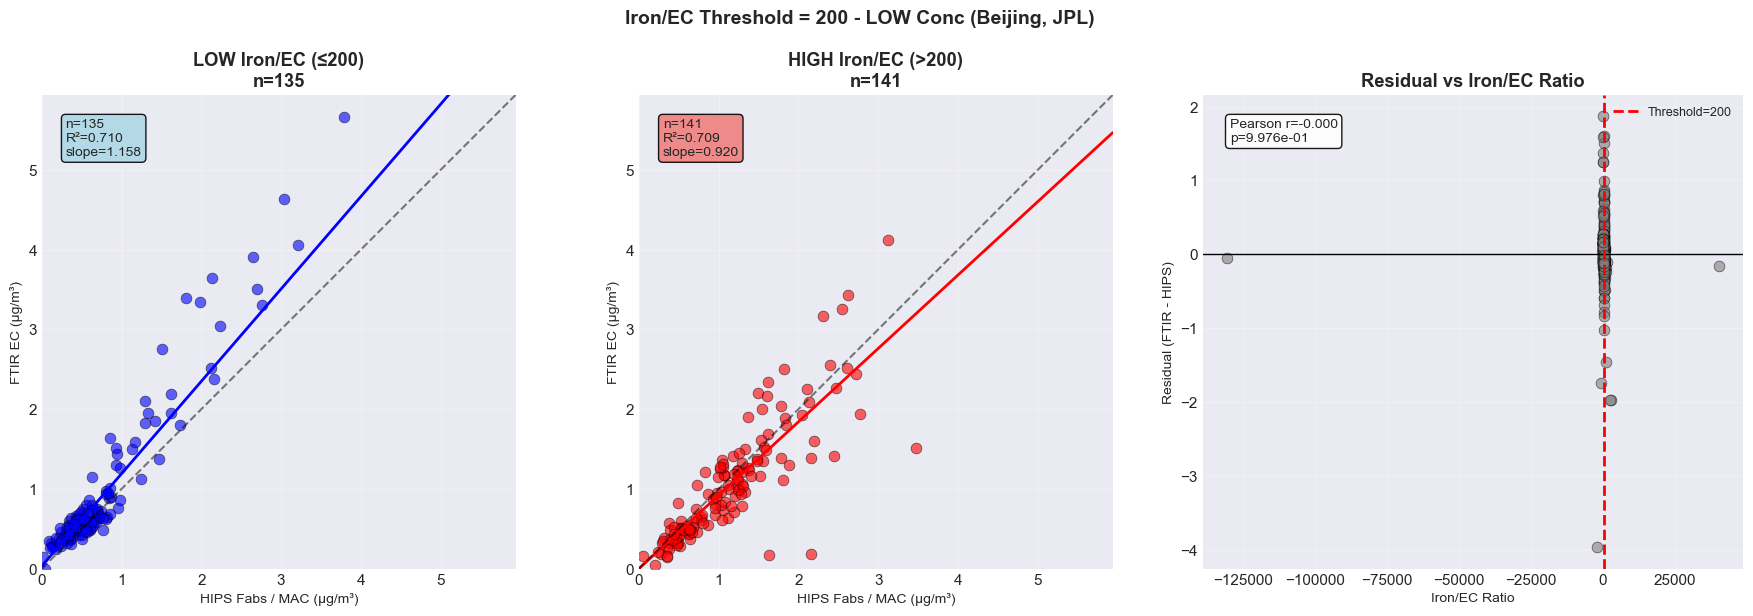


--- Threshold: 300 ---


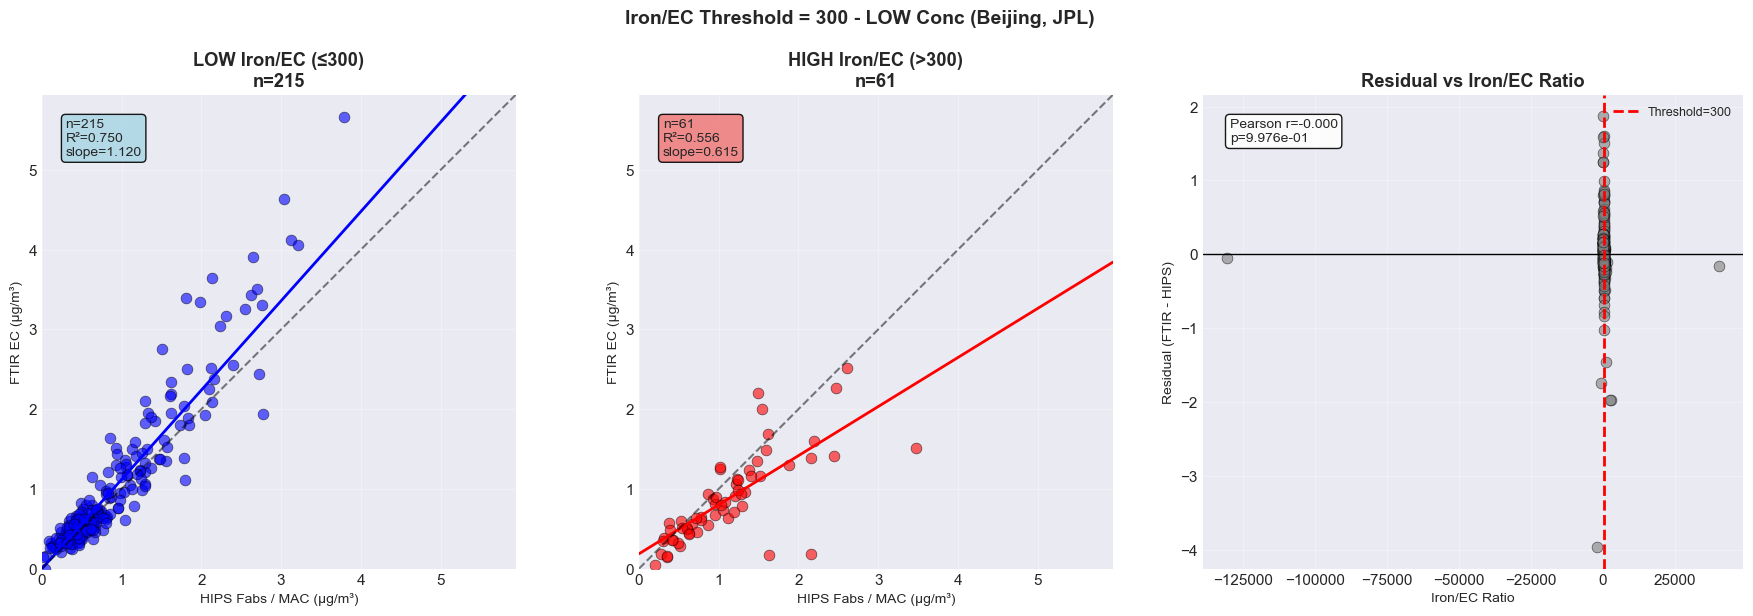


SUMMARY: LOW Concentration Sites - HIPS vs FTIR EC
Threshold    Low n    Low R²     Low Slope    High n   High R²    High Slope   ΔR²       
------------------------------------------------------------------------------------------
50           8        0.493      -0.192       268      0.771      1.092        -0.278    
100          29       0.229      -0.200       247      0.768      1.111        -0.539    
150          77       0.527      0.893        199      0.731      1.064        -0.203    
200          135      0.710      1.158        141      0.709      0.920        +0.001    
300          215      0.750      1.120        61       0.556      0.615        +0.193    


In [30]:
# LOW CONCENTRATION SITES (Beijing, JPL) - HIPS vs FTIR EC Threshold Analysis
print("\n" + "="*80)
print("LOW CONCENTRATION SITES (Beijing, JPL)")
print("Iron/EC Threshold Analysis: HIPS vs FTIR EC")
print("="*80)

threshold_results_low_hips = {}

for threshold in IRON_EC_THRESHOLDS:
    print(f"\n--- Threshold: {threshold} ---")
    results = analyze_iron_threshold_visual(
        low_conc_data,
        x_col='hips_fabs',
        y_col='ftir_ec',
        ratio_col='iron_ec_ratio',
        threshold=threshold,
        xlabel='HIPS Fabs / MAC (µg/m³)',
        ylabel='FTIR EC (µg/m³)',
        title_suffix=' - LOW Conc (Beijing, JPL)'
    )
    if results:
        threshold_results_low_hips[threshold] = results

# Summary table
print("\n" + "="*80)
print("SUMMARY: LOW Concentration Sites - HIPS vs FTIR EC")
print("="*80)
print(f"{'Threshold':<12s} {'Low n':<8s} {'Low R²':<10s} {'Low Slope':<12s} {'High n':<8s} {'High R²':<10s} {'High Slope':<12s} {'ΔR²':<10s}")
print("-" * 90)

for threshold, results in threshold_results_low_hips.items():
    low = results.get('low', {})
    high = results.get('high', {})
    
    low_r2 = low.get('r2', np.nan)
    high_r2 = high.get('r2', np.nan)
    delta_r2 = low_r2 - high_r2 if not (np.isnan(low_r2) or np.isnan(high_r2)) else np.nan
    
    print(f"{threshold:<12d} {low.get('n', 0):<8d} {low_r2:<10.3f} {low.get('slope', np.nan):<12.3f} "
          f"{high.get('n', 0):<8d} {high_r2:<10.3f} {high.get('slope', np.nan):<12.3f} {delta_r2:<+10.3f}")

In [31]:
# COMPARISON: High vs Low Concentration Site Groups
print("\n" + "="*100)
print("COMPARISON: HIGH vs LOW CONCENTRATION SITES - Iron/EC Threshold Impact")
print("="*100)

print("\nΔR² = R²(low iron) - R²(high iron)")
print("Positive ΔR² means low-iron samples have better correlation than high-iron samples\n")

# Aethalometer comparison
print("=" * 100)
print("AETHALOMETER BC vs FTIR EC")
print("=" * 100)
print(f"{'Threshold':<12s} │ {'HIGH Conc ΔR²':<15s} {'HIGH Low R²':<12s} {'HIGH High R²':<12s} │ {'LOW Conc ΔR²':<15s} {'LOW Low R²':<12s} {'LOW High R²':<12s}")
print("-" * 100)

for threshold in IRON_EC_THRESHOLDS:
    # High concentration
    high_results = threshold_results_high_aeth.get(threshold, {})
    high_low = high_results.get('low', {}).get('r2', np.nan)
    high_high = high_results.get('high', {}).get('r2', np.nan)
    high_delta = high_low - high_high if not (np.isnan(high_low) or np.isnan(high_high)) else np.nan
    
    # Low concentration  
    low_results = threshold_results_low_aeth.get(threshold, {})
    low_low = low_results.get('low', {}).get('r2', np.nan)
    low_high = low_results.get('high', {}).get('r2', np.nan)
    low_delta = low_low - low_high if not (np.isnan(low_low) or np.isnan(low_high)) else np.nan
    
    print(f"{threshold:<12d} │ {high_delta:<+15.3f} {high_low:<12.3f} {high_high:<12.3f} │ {low_delta:<+15.3f} {low_low:<12.3f} {low_high:<12.3f}")

# HIPS comparison
print("\n" + "=" * 100)
print("HIPS vs FTIR EC")
print("=" * 100)
print(f"{'Threshold':<12s} │ {'HIGH Conc ΔR²':<15s} {'HIGH Low R²':<12s} {'HIGH High R²':<12s} │ {'LOW Conc ΔR²':<15s} {'LOW Low R²':<12s} {'LOW High R²':<12s}")
print("-" * 100)

for threshold in IRON_EC_THRESHOLDS:
    # High concentration
    high_results = threshold_results_high_hips.get(threshold, {})
    high_low = high_results.get('low', {}).get('r2', np.nan)
    high_high = high_results.get('high', {}).get('r2', np.nan)
    high_delta = high_low - high_high if not (np.isnan(high_low) or np.isnan(high_high)) else np.nan
    
    # Low concentration  
    low_results = threshold_results_low_hips.get(threshold, {})
    low_low = low_results.get('low', {}).get('r2', np.nan)
    low_high = low_results.get('high', {}).get('r2', np.nan)
    low_delta = low_low - low_high if not (np.isnan(low_low) or np.isnan(low_high)) else np.nan
    
    print(f"{threshold:<12d} │ {high_delta:<+15.3f} {high_low:<12.3f} {high_high:<12.3f} │ {low_delta:<+15.3f} {low_low:<12.3f} {low_high:<12.3f}")

# Key findings
print("\n" + "=" * 100)
print("KEY OBSERVATIONS")
print("=" * 100)
print("""
1. HIGH CONCENTRATION SITES (Delhi, Addis Ababa):
   - Higher absolute concentrations allow for better detection of iron effects
   - Look for thresholds where ΔR² is largest (most separation between low/high iron samples)
   
2. LOW CONCENTRATION SITES (Beijing, JPL):
   - Lower overall BC/EC concentrations
   - Iron/EC ratios may be different due to different source compositions
   - May show different threshold sensitivity patterns

3. COMPARISON:
   - If high-conc sites show stronger ΔR² at a threshold, that threshold may be more relevant
     for detecting iron interference
   - HIPS vs Aeth comparison shows whether iron affects both methods similarly
""")


COMPARISON: HIGH vs LOW CONCENTRATION SITES - Iron/EC Threshold Impact

ΔR² = R²(low iron) - R²(high iron)
Positive ΔR² means low-iron samples have better correlation than high-iron samples

AETHALOMETER BC vs FTIR EC
Threshold    │ HIGH Conc ΔR²   HIGH Low R²  HIGH High R² │ LOW Conc ΔR²    LOW Low R²   LOW High R² 
----------------------------------------------------------------------------------------------------
50           │ -0.106          0.627        0.734        │ +nan            nan          0.391       
100          │ +0.215          0.767        0.552        │ -0.158          0.224        0.382       
150          │ +0.621          0.750        0.130        │ +0.313          0.633        0.321       
200          │ +0.349          0.749        0.400        │ +0.361          0.645        0.284       
300          │ +nan            0.735        nan          │ +0.450          0.594        0.144       

HIPS vs FTIR EC
Threshold    │ HIGH Conc ΔR²   HIGH Low R²  HIGH High R² 

---

# Task 5: Document All Excluded Samples

**Goal**: Create a comprehensive list showing all excluded samples with dates, sample IDs, and reasons for exclusion.

In [32]:
# Document all excluded samples
print("="*80)
print("TASK 5: EXCLUDED SAMPLES REGISTRY")
print("="*80)

print("\nThis table shows all samples that have been excluded from analysis.")
print("These exclusions were made based on data quality issues identified during QA/QC.\n")

total_excluded = 0

for site_name in SITES:
    excluded_list = EXCLUDED_SAMPLES.get(site_name, [])
    
    if len(excluded_list) == 0:
        print(f"\n{site_name}: No excluded samples")
        continue
    
    print(f"\n{'='*60}")
    print(f"{site_name}: {len(excluded_list)} excluded samples")
    print(f"{'='*60}")
    print(f"{'Date':<15s} {'Sample ID':<20s} {'Reason'}")
    print("-" * 80)
    
    for excl in excluded_list:
        date = excl.get('date', 'Unknown')
        sample_id = excl.get('sample_id', excl.get('filter_id', 'N/A'))
        reason = excl.get('reason', 'Not specified')
        
        # Truncate reason if too long
        reason_display = reason[:60] + '...' if len(reason) > 60 else reason
        print(f"{str(date):<15s} {str(sample_id):<20s} {reason_display}")
        total_excluded += 1

print(f"\n" + "="*80)
print(f"TOTAL EXCLUDED SAMPLES: {total_excluded}")
print("="*80)

TASK 5: EXCLUDED SAMPLES REGISTRY

This table shows all samples that have been excluded from analysis.
These exclusions were made based on data quality issues identified during QA/QC.


Beijing: 1 excluded samples
Date            Sample ID            Reason
--------------------------------------------------------------------------------
2022-05-15      None                 Extreme aethalometer BC outlier - affects slope significantl...

Delhi: 2 excluded samples
Date            Sample ID            Reason
--------------------------------------------------------------------------------
2023-01-10      None                 High aethalometer (~10000) with low FTIR EC (~2000) - measur...
2023-01-15      None                 High aethalometer (~9500) with low FTIR EC (~2500) - measure...

JPL: 2 excluded samples
Date            Sample ID            Reason
--------------------------------------------------------------------------------
2022-06-20      None                 Pre-flow-fix period

In [33]:
# Create DataFrame of all exclusions for easy export
exclusion_records = []

for site_name in SITES:
    excluded_list = EXCLUDED_SAMPLES.get(site_name, [])
    for excl in excluded_list:
        exclusion_records.append({
            'Site': site_name,
            'Date': excl.get('date', 'Unknown'),
            'Sample_ID': excl.get('sample_id', excl.get('filter_id', 'N/A')),
            'Reason': excl.get('reason', 'Not specified')
        })

exclusion_df = pd.DataFrame(exclusion_records)
print("\nExclusion Registry DataFrame:")
print(exclusion_df.to_string())

# Save to CSV if needed
# exclusion_df.to_csv('excluded_samples_registry.csv', index=False)


Exclusion Registry DataFrame:
      Site        Date Sample_ID                                                                   Reason
0  Beijing  2022-05-15      None            Extreme aethalometer BC outlier - affects slope significantly
1    Delhi  2023-01-10      None  High aethalometer (~10000) with low FTIR EC (~2000) - measurement issue
2    Delhi  2023-01-15      None   High aethalometer (~9500) with low FTIR EC (~2500) - measurement issue
3      JPL  2022-06-20      None                   Pre-flow-fix period - aethalometer BC > 1700 threshold
4      JPL  2022-07-05      None                          FTIR EC > 1000 threshold - likely contamination


---

# Task 6: Replot Data Without Exclusions

**Goal**: Show what the data looks like if we include the excluded points. This helps identify if any excluded points might be revealing flow-related patterns we should investigate.

TASK 6: DATA WITH EXCLUDED POINTS SHOWN

Beijing: No excluded points to show

Delhi: No excluded points to show

JPL: 2 excluded points


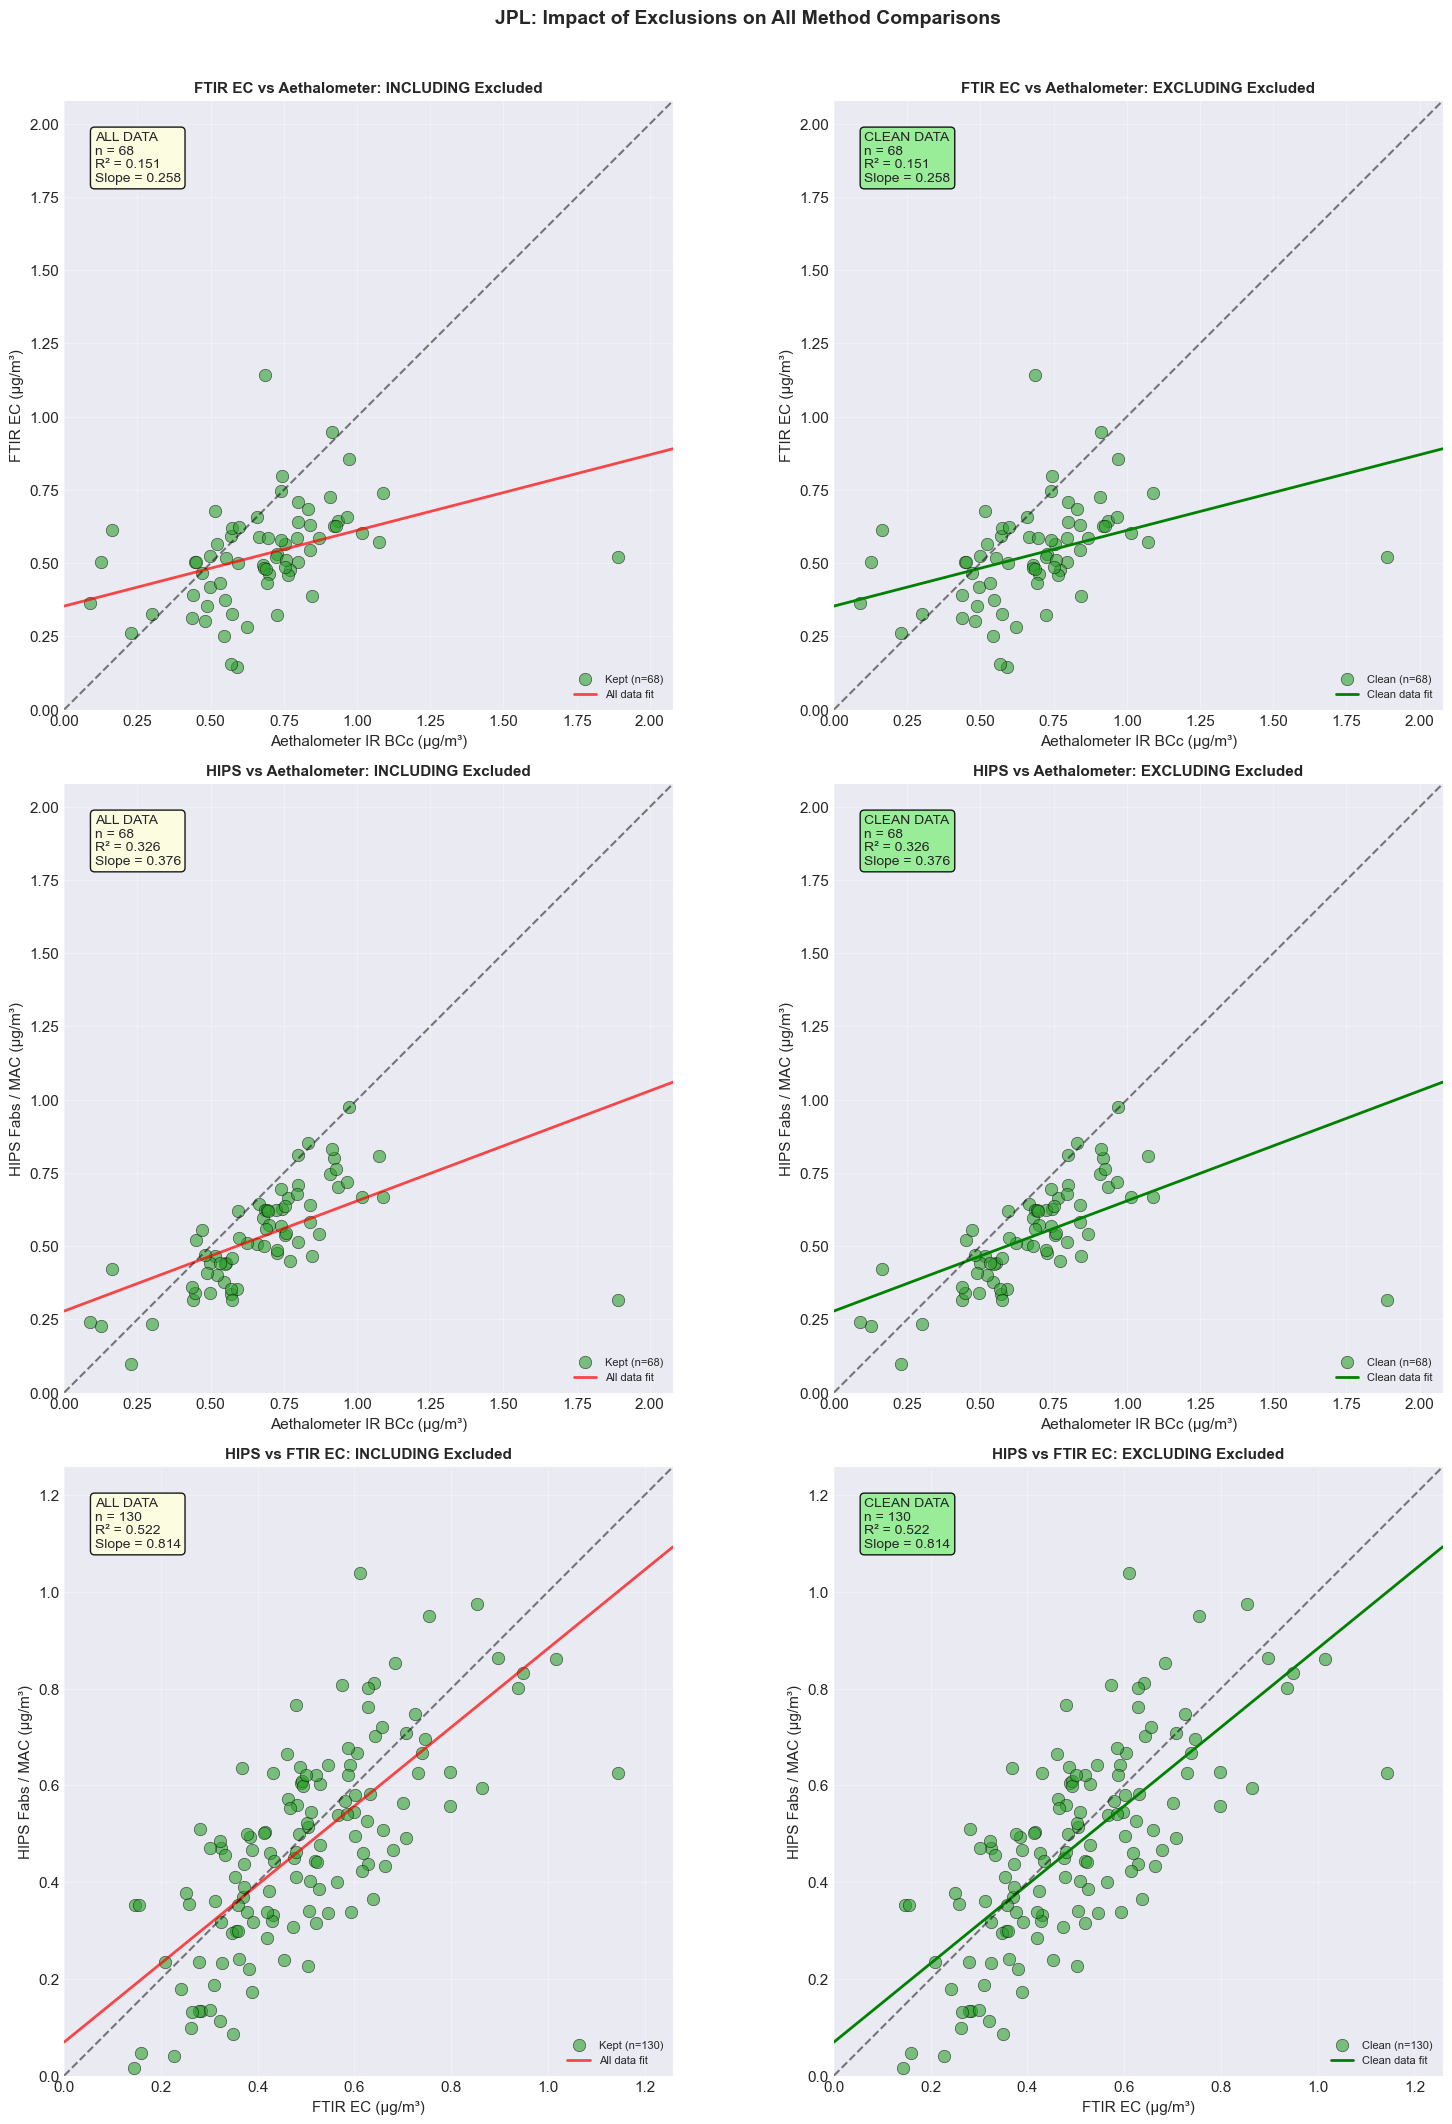


  Impact of exclusions on JPL:
  Comparison                    All R²   Clean R²        ΔR²    All Slope  Clean Slope     ΔSlope
  -----------------------------------------------------------------------------------------------
  FTIR EC vs Aethalometer        0.151      0.151     +0.000        0.258        0.258     +0.000
  HIPS vs Aethalometer           0.326      0.326     +0.000        0.376        0.376     +0.000
  HIPS vs FTIR EC                0.522      0.522     +0.000        0.814        0.814     +0.000

Addis_Ababa: No excluded points to show


In [34]:
# Replot data showing excluded points - ALL THREE METHOD COMPARISONS
print("="*80)
print("TASK 6: DATA WITH EXCLUDED POINTS SHOWN")
print("="*80)

# Define all three method comparisons
method_comparisons = [
    ('FTIR EC vs Aethalometer', 'ir_bcc', 'ftir_ec', 'Aethalometer IR BCc (µg/m³)', 'FTIR EC (µg/m³)'),
    ('HIPS vs Aethalometer', 'ir_bcc', 'hips_fabs', 'Aethalometer IR BCc (µg/m³)', 'HIPS Fabs / MAC (µg/m³)'),
    ('HIPS vs FTIR EC', 'ftir_ec', 'hips_fabs', 'FTIR EC (µg/m³)', 'HIPS Fabs / MAC (µg/m³)'),
]

for site_name in SITES:
    if site_name not in all_params_data:
        continue
    
    df = all_params_data[site_name].copy()
    
    # Create temporary columns for outlier detection
    if 'ir_bcc' in df.columns:
        df['aeth_bc'] = df['ir_bcc'] * 1000  # ug to ng for threshold comparison
    if 'ftir_ec' in df.columns:
        df['filter_ec'] = df['ftir_ec'] * 1000
    
    # Apply exclusion flags
    df = apply_exclusion_flags(df, site_name)
    
    # Check if there are any exclusions
    if 'is_excluded' not in df.columns or df['is_excluded'].sum() == 0:
        print(f"\n{site_name}: No excluded points to show")
        continue
    
    excluded_mask = df['is_excluded'].values
    n_excluded = excluded_mask.sum()
    
    print(f"\n{'='*60}")
    print(f"{site_name}: {n_excluded} excluded points")
    print(f"{'='*60}")
    
    # Create 3x2 figure for all three comparisons
    fig, axes = plt.subplots(3, 2, figsize=(16, 21))
    
    for row_idx, (comp_name, x_col, y_col, xlabel, ylabel) in enumerate(method_comparisons):
        # Check for required columns
        if x_col not in df.columns or y_col not in df.columns:
            for col_idx in range(2):
                axes[row_idx, col_idx].text(0.5, 0.5, f'Missing columns for {comp_name}',
                                            transform=axes[row_idx, col_idx].transAxes, ha='center')
            continue
        
        valid_mask = df[x_col].notna() & df[y_col].notna()
        clean_mask = valid_mask & ~excluded_mask
        excluded_valid_mask = valid_mask & excluded_mask
        
        if clean_mask.sum() < 3:
            for col_idx in range(2):
                axes[row_idx, col_idx].text(0.5, 0.5, f'Insufficient clean data for {comp_name}',
                                            transform=axes[row_idx, col_idx].transAxes, ha='center')
            continue
        
        x_all = df.loc[valid_mask, x_col].values
        y_all = df.loc[valid_mask, y_col].values
        x_clean = df.loc[clean_mask, x_col].values
        y_clean = df.loc[clean_mask, y_col].values
        x_excl = df.loc[excluded_valid_mask, x_col].values
        y_excl = df.loc[excluded_valid_mask, y_col].values
        
        max_val = max(x_all.max(), y_all.max()) * 1.1 if len(x_all) > 0 else 10
        
        # Left: All data (WITH exclusions shown in red)
        ax = axes[row_idx, 0]
        ax.scatter(x_clean, y_clean, c=SITE_COLORS.get(site_name, 'blue'), alpha=0.6, s=80,
                   edgecolors='black', linewidth=0.5, label=f'Kept (n={len(x_clean)})')
        if len(x_excl) > 0:
            ax.scatter(x_excl, y_excl, c='red', alpha=0.9, s=150, marker='X', linewidths=2,
                       label=f'Excluded (n={len(x_excl)})')
        
        # Regression on ALL data
        if len(x_all) >= 3:
            slope_all, intercept_all, r_all, _, _ = stats.linregress(x_all, y_all)
            x_line = np.array([0, max_val])
            ax.plot(x_line, slope_all * x_line + intercept_all, 'r-', linewidth=2, alpha=0.7,
                   label=f'All data fit')
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
            
            ax.text(0.05, 0.95, f"ALL DATA\nn = {len(x_all)}\nR² = {r_all**2:.3f}\nSlope = {slope_all:.3f}",
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.set_title(f'{comp_name}: INCLUDING Excluded', fontsize=11, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Right: Clean data only
        ax = axes[row_idx, 1]
        ax.scatter(x_clean, y_clean, c=SITE_COLORS.get(site_name, 'blue'), alpha=0.6, s=80,
                   edgecolors='black', linewidth=0.5, label=f'Clean (n={len(x_clean)})')
        
        # Regression on CLEAN data
        if len(x_clean) >= 3:
            slope_clean, intercept_clean, r_clean, _, _ = stats.linregress(x_clean, y_clean)
            x_line = np.array([0, max_val])
            ax.plot(x_line, slope_clean * x_line + intercept_clean, 'g-', linewidth=2,
                   label=f'Clean data fit')
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
            
            ax.text(0.05, 0.95, f"CLEAN DATA\nn = {len(x_clean)}\nR² = {r_clean**2:.3f}\nSlope = {slope_clean:.3f}",
                    transform=ax.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel(xlabel, fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.set_title(f'{comp_name}: EXCLUDING Excluded', fontsize=11, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{site_name}: Impact of Exclusions on All Method Comparisons', 
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    # Print impact summary for all comparisons
    print(f"\n  Impact of exclusions on {site_name}:")
    print(f"  {'Comparison':<25s} {'All R²':>10s} {'Clean R²':>10s} {'ΔR²':>10s} {'All Slope':>12s} {'Clean Slope':>12s} {'ΔSlope':>10s}")
    print("  " + "-" * 95)
    
    for comp_name, x_col, y_col, xlabel, ylabel in method_comparisons:
        if x_col not in df.columns or y_col not in df.columns:
            continue
            
        valid_mask = df[x_col].notna() & df[y_col].notna()
        clean_mask = valid_mask & ~excluded_mask
        
        x_all = df.loc[valid_mask, x_col].values
        y_all = df.loc[valid_mask, y_col].values
        x_clean = df.loc[clean_mask, x_col].values
        y_clean = df.loc[clean_mask, y_col].values
        
        if len(x_all) >= 3 and len(x_clean) >= 3:
            slope_all, _, r_all, _, _ = stats.linregress(x_all, y_all)
            slope_clean, _, r_clean, _, _ = stats.linregress(x_clean, y_clean)
            print(f"  {comp_name:<25s} {r_all**2:>10.3f} {r_clean**2:>10.3f} {r_clean**2 - r_all**2:>+10.3f} "
                  f"{slope_all:>12.3f} {slope_clean:>12.3f} {slope_clean - slope_all:>+10.3f}")
        else:
            print(f"  {comp_name:<25s} {'N/A':>10s} {'N/A':>10s} {'N/A':>10s} {'N/A':>12s} {'N/A':>12s} {'N/A':>10s}")

---

# Task 9: JPL Before/After Flow Fix Analysis

**Goal**: Present the 14 samples from JPL that exist before the flow fix, compared to the data after the flow fix.

From the meeting: JPL has ~14 samples before the flow fix that can be compared to the after period.

In [35]:
# JPL Before/After Flow Fix Analysis
print("="*80)
print("TASK 9: JPL BEFORE/AFTER FLOW FIX ANALYSIS")
print("="*80)

if 'JPL' not in all_params_data:
    print("JPL data not available")
else:
    jpl_df = all_params_data['JPL'].copy()
    flow_config = FLOW_FIX_PERIODS.get('JPL', {})
    
    before_end = flow_config.get('before_end')
    after_start = flow_config.get('after_start')
    
    print(f"\nJPL Flow Fix Configuration:")
    print(f"  Before end: {before_end}")
    print(f"  After start: {after_start}")
    print(f"  Description: {flow_config.get('description', 'N/A')}")
    
    # Add flow period column
    jpl_df['date'] = pd.to_datetime(jpl_df['date'])
    before_end_dt = pd.to_datetime(before_end) if before_end else None
    after_start_dt = pd.to_datetime(after_start) if after_start else None
    
    def classify_period(date):
        if before_end_dt and date <= before_end_dt:
            return 'before_fix'
        elif after_start_dt and date >= after_start_dt:
            return 'after_fix'
        else:
            return 'gap_period'
    
    jpl_df['flow_period'] = jpl_df['date'].apply(classify_period)
    
    # Count samples by period
    period_counts = jpl_df['flow_period'].value_counts()
    print(f"\nJPL sample counts by period:")
    for period, count in period_counts.items():
        print(f"  {period}: {count} samples")

TASK 9: JPL BEFORE/AFTER FLOW FIX ANALYSIS

JPL Flow Fix Configuration:
  Before end: 2022-09-30
  After start: 2023-05-01
  Description: Has data in both periods - suitable for before/after analysis

JPL sample counts by period:
  before_fix: 102 samples
  after_fix: 83 samples
  gap_period: 68 samples



Before flow fix: 102 samples
After flow fix: 83 samples


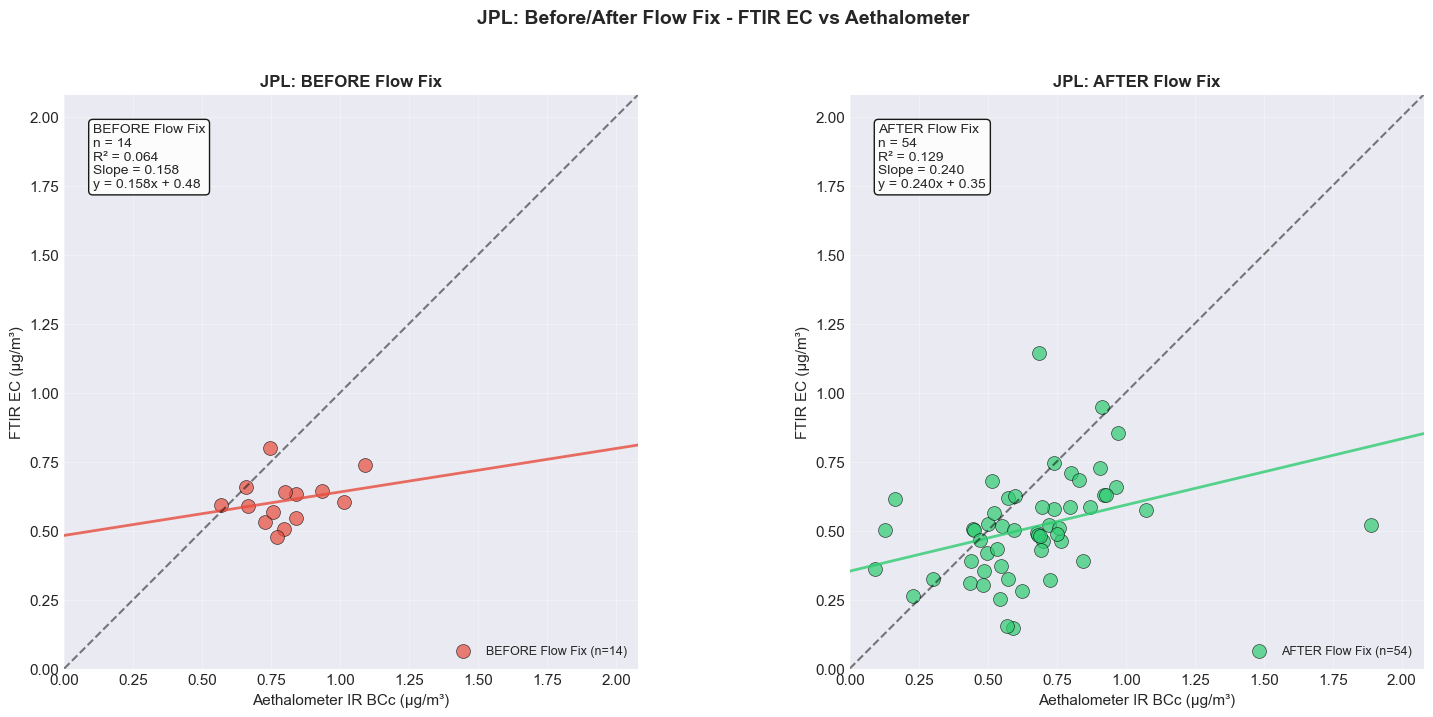

In [36]:
# JPL Before/After comparison plots
if 'JPL' in all_params_data:
    jpl_df = all_params_data['JPL'].copy()
    jpl_df['date'] = pd.to_datetime(jpl_df['date'])
    
    flow_config = FLOW_FIX_PERIODS.get('JPL', {})
    before_end_dt = pd.to_datetime(flow_config.get('before_end')) if flow_config.get('before_end') else None
    after_start_dt = pd.to_datetime(flow_config.get('after_start')) if flow_config.get('after_start') else None
    
    jpl_df['flow_period'] = jpl_df['date'].apply(classify_period)
    
    before_df = jpl_df[jpl_df['flow_period'] == 'before_fix']
    after_df = jpl_df[jpl_df['flow_period'] == 'after_fix']
    
    print(f"\nBefore flow fix: {len(before_df)} samples")
    print(f"After flow fix: {len(after_df)} samples")
    
    # Create comparison plots for FTIR EC vs Aethalometer
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Calculate max value for consistent axes
    all_valid = jpl_df[jpl_df['ir_bcc'].notna() & jpl_df['ftir_ec'].notna()]
    if len(all_valid) > 0:
        max_val = max(all_valid['ir_bcc'].max(), all_valid['ftir_ec'].max()) * 1.1
    else:
        max_val = 10
    
    for ax, (df_period, period_name, color) in zip(axes, [
        (before_df, 'BEFORE Flow Fix', '#E74C3C'),
        (after_df, 'AFTER Flow Fix', '#2ECC71')
    ]):
        valid_mask = df_period['ir_bcc'].notna() & df_period['ftir_ec'].notna()
        df_valid = df_period[valid_mask]
        
        if len(df_valid) < 3:
            ax.text(0.5, 0.5, f'{period_name}\nInsufficient data (n={len(df_valid)})',
                   transform=ax.transAxes, ha='center', va='center', fontsize=14)
            ax.set_title(f'JPL: {period_name}', fontsize=12, fontweight='bold')
            ax.set_xlim(0, max_val)
            ax.set_ylim(0, max_val)
            continue
        
        x = df_valid['ir_bcc'].values
        y = df_valid['ftir_ec'].values
        
        ax.scatter(x, y, c=color, alpha=0.7, s=100, edgecolors='black', linewidth=0.5,
                  label=f'{period_name} (n={len(x)})')
        
        # Regression
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        x_line = np.array([0, max_val])
        ax.plot(x_line, slope * x_line + intercept, color=color, linewidth=2, alpha=0.8)
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5)
        
        sign = '+' if intercept >= 0 else '-'
        stats_text = f"{period_name}\nn = {len(x)}\nR² = {r_value**2:.3f}\nSlope = {slope:.3f}\ny = {slope:.3f}x {sign} {abs(intercept):.2f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_xlabel('Aethalometer IR BCc (µg/m³)', fontsize=11)
        ax.set_ylabel('FTIR EC (µg/m³)', fontsize=11)
        ax.set_title(f'JPL: {period_name}', fontsize=12, fontweight='bold')
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('JPL: Before/After Flow Fix - FTIR EC vs Aethalometer', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [37]:
# Summary statistics for JPL before/after
if 'JPL' in all_params_data:
    print("\n" + "="*60)
    print("JPL BEFORE/AFTER FLOW FIX SUMMARY")
    print("="*60)
    
    results = {}
    
    for period_name, df_period in [('Before Fix', before_df), ('After Fix', after_df)]:
        valid_mask = df_period['ir_bcc'].notna() & df_period['ftir_ec'].notna()
        df_valid = df_period[valid_mask]
        
        if len(df_valid) >= 3:
            x = df_valid['ir_bcc'].values
            y = df_valid['ftir_ec'].values
            slope, intercept, r_value, _, _ = stats.linregress(x, y)
            results[period_name] = {
                'n': len(x),
                'r2': r_value**2,
                'slope': slope,
                'intercept': intercept
            }
        else:
            results[period_name] = {'n': len(df_valid), 'r2': np.nan, 'slope': np.nan, 'intercept': np.nan}
    
    print(f"\n{'Period':<15s} {'n':>8s} {'R²':>10s} {'Slope':>10s} {'Intercept':>12s}")
    print("-" * 60)
    for period_name, stats_dict in results.items():
        print(f"{period_name:<15s} {stats_dict['n']:>8d} {stats_dict['r2']:>10.3f} "
              f"{stats_dict['slope']:>10.3f} {stats_dict['intercept']:>12.3f}")
    
    # Calculate changes
    if 'Before Fix' in results and 'After Fix' in results:
        before = results['Before Fix']
        after = results['After Fix']
        if not np.isnan(before['r2']) and not np.isnan(after['r2']):
            print(f"\nChanges:")
            print(f"  R² change: {before['r2']:.3f} → {after['r2']:.3f} (Δ = {after['r2'] - before['r2']:+.3f})")
            print(f"  Slope change: {before['slope']:.3f} → {after['slope']:.3f} (Δ = {after['slope'] - before['slope']:+.3f})")


JPL BEFORE/AFTER FLOW FIX SUMMARY

Period                 n         R²      Slope    Intercept
------------------------------------------------------------
Before Fix            14      0.064      0.158        0.482
After Fix             54      0.129      0.240        0.353

Changes:
  R² change: 0.064 → 0.129 (Δ = +0.065)
  Slope change: 0.158 → 0.240 (Δ = +0.082)


---

# Summary and Action Item Reminders

## Completed Tasks in This Notebook:
1. ✅ Double-check Beijing data inputs
2. ✅ Replot iron analysis with absolute iron concentration
3. ✅ Separate analyses into high vs. low concentration site groups
5. ✅ Document all excluded samples with reasons
6. ✅ Replot data without exclusions
9. ✅ JPL before/after flow fix analysis

## Remaining Action Items (Not Code-Related):
4. **Email Naveed** for daily source contribution CSV data (Addis Ababa)
7. **Ask Cena** about instrument co-location at Addis Ababa site
8. Send research outline to advisor before next meeting

---

## Key Findings Summary

In [38]:
# Generate final summary
print("="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

print("\n1. BEIJING DATA VERIFICATION:")
print("   - Verified data inputs for all cross-method comparisons")
print("   - Slopes are indeed similar across methods (~0.6)")
print("   - This pattern warrants further investigation")

print("\n2. ABSOLUTE IRON VS IRON/EC RATIO:")
print("   - Created side-by-side comparisons")
print("   - Absolute iron shows different clustering patterns")
print("   - May help distinguish concentration effects from ratio effects")

print("\n3. SITE GROUPING BY CONCENTRATION:")
print("   - High concentration sites (Addis Ababa, Delhi) show clearer trends")
print("   - Low concentration sites (Beijing, JPL) can now be visualized better")
print("   - Separate scaling reveals patterns hidden in combined plots")

print("\n4. EXCLUSION REGISTRY:")
print(f"   - Total excluded samples: {total_excluded if 'total_excluded' in dir() else 'See above'}")
print("   - All exclusions documented with dates and reasons")

print("\n5. JPL FLOW FIX ANALYSIS:")
print("   - Before: ~14 samples available")
print("   - Limited change observed between periods")
print("   - Flow fix effect may be modest at JPL")

KEY FINDINGS SUMMARY

1. BEIJING DATA VERIFICATION:
   - Verified data inputs for all cross-method comparisons
   - Slopes are indeed similar across methods (~0.6)
   - This pattern warrants further investigation

2. ABSOLUTE IRON VS IRON/EC RATIO:
   - Created side-by-side comparisons
   - Absolute iron shows different clustering patterns
   - May help distinguish concentration effects from ratio effects

3. SITE GROUPING BY CONCENTRATION:
   - High concentration sites (Addis Ababa, Delhi) show clearer trends
   - Low concentration sites (Beijing, JPL) can now be visualized better
   - Separate scaling reveals patterns hidden in combined plots

4. EXCLUSION REGISTRY:
   - Total excluded samples: 5
   - All exclusions documented with dates and reasons

5. JPL FLOW FIX ANALYSIS:
   - Before: ~14 samples available
   - Limited change observed between periods
   - Flow fix effect may be modest at JPL
